# HECRASController Profiles

In [1]:
# Uncomment to install/upgrade ras-commander from pip
#!pip install --upgrade ras-commander

#Import the ras-commander package
from ras_commander import *

2025-11-17 14:05:26 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


##### Optional Code Cell For Development/Testing Mode (Local Copy)
##### Uncomment and run this cell instead of the pip cell above

```python
# For Development Mode, add the parent directory to the Python path
import os
import sys
from pathlib import Path

current_file = Path(os.getcwd()).resolve()
rascmdr_directory = current_file.parent

# Use insert(0) instead of append() to give highest priority to local version
if str(rascmdr_directory) not in sys.path:
    sys.path.insert(0, str(rascmdr_directory))

print("Loading ras-commander from local dev copy")
from ras_commander import *
```

# Working with Legacy HEC-RAS Using RasControl

This notebook demonstrates **RasControl**, which provides a ras-commander style API for legacy HEC-RAS versions (3.x-4.x) using the HECRASController COM interface.

## What is RasControl?

**RasControl** wraps the HECRASController COM API with ras-commander conventions:

- ✅ **Use plan numbers** - `RasControl.run_plan("02")` not file paths
- ✅ **Integrated with ras object** - Works with `init_ras_project()`
- ✅ **Steady AND unsteady** - Extract profiles and time series
- ✅ **Auto-sets current plan** - Just pass the plan number!
- ✅ **No COM complexity** - Clean public API

## When to Use RasControl

| Use RasControl | Use HDF Methods |
|----------------|----------------|
| HEC-RAS 3.1, 4.1 | HEC-RAS 6.0+ |
| No HDF support | Modern versions |
| Legacy models | 2D mesh data |
| Version migration | Better performance |

## Supported Versions

3.0, 3.1, 4.0, 4.1, 5.0-5.0.7, 6.0-6.7 Beta

Accepts: `"4.1"`, `"41"`, `"5.0.6"`, `"506"`, `"6.6"`, `"66"`, etc.

## Setup

In [2]:
#!pip install --upgrade ras-commander

In [3]:
import os, sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# ============================================================================
# PLOTTING CONFIGURATION
# ============================================================================

# Set better default plotting parameters
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9

import numpy as np  # Add if not already imported

print("✓ Plotting configuration loaded")


✓ Plotting configuration loaded


In [5]:
# Enable this cell for local development version of ras-commander
import os
import sys      
from pathlib import Path
current_file = Path(os.getcwd()).resolve()
rascmdr_directory = current_file.parent
sys.path.append(str(rascmdr_directory))
print("Loading ras-commander from local dev copy")

# Import RAS-Commander modules
from ras_commander import *

Loading ras-commander from local dev copy


In [6]:
# 2. Import all required modules

# Import all ras-commander modules
from ras_commander import *

# Import the required libraries for this notebook
import os
from pathlib import Path
import pandas as pd
from IPython import display

In [7]:
# Helper Plotting Functions

def plot_steady_profiles_by_reach(df, title_prefix="Steady Flow Profiles"):
    """
    Plot steady flow profiles separated by River/Reach.
    
    Parameters:
    -----------
    df : DataFrame
        Steady results from RasControl.get_steady_results()
    title_prefix : str
        Prefix for plot titles
    """
    import matplotlib.pyplot as plt
    
    # Group by River/Reach
    for (river, reach), group_df in df.groupby(['river', 'reach']):
        fig, ax = plt.subplots(figsize=(14, 6))
        
        # Sort by station (descending - upstream to downstream)
        group_df_sorted = group_df.sort_values('node_id', ascending=False)
        
        # Plot each profile
        profiles = group_df['profile'].unique()
        for profile in profiles:
            prof_data = group_df_sorted[group_df_sorted['profile'] == profile]
            ax.plot(prof_data['node_id'], prof_data['wsel'], 
                    marker='o', label=f'{profile}', linewidth=2, markersize=4)
        
        # Add channel invert
        invert = group_df_sorted.drop_duplicates('node_id')[['node_id', 'min_ch_el']]
        ax.plot(invert['node_id'], invert['min_ch_el'], 
                'k--', label='Channel Invert', linewidth=2, alpha=0.7)
        
        ax.set_xlabel('River Station', fontsize=12)
        ax.set_ylabel('Elevation (ft)', fontsize=12)
        ax.set_title(f'{title_prefix}\n{river} - {reach}', 
                     fontsize=14, fontweight='bold')
        ax.legend(loc='best', fontsize=9, ncol=2)
        ax.grid(True, alpha=0.3)
        ax.invert_xaxis()  # Upstream on left
        plt.tight_layout()
        plt.show()


def plot_unsteady_timeseries_multi_xs(df_timeseries, df_maxws, selected_xs=None, n_xs=5):
    """
    Plot unsteady time series at multiple cross sections with Max WS annotations.
    
    Parameters:
    -----------
    df_timeseries : DataFrame
        Unsteady results WITHOUT 'Max WS' rows, with 'datetime' column
    df_maxws : DataFrame
        Unsteady results for ONLY 'Max WS' rows
    selected_xs : list, optional
        List of specific cross sections to plot. If None, selects evenly spaced XS
    n_xs : int
        Number of cross sections to plot (used if selected_xs is None)
    """
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    
    # Select cross sections if not provided
    if selected_xs is None:
        all_xs = sorted(df_timeseries['node_id'].unique(), reverse=True)
        step = max(1, len(all_xs) // n_xs)
        selected_xs = all_xs[::step][:n_xs]
    
    # Create subplots
    n_xs_plot = len(selected_xs)
    fig, axes = plt.subplots(n_xs_plot, 1, figsize=(14, 4*n_xs_plot))
    if n_xs_plot == 1:
        axes = [axes]
    
    for idx, xs in enumerate(selected_xs):
        ax = axes[idx]
        
        # Get data for this XS
        xs_data = df_timeseries[df_timeseries['node_id'] == xs].sort_values('datetime')
        maxws_data = df_maxws[df_maxws['node_id'] == xs]
        
        # Plot time series
        ax.plot(xs_data['datetime'], xs_data['wsel'], 
                'b-o', linewidth=2, markersize=4, label='WSE at Output Timesteps')
        
        # Get values for annotation
        max_ws_value = maxws_data['wsel'].iloc[0] if len(maxws_data) > 0 else None
        max_output_value = xs_data['wsel'].max()
        
        # Add horizontal reference for Max WS
        if max_ws_value:
            ax.axhline(max_ws_value, color='r', linestyle='--', 
                       linewidth=2, alpha=0.7, label='Max WS (computational)')
        
        # Add annotations
        annotation_text = f"Max WS (computational): {max_ws_value:.2f} ft\n"
        annotation_text += f"Max (output interval): {max_output_value:.2f} ft"
        
        ax.text(0.02, 0.98, annotation_text, 
                transform=ax.transAxes, fontsize=10,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        ax.set_ylabel('WSE (ft)', fontsize=11)
        ax.set_title(f'Station {xs}', fontsize=12, fontweight='bold')
        ax.legend(loc='upper right', fontsize=9)
        ax.grid(True, alpha=0.3)
        
        # Format x-axis for dates
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:%M'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    axes[-1].set_xlabel('Date/Time', fontsize=12)
    plt.tight_layout()
    plt.show()

print("✓ Helper plotting functions loaded")


✓ Helper plotting functions loaded


In [8]:
# Import ras-commander
sys.path.append(str(Path(os.getcwd()).parent))
from ras_commander import RasExamples, init_ras_project, RasControl, ras, RasCmdr

print(f"RasControl supports: {list(RasControl.SUPPORTED_VERSIONS.keys())[:5]}...")

RasControl supports: ['3.0', '30', '3.1', '31', '3.1.1']...


## Extract and Initialize Project

In [9]:
# Extract Bald Eagle Creek (has steady Plan 02 and unsteady Plan 01)
project_path = RasExamples.extract_project("Balde Eagle Creek")

# Initialize with version (required for RasControl)
init_ras_project(project_path, "6.6")  # or "66", "6.5", "4.1", "41", etc.

print(f"Project: {ras.project_name}")
print(f"Version: {ras.ras_version}")
print(f"\nPlans:")
print(ras.plan_df[['plan_number', 'Plan Title', 'flow_type',"full_path"]])

# Use the full_path from plan_df to do the following for each plain text plan file: 
# Find the following values and change them
# Change "Output Interval=10MIN" 
# Change "Mapping Interval=10MIN" 


import re, shutil
from pathlib import Path

# ...existing code...
def update_plan_intervals_from_plan_df(plan_df, plan_numbers=None,
                                       output_interval=None, mapping_interval=None,
                                       make_backup=True, encoding='utf-8'):
    """
    Replace Output Interval and Mapping Interval in plain-text plan files referenced by plan_df['full_path'].
    - plan_numbers: list of plan_number strings to limit changes (e.g. ['01','02']) or None for all.
    - output_interval / mapping_interval: strings like '6MIN', '10MIN' (include unit).
    """
    for _, row in plan_df.iterrows():
        plan_no = str(row.get('plan_number', '')).zfill(2)
        if plan_numbers and plan_no not in [str(p).zfill(2) for p in plan_numbers]:
            continue

        fp = Path(row.get('full_path', ''))
        if not fp.exists():
            print(f"Missing file: {fp}")
            continue

        text = fp.read_text(encoding=encoding, errors='ignore')
        new_text = text

        if output_interval:
            # Use a callable replacement to avoid accidental numeric backreference parsing (e.g. "\16MIN")
            new_text = re.sub(
                r'(?i)(Output\s*Interval\s*=\s*)(\S+)',
                lambda m, out=output_interval: m.group(1) + out,
                new_text
            )

        if mapping_interval:
            new_text = re.sub(
                r'(?i)(Mapping\s*Interval\s*=\s*)(\S+)',
                lambda m, mp=mapping_interval: m.group(1) + mp,
                new_text
            )

        if new_text != text:
            if make_backup:
                bak = fp.with_suffix(fp.suffix + '.bak')
                shutil.copy(fp, bak)
            fp.write_text(new_text, encoding=encoding)
            print(f"Updated {fp} (Plan {plan_no})")
        else:
            print(f"No change needed: {fp} (Plan {plan_no})")
# ...existing code...

# Example usage: update Plan 01 (unsteady) to 6MIN intervals
update_plan_intervals_from_plan_df(ras.plan_df, plan_numbers=['01'],
                                   output_interval='10MIN', mapping_interval='10MIN',
                                   make_backup=True)
update_plan_intervals_from_plan_df(ras.plan_df, plan_numbers=['02'],
                                   output_interval='10MIN', mapping_interval='10MIN',
                                   make_backup=True)
init_ras_project(project_path, "6.6") 

2025-11-17 14:05:28 - ras_commander.RasExamples - INFO - Found zip file: C:\GH\ras-commander\examples\Example_Projects_6_6.zip


2025-11-17 14:05:28 - ras_commander.RasExamples - INFO - Loading project data from CSV...


2025-11-17 14:05:28 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.


2025-11-17 14:05:28 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----


2025-11-17 14:05:28 - ras_commander.RasExamples - INFO - Extracting project 'Balde Eagle Creek'


2025-11-17 14:05:28 - ras_commander.RasExamples - INFO - Project 'Balde Eagle Creek' already exists. Deleting existing folder...


2025-11-17 14:05:28 - ras_commander.RasExamples - INFO - Existing folder for project 'Balde Eagle Creek' has been deleted.


2025-11-17 14:05:28 - ras_commander.RasExamples - INFO - Successfully extracted project 'Balde Eagle Creek' to C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek


2025-11-17 14:05:28 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.rasmap


2025-11-17 14:05:28 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.rasmap


Project: BaldEagle
Version: 6.6

Plans:
  plan_number                     Plan Title flow_type  \
0          01  Unsteady with Bridges and Dam  Unsteady   
1          02                Steady Flow Run    Steady   

                                           full_path  
0  C:\GH\ras-commander\examples\example_projects\...  
1  C:\GH\ras-commander\examples\example_projects\...  
Updated C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p01 (Plan 01)
Updated C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p02 (Plan 02)


In [10]:
ras.plan_df

plan_number unsteady_number geometry_number                     Plan Title  \
0          01              02              01  Unsteady with Bridges and Dam   
1          02            None              01                Steady Flow Run   

  Program Version Short Identifier                  Simulation Date  \
0            5.00     UnsteadyFlow    18FEB1999,0000,24FEB1999,0500   
1             NaN        SteadyRun  02/18/1999,0000,02/24/1999,0500   

  Computation Interval Mapping Interval Run HTab  ... PS Cores DSS File  \
0                 2MIN            10MIN        1  ...     None      dss   
1                 2MIN              NaN        1  ...     None      dss   

  Friction Slope Method HDF_Results_Path Geom File  \
0                     2             None        01   
1                     1             None        01   

                                           Geom Path  Flow File  \
0  C:\GH\ras-commander\examples\example_projects\...         02   
1  C:\GH\ras-commander\examples\example_projects\...         02   

                                           Flow Path  \
0  C:\GH\ras-commander\examples\example_projects\...   
1  C:\GH\ras-commander\examples\example_projects\...   

                                           full_path flow_type  
0  C:\GH\ras-commander\examples\example_projects\...  Unsteady  
1  C:\GH\ras-commander\examples\example_projects\...    Steady  

[2 rows x 27 columns]

# Part 1: Steady State (Plan 02)

Extract steady profiles. **Note:** `run_plan()` automatically sets Plan 02 as current!

In [11]:
# Run Plan 02 (auto-sets as current, then runs)
print("Running Plan 02 (Steady)...")

# NEW BEHAVIOR: run_plan() now checks if plan is current before running
# - If plan is already current (results are up-to-date), it skips the computation
# - To force recomputation regardless: RasControl.run_plan("02", force_recompute=True)
success, msgs = RasControl.run_plan("02", force_recompute=True)
print(f"Success: {success}, Messages: {len(msgs)}")
print(msgs)

Running Plan 02 (Steady)...


2025-11-17 14:05:46 - ras_commander.RasControl - INFO - Opening HEC-RAS: RAS66.HECRASController (version: 6.6)


2025-11-17 14:05:46 - ras_commander.RasControl - INFO - Opening project: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.prj


2025-11-17 14:05:47 - ras_commander.RasControl - INFO - Detected ras.exe PID 379748 (confidence: 70/100)


2025-11-17 14:05:47 - ras_commander.RasControl - INFO - Executing operation...


2025-11-17 14:05:47 - ras_commander.RasControl - INFO - Setting current plan to: Steady Flow Run


2025-11-17 14:05:47 - ras_commander.RasControl - INFO - Starting computation...


2025-11-17 14:05:51 - ras_commander.RasControl - INFO - Spawned watchdog process PID 385720 (monitoring PID 379748)


2025-11-17 14:05:51 - ras_commander.RasControl - INFO - Waiting for computation to complete...


2025-11-17 14:05:51 - ras_commander.RasControl - INFO - Computation completed (polled 0 times)


2025-11-17 14:05:51 - ras_commander.RasControl - INFO - Operation completed successfully


2025-11-17 14:05:51 - ras_commander.RasControl - INFO - Closing HEC-RAS...


2025-11-17 14:05:51 - ras_commander.RasControl - INFO - HEC-RAS closed via QuitRas()


2025-11-17 14:05:51 - ras_commander.RasControl - INFO - Terminating tracked ras.exe PID 379748


Success: True, Messages: 3
['Starting Steady Computations', 'Computing', 'Computations Completed']


### Extracting Computation Messages (Steady Flow)

After running the plan, we can extract detailed computation messages using `RasControl.get_comp_msgs()`. This method:
- Reads from `.comp_msgs.txt` or `.computeMsgs.txt` files (version-dependent)
- Falls back to HDF extraction if .txt files not available
- Returns detailed information about the computation process

In [12]:
# Extract computation messages for steady flow Plan 02
print("="*80)
print("COMPUTATION MESSAGES - Plan 02 (Steady Flow)")
print("="*80)

msgs_steady = RasControl.get_comp_msgs("02")

if msgs_steady:
    print(f"\nExtracted {len(msgs_steady)} characters of computation messages\n")
    
    # Display first 800 characters
    print("Computation messages (first 800 characters):")
    print("-" * 80)
    print(msgs_steady[:800])
    
    if len(msgs_steady) > 800:
        print("\n... (truncated) ...")
else:
    print("No computation messages available for Plan 02")

print("\n" + "="*80)

2025-11-17 14:05:51 - ras_commander.RasControl - WARNING - Computation messages .txt file not found (tried .comp_msgs.txt and .computeMsgs.txt), falling back to HDF extraction


2025-11-17 14:05:51 - ras_commander.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p02.hdf


2025-11-17 14:05:51 - ras_commander.HdfResultsPlan - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p02.hdf


2025-11-17 14:05:51 - ras_commander.HdfResultsPlan - INFO - Reading computation messages from HDF: BaldEagle.p02.hdf


2025-11-17 14:05:51 - ras_commander.HdfResultsPlan - INFO - Successfully extracted 718 characters from HDF


2025-11-17 14:05:51 - ras_commander.RasControl - INFO - Successfully retrieved 718 characters from HDF


COMPUTATION MESSAGES - Plan 02 (Steady Flow)

Extracted 718 characters of computation messages

Computation messages (first 800 characters):
--------------------------------------------------------------------------------
Plan: 'Steady Flow Run' (BaldEagle.p02)
Simulation started at: 17Nov2025 02:05:47 PM

Writing Plan GIS Data...
Completed Writing Plan GIS Data
Writing Geometry...
Computing Bank Lines
Bank lines generated in 113 ms
Computing Edge Lines
Edge Lines generated in 57 ms
Computing XS Interpolation Surface
XS Interpolation Surface generated in 122 ms
Completed Writing Geometry
Writing Event Conditions ...
Completed Writing Event Condition Data

	
Steady Flow Simulation HEC-RAS 6.6 September 2024
 

Finished Steady Flow Simulation


Computations Summary

Computation Task	Time(hh:mm:ss)
Completing Geometry, Flow and Plan	       1
Steady Flow Computations	       1
Complete Process	       3




In [13]:
# Extract steady results (auto-sets Plan 02 as current)
df_steady = RasControl.get_steady_results("02")

print(f"Rows: {len(df_steady)}")
print(f"Profiles: {df_steady['profile'].nunique()}")
print(f"XS: {df_steady['node_id'].nunique()}")
df_steady.head(10)

2025-11-17 14:05:51 - ras_commander.RasControl - INFO - Opening HEC-RAS: RAS66.HECRASController (version: 6.6)


2025-11-17 14:05:51 - ras_commander.RasControl - INFO - Opening project: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.prj


2025-11-17 14:05:52 - ras_commander.RasControl - INFO - Detected ras.exe PID 385752 (confidence: 100/100)


2025-11-17 14:05:52 - ras_commander.RasControl - INFO - Executing operation...


2025-11-17 14:05:52 - ras_commander.RasControl - INFO - Setting current plan to: Steady Flow Run


2025-11-17 14:05:52 - ras_commander.RasControl - INFO - Found 8 profiles


2025-11-17 14:05:52 - ras_commander.RasControl - INFO - Found 1 rivers


2025-11-17 14:05:54 - ras_commander.RasControl - INFO - Extracted 1424 result rows


2025-11-17 14:05:54 - ras_commander.RasControl - INFO - Operation completed successfully


2025-11-17 14:05:54 - ras_commander.RasControl - INFO - Closing HEC-RAS...


2025-11-17 14:05:54 - ras_commander.RasControl - INFO - HEC-RAS closed via QuitRas()


2025-11-17 14:05:54 - ras_commander.RasControl - INFO - Terminating tracked ras.exe PID 385752


Rows: 1424
Profiles: 8
XS: 178


river    reach   node_id   profile        wsel   min_ch_el  velocity  \
0  Bald Eagle  Loc Hav  138154.4   .5 year  660.588928  656.299988  3.657029   
1  Bald Eagle  Loc Hav  138154.4    1 year  661.432068  656.299988  3.888445   
2  Bald Eagle  Loc Hav  138154.4    2 year  662.602600  656.299988  4.519829   
3  Bald Eagle  Loc Hav  138154.4    5 year  664.673218  656.299988  5.791487   
4  Bald Eagle  Loc Hav  138154.4   10 year  666.190918  656.299988  6.828511   
5  Bald Eagle  Loc Hav  138154.4   25 year  667.459351  656.299988  7.730279   
6  Bald Eagle  Loc Hav  138154.4   50 year  668.543640  656.299988  8.564765   
7  Bald Eagle  Loc Hav  138154.4  100 year  669.521484  656.299988  9.320695   
8  Bald Eagle  Loc Hav  137690.8   .5 year  659.914612  653.729980  3.339625   
9  Bald Eagle  Loc Hav  137690.8    1 year  660.849548  653.729980  3.501968   

       flow    froude      energy  max_depth  
0  1.177402  0.363896  660.775635   4.288940  
1  1.654405  0.358103  661.629578   5.132080  
2  2.233629  0.365692  662.858398   6.302612  
3  3.227041  0.396946  665.082153   8.373230  
4  3.987156  0.426974  666.755981   9.890930  
5  4.592227  0.449943  668.181274  11.159363  
6  5.127679  0.471433  669.427612  12.243652  
7  5.608300  0.490210  670.566101  13.221497  
8  0.703524  0.282183  660.072205   6.184631  
9  1.028502  0.274149  661.000366   7.119568

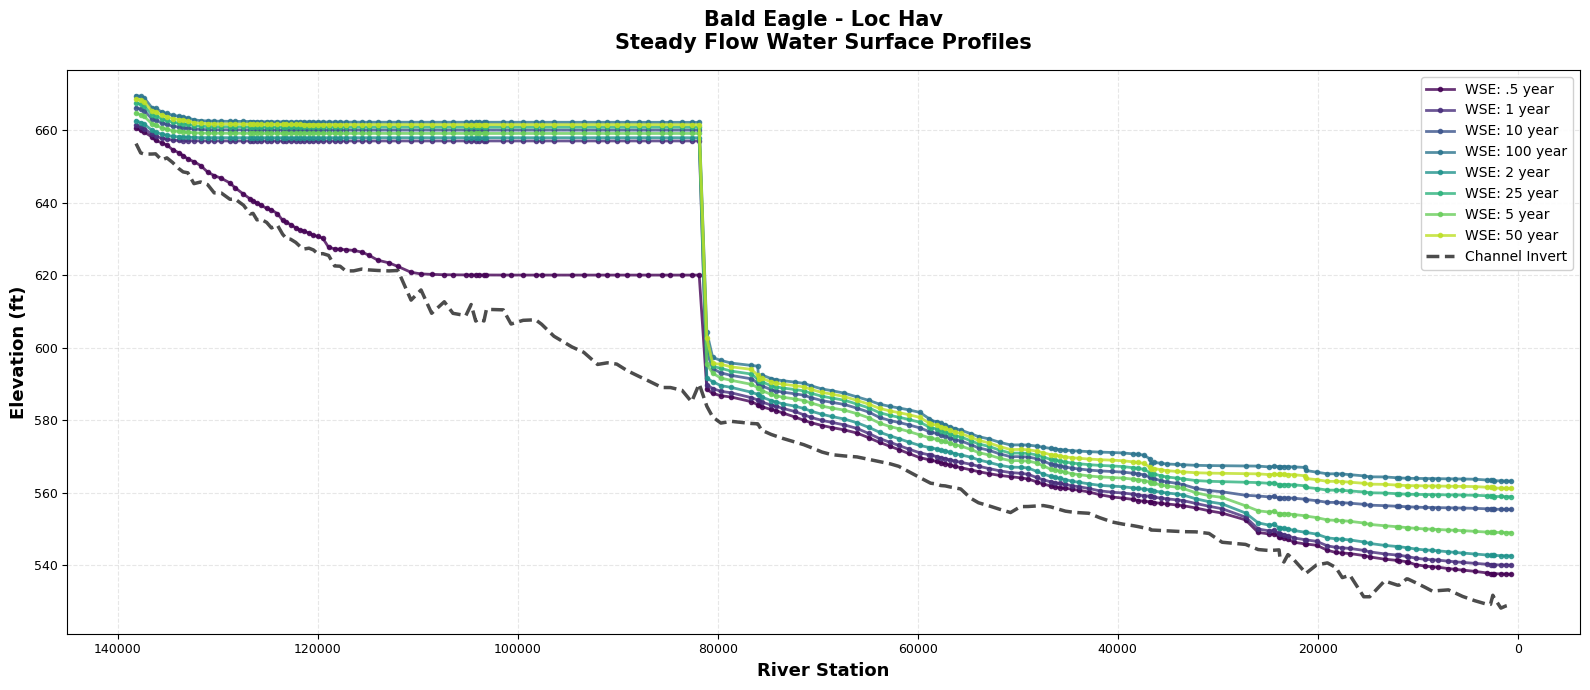

✓ Plotted 8 profiles for Bald Eagle - Loc Hav
  Station range: 659.9 to 138154.4



In [14]:
# ============================================================================
# STEADY FLOW: Longitudinal Profiles by River/Reach
# ============================================================================

# Convert node_id to float for proper sorting
df_steady['node_id'] = df_steady['node_id'].astype(float)

# Group by River/Reach and create separate plots
for (river, reach), group_df in df_steady.groupby(['river', 'reach']):
    
    # Sort by station (descending - upstream to downstream per HEC-RAS convention)
    group_df_sorted = group_df.sort_values('node_id', ascending=False)
    
    fig, ax = plt.subplots(figsize=(16, 7))
    
    # Get unique profiles and plot each one
    profiles = sorted(group_df['profile'].unique())
    colors = plt.cm.viridis(np.linspace(0, 0.9, len(profiles)))
    
    for idx, profile in enumerate(profiles):
        prof_data = group_df_sorted[group_df_sorted['profile'] == profile]
        ax.plot(prof_data['node_id'], prof_data['wsel'], 
                marker='o', markersize=3, linewidth=2, 
                color=colors[idx], label=f'WSE: {profile}', alpha=0.8)
    
    # Add channel invert (plot once, not for each profile)
    invert = group_df_sorted.drop_duplicates('node_id')[['node_id', 'min_ch_el']].sort_values('node_id', ascending=False)
    ax.plot(invert['node_id'], invert['min_ch_el'], 
            'k--', linewidth=2.5, alpha=0.7, label='Channel Invert')
    
    # Formatting
    ax.set_xlabel('River Station', fontsize=13, fontweight='bold')
    ax.set_ylabel('Elevation (ft)', fontsize=13, fontweight='bold')
    ax.set_title(f'{river} - {reach}\nSteady Flow Water Surface Profiles', 
                 fontsize=15, fontweight='bold', pad=15)
    ax.legend(loc='best', fontsize=10, framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.invert_xaxis()  # Upstream (larger stations) on left
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Plotted {len(profiles)} profiles for {river} - {reach}")
    print(f"  Station range: {group_df['node_id'].min():.1f} to {group_df['node_id'].max():.1f}\n")

In [15]:
# Export
Path("working").mkdir(exist_ok=True)
df_steady.to_csv("working/steady_plan02.csv", index=False)
print(f"Exported {len(df_steady)} rows to working/steady_plan02.csv")

Exported 1424 rows to working/steady_plan02.csv


# Part 2: Unsteady Time Series (Plan 01)

Extract unsteady results. **Note:** Methods automatically set Plan 01 as current!

In [16]:
# Run Plan 01 (auto-sets as current, waits for completion)
# This may take 5-10 minutes!
print("Running Plan 01 (Unsteady)...")
# success, msgs = RasControl.run_plan(new_plan)  >> Don't use this, it always sets cores to max
RasCmdr.compute_plan("01", clear_geompre=True, num_cores=2)  ## Use this instead, it's ras-commander's direct command line wrapper with extra arguments
   
print(f"Success: {success}")
print(f"Messages: {msgs}")

2025-11-17 14:05:55 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek


2025-11-17 14:05:55 - ras_commander.RasGeo - INFO - Clearing geometry preprocessor file for single plan: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p01


2025-11-17 14:05:55 - ras_commander.RasGeo - WARNING - No geometry preprocessor file found for: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p01


2025-11-17 14:05:55 - ras_commander.RasGeo - INFO - Geometry dataframe updated successfully.


2025-11-17 14:05:55 - ras_commander.RasCmdr - INFO - Cleared geometry preprocessor files for plan: 01


2025-11-17 14:05:55 - ras_commander.RasUtils - INFO - Using provided plan file path: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p01


2025-11-17 14:05:55 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p01


2025-11-17 14:05:55 - ras_commander.RasCmdr - INFO - Set number of cores to 2 for plan: 01


2025-11-17 14:05:55 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:


2025-11-17 14:05:55 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.prj" "C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p01"


Running Plan 01 (Unsteady)...


2025-11-17 14:07:31 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 01


2025-11-17 14:07:31 - ras_commander.RasCmdr - INFO - Total run time for plan 01: 96.51 seconds


Success: True
Messages: ['Starting Steady Computations', 'Computing', 'Computations Completed']


In [17]:
# Get output times (auto-sets Plan 01 as current)
times = RasControl.get_output_times("01")
print(f"Found {len(times)} timesteps")
print(f"First: {times[0]}")
print(f"Last: {times[-1]}")

2025-11-17 14:07:31 - ras_commander.RasControl - INFO - Opening HEC-RAS: RAS66.HECRASController (version: 6.6)


2025-11-17 14:07:32 - ras_commander.RasControl - INFO - Opening project: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.prj


2025-11-17 14:07:32 - ras_commander.RasControl - INFO - Detected ras.exe PID 385348 (confidence: 100/100)


2025-11-17 14:07:32 - ras_commander.RasControl - INFO - Executing operation...


2025-11-17 14:07:32 - ras_commander.RasControl - INFO - Setting current plan to: Unsteady with Bridges and Dam


2025-11-17 14:07:32 - ras_commander.RasControl - INFO - Found 76 output times


2025-11-17 14:07:32 - ras_commander.RasControl - INFO - Operation completed successfully


2025-11-17 14:07:32 - ras_commander.RasControl - INFO - Closing HEC-RAS...


2025-11-17 14:07:32 - ras_commander.RasControl - INFO - HEC-RAS closed via QuitRas()


2025-11-17 14:07:32 - ras_commander.RasControl - INFO - Terminating tracked ras.exe PID 385348


Found 76 timesteps
First: Max WS
Last: 24FEB1999 0400


### Extracting Computation Messages (Unsteady Flow)

Similarly, we can extract computation messages for the unsteady flow plan to review:
- Simulation timing and performance
- Convergence information
- Any warnings or errors encountered during computation

In [18]:
# Extract computation messages for unsteady flow Plan 01
print("="*80)
print("COMPUTATION MESSAGES - Plan 01 (Unsteady Flow)")
print("="*80)

msgs_unsteady = RasControl.get_comp_msgs("01")

if msgs_unsteady:
    print(f"\nExtracted {len(msgs_unsteady)} characters of computation messages\n")
    
    # Display first 800 characters
    print("Computation messages (first 800 characters):")
    print("-" * 80)
    print(msgs_unsteady[:800])
    
    if len(msgs_unsteady) > 800:
        print("\n... (truncated) ...")
    
    # Check for errors/warnings
    print("\n" + "="*80)
    print("Checking for warnings/errors...")
    print("="*80)
    
    lines = msgs_unsteady.split('\n')
    issues = [l for l in lines if 'error' in l.lower() or 'warning' in l.lower()]
    
    if issues:
        print(f"Found {len(issues)} warning/error lines:")
        for issue in issues[:5]:  # Show first 5
            print(f"  - {issue.strip()}")
    else:
        print("✓ No warnings or errors found")
else:
    print("No computation messages available for Plan 01")

print("\n" + "="*80)

2025-11-17 14:07:32 - ras_commander.RasControl - INFO - Reading computation messages from: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p01.comp_msgs.txt


2025-11-17 14:07:32 - ras_commander.RasControl - INFO - Read 1175 characters from comp_msgs file


COMPUTATION MESSAGES - Plan 01 (Unsteady Flow)

Extracted 1175 characters of computation messages

Computation messages (first 800 characters):
--------------------------------------------------------------------------------
User selected to use previously computed internal boundary data 
but the geometry preprocessor file was for the previous version.
All internal boundary data will be recomputed.

Simulation started at: 14Nov2012 01:29 PM

Writing geometry to output file
Completed writing geometry to output file


Writing plan information to output file
Completed writing plan information to output file


Geometric Preprocessor Version 4.2.0 Jan 2010 XXX XXXX

Finished Processing Geometry
GeomPreprocessor complete - Accepting the preprocessor files.

Performing Unsteady Flow Simulation  Version 4.2.0 Jan 2010 XXX XXXX

Maximum iterations of 20 at: 		RS	WSEL	ERROR
20FEB1999 12:44:00  Bald Eagle      	Loc Hav         	75917.82	  592.36	   0.012


Finished Unsteady Flow Simulation

Writi

In [19]:
# Extract unsteady (limit to 10 timesteps for demo)
df_unsteady = RasControl.get_unsteady_results("01")

print(f"Rows: {len(df_unsteady)}")
print(f"Timesteps: {df_unsteady['time_index'].nunique()}")
print(f"XS: {df_unsteady['node_id'].nunique()}")
df_unsteady.head(10)

2025-11-17 14:07:32 - ras_commander.RasControl - INFO - Opening HEC-RAS: RAS66.HECRASController (version: 6.6)


2025-11-17 14:07:32 - ras_commander.RasControl - INFO - Opening project: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.prj


2025-11-17 14:07:33 - ras_commander.RasControl - INFO - Detected ras.exe PID 384072 (confidence: 100/100)


2025-11-17 14:07:33 - ras_commander.RasControl - INFO - Executing operation...


2025-11-17 14:07:33 - ras_commander.RasControl - INFO - Setting current plan to: Unsteady with Bridges and Dam


2025-11-17 14:07:33 - ras_commander.RasControl - INFO - Extracting 76 time steps


2025-11-17 14:07:33 - ras_commander.RasControl - INFO - Found 1 rivers


2025-11-17 14:08:04 - ras_commander.RasControl - INFO - Extracted 13528 result rows


2025-11-17 14:08:04 - ras_commander.RasControl - INFO - Operation completed successfully


2025-11-17 14:08:04 - ras_commander.RasControl - INFO - Closing HEC-RAS...


2025-11-17 14:08:04 - ras_commander.RasControl - INFO - HEC-RAS closed via QuitRas()


2025-11-17 14:08:04 - ras_commander.RasControl - INFO - Terminating tracked ras.exe PID 384072


Rows: 13528
Timesteps: 76
XS: 178


river    reach   node_id  time_index     time_string  \
0  Bald Eagle  Loc Hav  138154.4           1          Max WS   
1  Bald Eagle  Loc Hav  138154.4           2  18FEB1999 0000   
2  Bald Eagle  Loc Hav  138154.4           3  18FEB1999 0200   
3  Bald Eagle  Loc Hav  138154.4           4  18FEB1999 0400   
4  Bald Eagle  Loc Hav  138154.4           5  18FEB1999 0600   
5  Bald Eagle  Loc Hav  138154.4           6  18FEB1999 0800   
6  Bald Eagle  Loc Hav  138154.4           7  18FEB1999 1000   
7  Bald Eagle  Loc Hav  138154.4           8  18FEB1999 1200   
8  Bald Eagle  Loc Hav  138154.4           9  18FEB1999 1400   
9  Bald Eagle  Loc Hav  138154.4          10  18FEB1999 1600   

             datetime        wsel   min_ch_el   velocity      flow    froude  \
0                 NaT  672.808289  656.299988  11.812529  7.167449  0.546461   
1 1999-02-18 00:00:00  660.651123  656.299988   3.564320  1.161268  0.352355   
2 1999-02-18 02:00:00  660.218872  656.299988   3.614365  1.002599  0.376157   
3 1999-02-18 04:00:00  661.313293  656.299988   3.882611  1.605426  0.361649   
4 1999-02-18 06:00:00  662.443420  656.299988   4.350002  2.118352  0.357496   
5 1999-02-18 08:00:00  663.560730  656.299988   4.943125  2.614835  0.367609   
6 1999-02-18 10:00:00  664.638428  656.299988   5.587611  3.109273  0.383870   
7 1999-02-18 12:00:00  665.657776  656.299988   6.254566  3.600435  0.403054   
8 1999-02-18 14:00:00  666.623291  656.299988   6.915609  4.074730  0.422223   
9 1999-02-18 16:00:00  667.523621  656.299988   7.587838  4.510049  0.440113   

       energy  max_depth  
0  674.472717  16.508301  
1  660.827637   4.351135  
2  660.407654   3.918884  
3  661.511597   5.013306  
4  662.681335   6.143433  
5  663.861633   7.260742  
6  665.019165   8.338440  
7  666.132507   9.357788  
8  667.202332  10.323303  
9  668.219055  11.223633

## Understanding "Max WS" in Unsteady Output

**Important:** HEC-RAS unsteady results include a special row with `time_string="Max WS"` (time_index=1). This contains the **maximum values that occurred at ANY computational timestep** during the entire simulation, not just at output intervals.

**Why this matters:**
- Output intervals (e.g., every 1 hour) may miss the peak flow/WSE
- Computational timesteps (e.g., every 30 seconds) capture the true maximum
- "Max WS" shows the absolute peak, even if it wasn't saved to an output interval

**How to use it:**
- Include in DataFrame for reference (critical data!)
- Filter out when plotting time series (it's not a timestep)
- Show as horizontal reference line on plots to indicate peak

The next cell demonstrates this pattern.

Creating time series plots for 9 cross sections:
  Stations: ['138154.4', '126454.1', '116401.3', '98206.9', '76643.4', '58836.2', '45233.9', '27226.4', '11865.8']



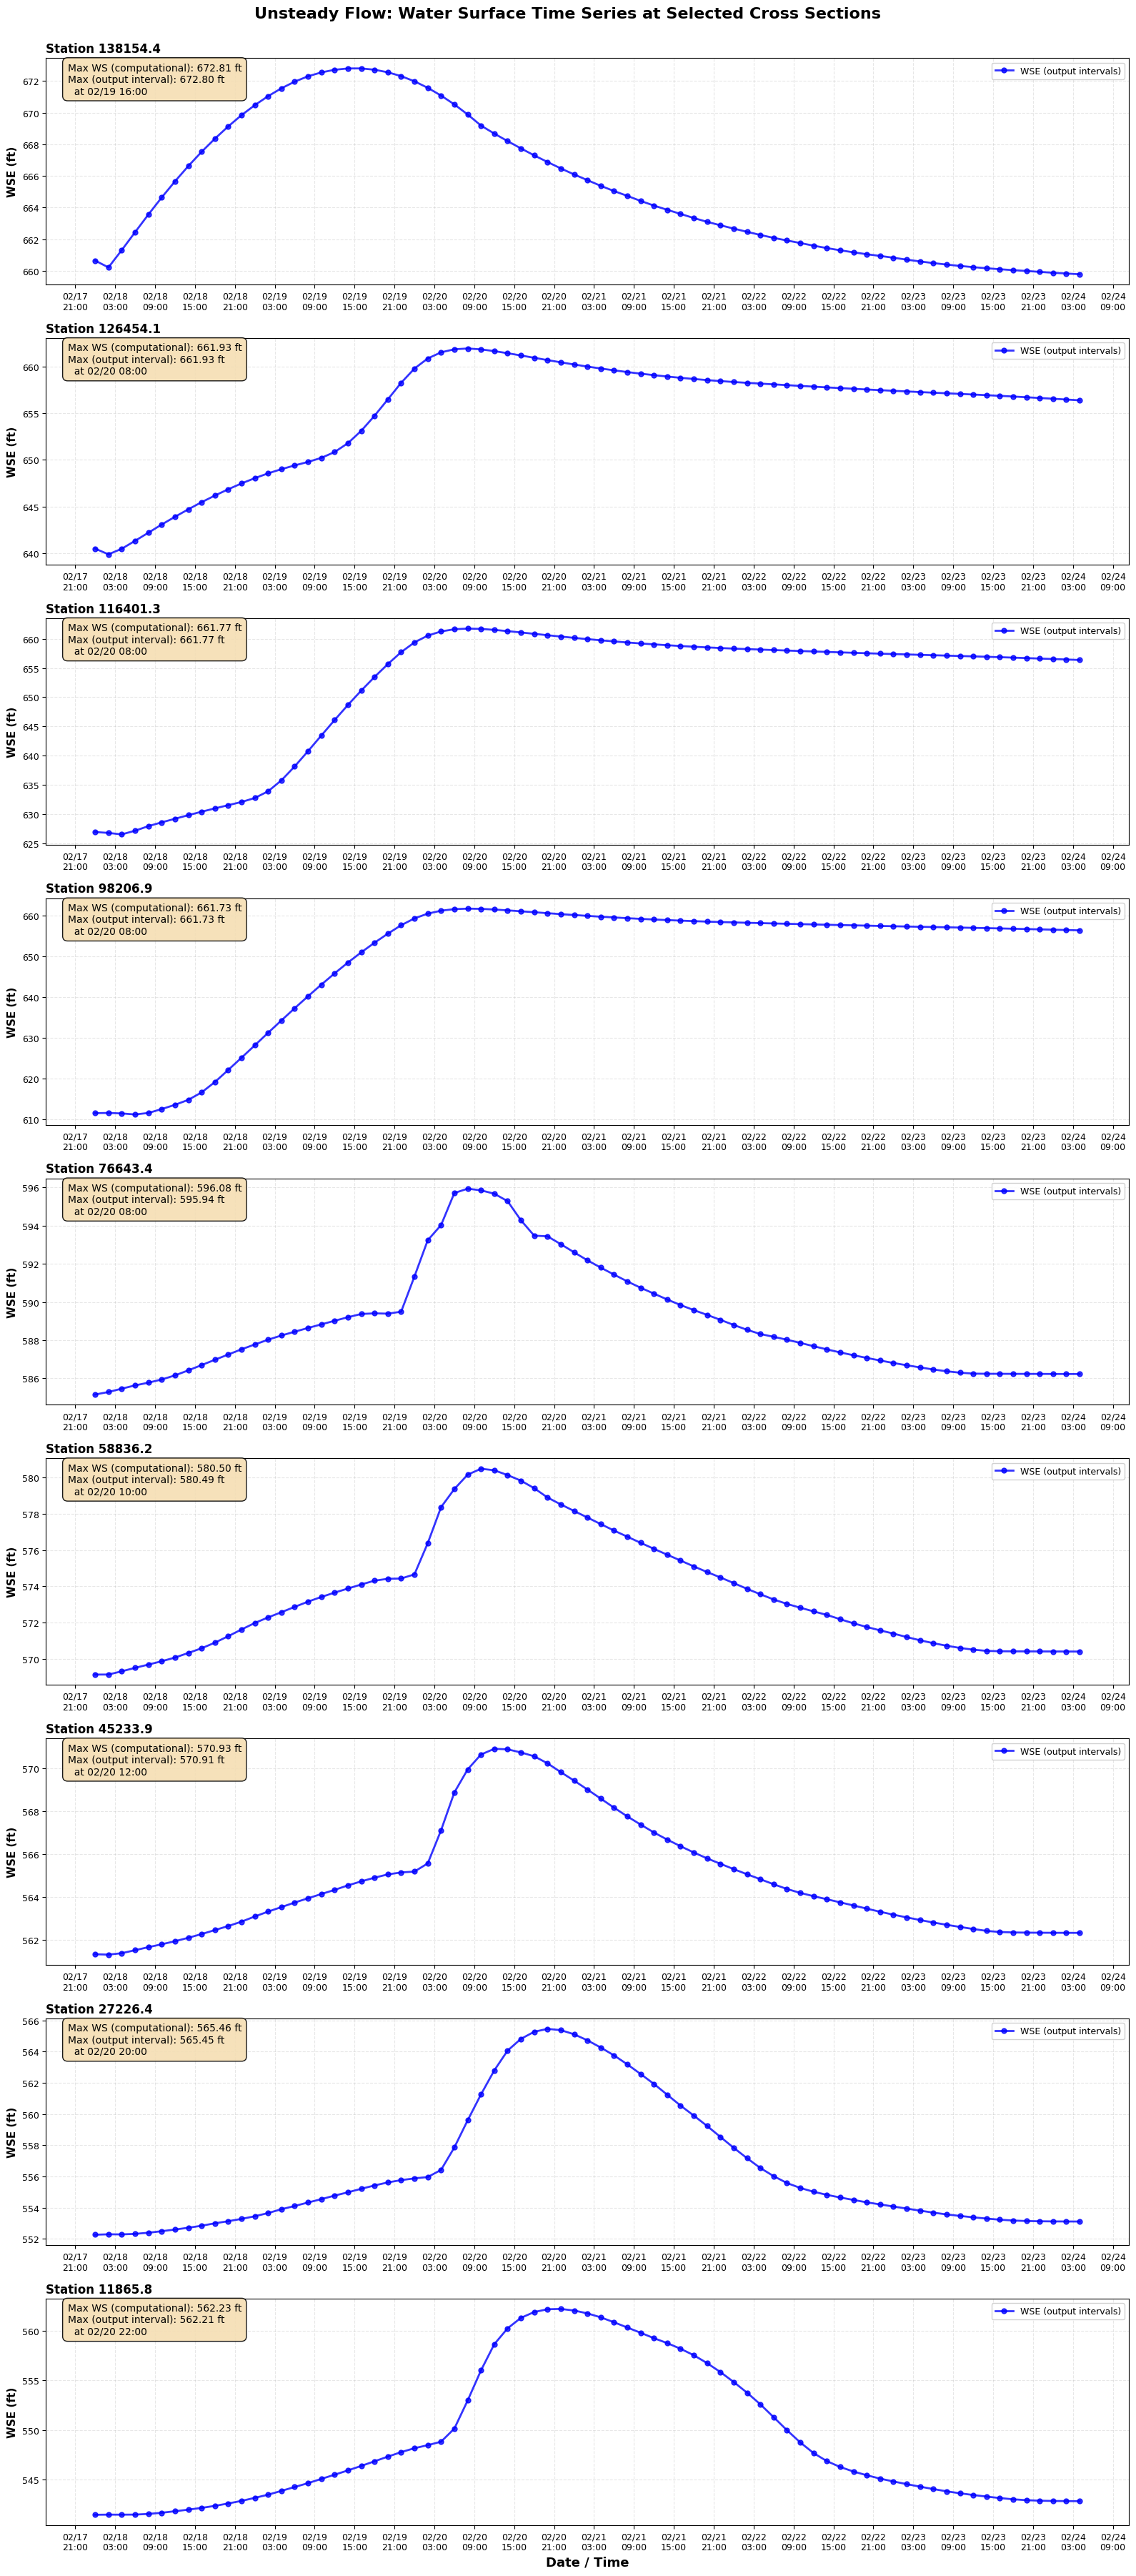


✓ Created time series plots for 9 stations


In [20]:
# ============================================================================
# UNSTEADY FLOW: Time Series at Multiple Cross Sections
# ============================================================================
# NOTE: This cell shows LEGACY manual datetime parsing for reference.
# For v0.81.0+, see the cell below for automatic datetime usage!
# ============================================================================

import matplotlib.dates as mdates
import numpy as np

# Convert node_id to float
df_unsteady['node_id'] = df_unsteady['node_id'].astype(float)

# Separate Max WS from timeseries data
df_maxws = df_unsteady[df_unsteady['time_string'] == 'Max WS'].copy()
df_timeseries = df_unsteady[df_unsteady['time_string'] != 'Max WS'].copy()

# LEGACY: Parse datetime for timeseries (NOT NEEDED in v0.81.0+ - datetime column auto-included!)
df_timeseries['datetime'] = pd.to_datetime(df_timeseries['time_string'], 
                                           format='%d%b%Y %H%M', errors='coerce')

# Select cross sections to plot (every 20th station for manageable plot count)
all_xs = sorted(df_timeseries['node_id'].unique(), reverse=True)  # Upstream to downstream
selected_xs = all_xs[::20]  # Adjust step size as needed (20, 30, etc.)

if len(selected_xs) == 0:
    selected_xs = [all_xs[0]]  # At least plot one

print(f"Creating time series plots for {len(selected_xs)} cross sections:")
print(f"  Stations: {[f'{xs:.1f}' for xs in selected_xs]}\n")

# Create subplots - one per cross section
n_xs = len(selected_xs)
fig, axes = plt.subplots(n_xs, 1, figsize=(16, 4*n_xs))
if n_xs == 1:
    axes = [axes]

for idx, xs in enumerate(selected_xs):
    ax = axes[idx]
    
    # Get data for this cross section
    xs_data = df_timeseries[df_timeseries['node_id'] == xs].sort_values('datetime')
    maxws_data = df_maxws[df_maxws['node_id'] == xs]
    
    if len(xs_data) == 0:
        ax.text(0.5, 0.5, f'No data for station {xs:.1f}', 
                ha='center', va='center', transform=ax.transAxes)
        continue
    
    # Plot WSE time series
    ax.plot(xs_data['datetime'], xs_data['wsel'], 
            'b-o', linewidth=2, markersize=5, label='WSE (output intervals)', 
            alpha=0.8)
    
    # Get max values
    max_ws_value = maxws_data['wsel'].iloc[0] if len(maxws_data) > 0 else None
    max_output_value = xs_data['wsel'].max()
    max_output_time = xs_data.loc[xs_data['wsel'].idxmax(), 'datetime']
    
    # Add horizontal line for computational Max WS
    #if max_ws_value:
    #    ax.axhline(max_ws_value, color='r', linestyle='--', 
    #               linewidth=2, alpha=0.7, label='Max WS (computational)')
    
    # Create annotation text box
    annotation_lines = [
        f"Max WS (computational): {max_ws_value:.2f} ft" if max_ws_value else "Max WS: N/A",
        f"Max (output interval): {max_output_value:.2f} ft",
        f"  at {max_output_time.strftime('%m/%d %H:%M')}" if pd.notna(max_output_time) else ""
    ]
    annotation_text = '\n'.join(annotation_lines)
    
    ax.text(0.02, 0.98, annotation_text, 
            transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9, pad=0.5))
    
    # Formatting
    ax.set_ylabel('WSE (ft)', fontsize=11, fontweight='bold')
    ax.set_title(f'Station {xs:.1f}', fontsize=12, fontweight='bold', loc='left')
    ax.legend(loc='upper right', fontsize=9, framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Format x-axis for dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))  # Adjust interval as needed
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, ha='center', fontsize=9)

# Add common x-label to bottom subplot
axes[-1].set_xlabel('Date / Time', fontsize=13, fontweight='bold')

plt.suptitle('Unsteady Flow: Water Surface Time Series at Selected Cross Sections',
             fontsize=16, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()

print(f"\n✓ Created time series plots for {len(selected_xs)} stations")

## NEW in v0.81.0: Automatic Datetime Parsing

Starting in version 0.81.0, `get_unsteady_results()` automatically includes a `datetime` column with proper datetime64[ns] objects. **Manual parsing is no longer needed!**

**Key Improvements:**
- ✅ `datetime` column added automatically
- ✅ Already in datetime64[ns] format (not strings)
- ✅ "Max WS" rows have `pd.NaT` for clean filtering
- ✅ Immediate compatibility with pandas datetime operations
- ✅ Backward compatible - `time_string` still included

The cell above shows the old manual parsing method (kept for reference). The next cell demonstrates the modern approach using the automatic `datetime` column.

In [21]:
# ============================================================================
# MODERN APPROACH: Using Automatic datetime Column (v0.81.0+)
# ============================================================================

# Check that datetime column exists and is already parsed
print("DataFrame columns:")
print(df_unsteady.columns.tolist())
print(f"\ndatetime column type: {df_unsteady['datetime'].dtype}")
print(f"Sample datetime values:")
print(df_unsteady[['time_string', 'datetime']].head(10))

# Separate using datetime column (NaT for Max WS rows)
df_maxws_modern = df_unsteady[df_unsteady['datetime'].isna()].copy()
df_timeseries_modern = df_unsteady[df_unsteady['datetime'].notna()].copy()

print(f"\nMax WS rows: {len(df_maxws_modern)}")
print(f"Timeseries rows: {len(df_timeseries_modern)}")

# Use pandas datetime accessors directly - no manual parsing needed!
print("\nDatetime operations (no parsing required!):")
print(f"  Simulation start: {df_timeseries_modern['datetime'].min()}")
print(f"  Simulation end: {df_timeseries_modern['datetime'].max()}")
print(f"  Duration: {df_timeseries_modern['datetime'].max() - df_timeseries_modern['datetime'].min()}")
print(f"  Unique hours: {df_timeseries_modern['datetime'].dt.hour.unique()[:10]}")

# Time-based filtering (modern approach)
# Example: Get data for a specific date
specific_date = pd.Timestamp('1999-02-19')
feb_19_data = df_timeseries_modern[df_timeseries_modern['datetime'].dt.date == specific_date.date()]
print(f"\nData points on {specific_date.date()}: {len(feb_19_data)}")

# Example: Get data for specific time range
start_time = pd.Timestamp('1999-02-18 12:00:00')
end_time = pd.Timestamp('1999-02-20 12:00:00')
time_range_data = df_timeseries_modern[
    (df_timeseries_modern['datetime'] >= start_time) & 
    (df_timeseries_modern['datetime'] <= end_time)
]
print(f"Data points between {start_time} and {end_time}: {len(time_range_data)}")

print("\n✓ Modern datetime functionality demonstrated")

DataFrame columns:
['river', 'reach', 'node_id', 'time_index', 'time_string', 'datetime', 'wsel', 'min_ch_el', 'velocity', 'flow', 'froude', 'energy', 'max_depth']

datetime column type: datetime64[ns]
Sample datetime values:
      time_string            datetime
0          Max WS                 NaT
1  18FEB1999 0000 1999-02-18 00:00:00
2  18FEB1999 0200 1999-02-18 02:00:00
3  18FEB1999 0400 1999-02-18 04:00:00
4  18FEB1999 0600 1999-02-18 06:00:00
5  18FEB1999 0800 1999-02-18 08:00:00
6  18FEB1999 1000 1999-02-18 10:00:00
7  18FEB1999 1200 1999-02-18 12:00:00
8  18FEB1999 1400 1999-02-18 14:00:00
9  18FEB1999 1600 1999-02-18 16:00:00

Max WS rows: 178
Timeseries rows: 13350

Datetime operations (no parsing required!):
  Simulation start: 1999-02-18 00:00:00
  Simulation end: 1999-02-24 04:00:00
  Duration: 6 days 04:00:00
  Unique hours: [ 0  2  4  6  8 10 12 14 16 18]

Data points on 1999-02-19: 2136
Data points between 1999-02-18 12:00:00 and 1999-02-20 12:00:00: 4450

✓ Modern dat

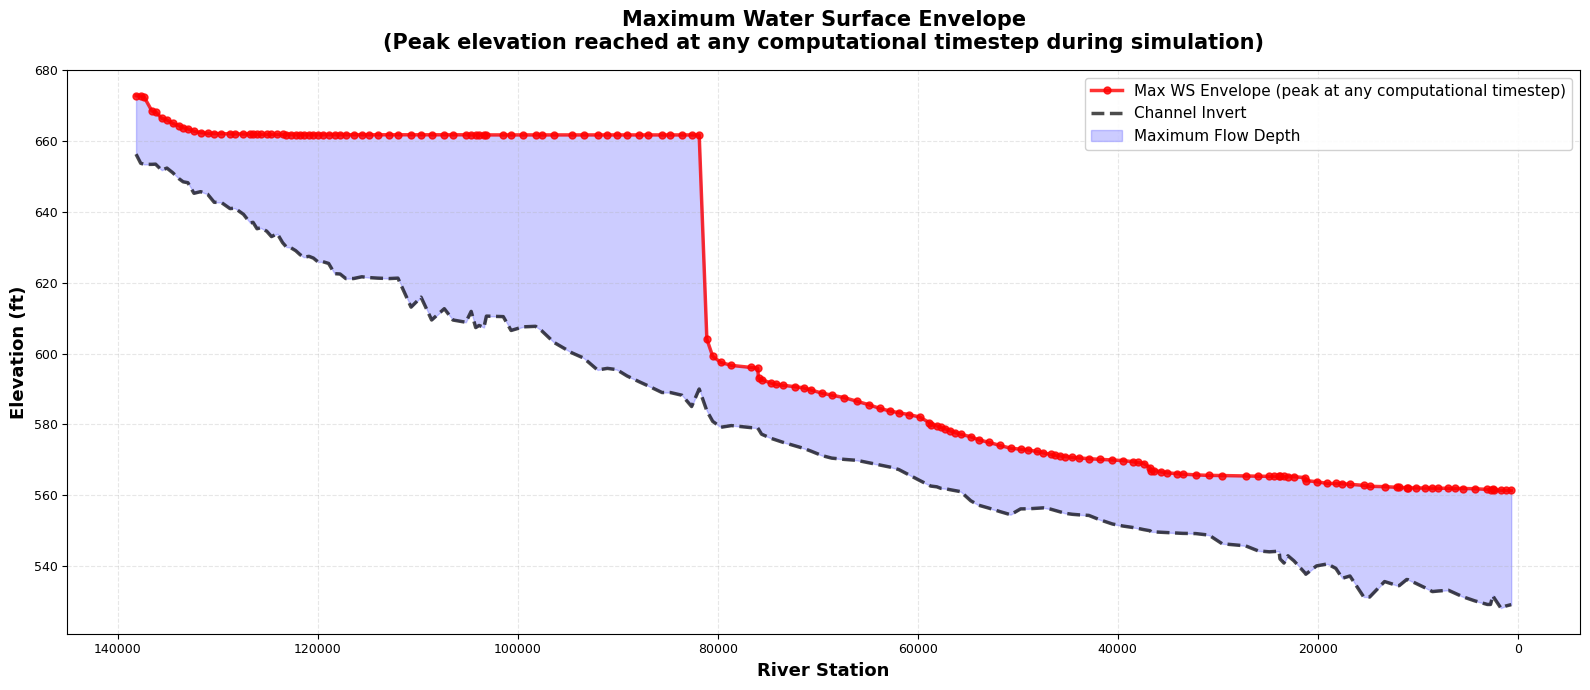


✓ Maximum Water Surface Envelope
  Max depth: 76.66 ft at station 82607.9
  Highest WSE: 672.81 ft at station 138154.4


In [22]:
# ============================================================================
# UNSTEADY FLOW: Maximum Water Surface Envelope
# ============================================================================

# Sort by station for profile view
max_wse_sorted = df_maxws.sort_values('node_id', ascending=False)

fig, ax = plt.subplots(figsize=(16, 7))

# Plot maximum WSE envelope
ax.plot(max_wse_sorted['node_id'], max_wse_sorted['wsel'],
        'r-o', linewidth=2.5, markersize=5, 
        label='Max WS Envelope (peak at any computational timestep)', 
        alpha=0.8)

# Add channel invert
invert = max_wse_sorted[['node_id', 'min_ch_el']].drop_duplicates('node_id').sort_values('node_id', ascending=False)
ax.plot(invert['node_id'], invert['min_ch_el'],
        'k--', linewidth=2.5, alpha=0.7, label='Channel Invert')

# Fill between for visual clarity
ax.fill_between(max_wse_sorted['node_id'], 
                max_wse_sorted['min_ch_el'], 
                max_wse_sorted['wsel'],
                alpha=0.2, color='blue', label='Maximum Flow Depth')

# Formatting
ax.set_xlabel('River Station', fontsize=13, fontweight='bold')
ax.set_ylabel('Elevation (ft)', fontsize=13, fontweight='bold')
ax.set_title('Maximum Water Surface Envelope\n(Peak elevation reached at any computational timestep during simulation)',
             fontsize=15, fontweight='bold', pad=15)
ax.legend(fontsize=11, loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')
ax.invert_xaxis()  # Upstream on left

plt.tight_layout()
plt.show()

# Print summary statistics
max_depth = (max_wse_sorted['wsel'] - max_wse_sorted['min_ch_el']).max()
max_depth_station = max_wse_sorted.loc[(max_wse_sorted['wsel'] - max_wse_sorted['min_ch_el']).idxmax(), 'node_id']

print(f"\n✓ Maximum Water Surface Envelope")
print(f"  Max depth: {max_depth:.2f} ft at station {max_depth_station:.1f}")
print(f"  Highest WSE: {max_wse_sorted['wsel'].max():.2f} ft at station {max_wse_sorted.loc[max_wse_sorted['wsel'].idxmax(), 'node_id']:.1f}")


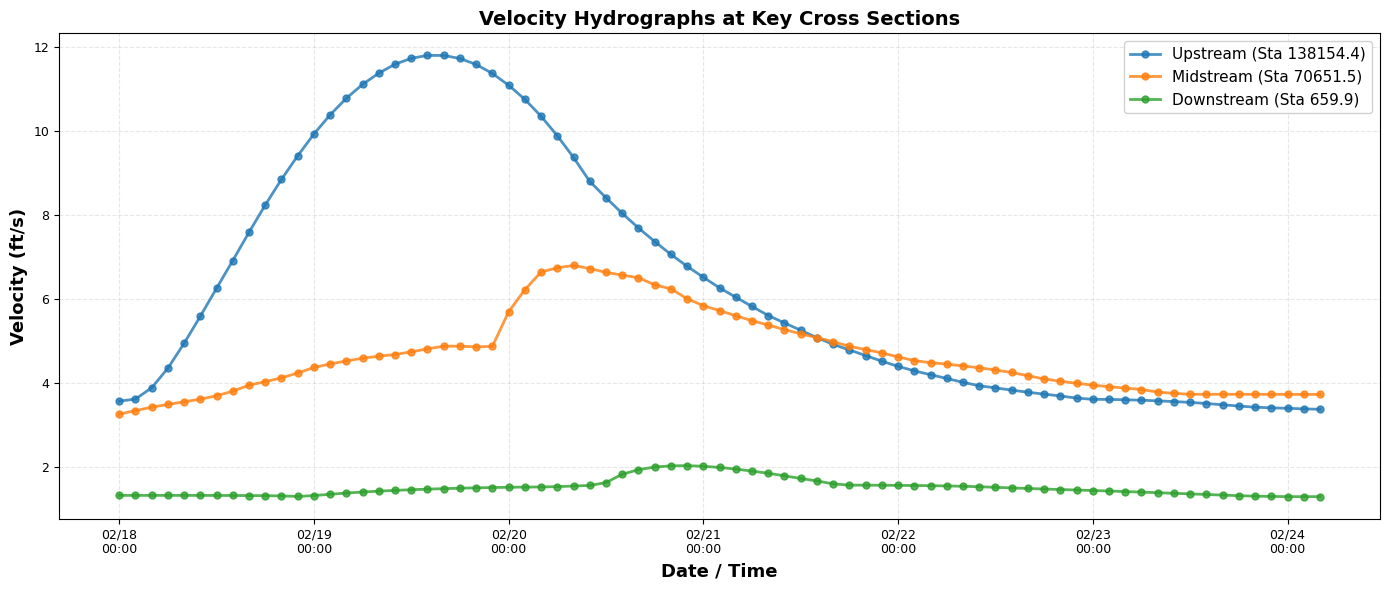


✓ Created velocity hydrographs for 3 key locations


In [23]:
# ============================================================================
# UNSTEADY FLOW: Velocity Hydrographs at Key Locations
# ============================================================================

# Select critical stations (upstream, middle, downstream)
all_stations = sorted(df_timeseries['node_id'].unique(), reverse=True)
n_stations = len(all_stations)

if n_stations >= 3:
    critical_xs = [
        all_stations[0],                    # Upstream
        all_stations[n_stations // 2],      # Middle
        all_stations[-1]                    # Downstream
    ]
    labels = ['Upstream', 'Midstream', 'Downstream']
else:
    critical_xs = all_stations
    labels = [f'Station {i+1}' for i in range(len(critical_xs))]

fig, ax = plt.subplots(figsize=(14, 6))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Plot velocity hydrographs
for idx, (xs, label) in enumerate(zip(critical_xs, labels)):
    xs_data = df_timeseries[df_timeseries['node_id'] == xs].sort_values('datetime')
    ax.plot(xs_data['datetime'], xs_data['velocity'],
            marker='o', linewidth=2, markersize=5,
            color=colors[idx % len(colors)],
            label=f'{label} (Sta {xs:.1f})', alpha=0.8)

ax.set_xlabel('Date / Time', fontsize=13, fontweight='bold')
ax.set_ylabel('Velocity (ft/s)', fontsize=13, fontweight='bold')
ax.set_title('Velocity Hydrographs at Key Cross Sections', 
              fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n%H:%M'))

plt.tight_layout()
plt.show()

print(f"\n✓ Created velocity hydrographs for {len(critical_xs)} key locations")

# Summary

## Complete RasControl API

```python
# Initialize with version (flexible formats)
init_ras_project(path, "4.1")  # or "41", "66", "5.0.6", "506", etc.

# Run plans (auto-sets as current, waits for completion)
# NOTE: run_plan() now checks if plan is current before running
# If results are up-to-date, it skips computation (faster workflow)
success, msgs = RasControl.run_plan("02")

# To force recomputation regardless of current status:
success, msgs = RasControl.run_plan("02", force_recompute=True)

# Extract steady (auto-sets as current)
df_steady = RasControl.get_steady_results("02")

# Extract unsteady (auto-sets as current, includes Max WS)
df_unsteady = RasControl.get_unsteady_results("01")

# Filter for time series plotting
df_timeseries = df_unsteady[df_unsteady['time_string'] != 'Max WS']
max_wse = df_unsteady[df_unsteady['time_string'] == 'Max WS']['wsel'].iloc[0]
```

## Key Features

- ✅ Plan numbers (not file paths)
- ✅ Auto-sets current plan
- ✅ Blocks until completion
- ✅ Steady AND unsteady
- ✅ All versions 3.0-6.7
- ✅ Flexible version formats
- ✅ Includes Max WS data
- ✅ Multi-version comparison (optional)

## What Was Demonstrated

1. **Steady workflow** - Plan 02 extraction and plotting
2. **Unsteady workflow** - Plan 01 time series with Max WS reference
3. **Max WS handling** - Understanding and visualizing peak values
4. **Multi-version comparison** - Optional cells for version validation

## Next Steps

- Apply to your legacy HEC-RAS models
- Run multi-version comparison for migration validation
- For HEC-RAS 6.0+: Use HDF methods for better performance
  - `19_steady_flow_analysis.ipynb`
  - `10_1d_hdf_data_extraction.ipynb`

### What This Creates

Running the multi-version comparison cells will:

**New Plans in Project:**
- `02_41`, `02_506`, `02_63`, `02_66` (steady)
- `01_41`, `01_506`, `01_63`, `01_66` (unsteady)

**CSV Files in working/:**
- `steady_v41.csv`, `steady_v506.csv`, `steady_v63.csv`, `steady_v66.csv`
- `unsteady_v41.csv`, `unsteady_v506.csv`, `unsteady_v63.csv`, `unsteady_v66.csv`

**Results:**
- All plans remain in project for further analysis
- CSV files for external comparison
- Plots showing version differences

In [24]:
# OPTIONAL: Multi-version unsteady comparison
# Uncomment to run (may take 1-2 Hr)

from ras_commander import RasPlan

# Step 1: Update Plan 01 output intervals for more detail
print("Step 1: Updating Plan 01 intervals...")
init_ras_project(project_path, "6.6")  # Use latest for modification

# Update intervals: Output=15MIN, Mapping=15MIN
RasPlan.update_plan_intervals("01", 
                              output_interval="10MIN",
                              mapping_interval="10MIN")
print("  ✓ Output Interval: 1HOUR → 6MIN")
print("  ✓ Mapping Interval: 1HOUR → 6MIN\n")

# Step 2: Run across versions
# All versions with actual COM interfaces
test_versions = [
    ("4.1", "41"),       # HEC-RAS 4.1     → RAS41.HECRASController
#    ("5.0.1", "501"),    # HEC-RAS 5.0.1   → RAS501.HECRASController  >> FREEZES, SKIP, LIKELY ISSUE WITH HECRASCONTROLLER
#    ("5.0.3", "503"),    # HEC-RAS 5.0.3   → RAS503.HECRASController
    ("5.0.4", "504"),    # HEC-RAS 5.0.4   → RAS504.HECRASController
    ("5.0.6", "506"),    # HEC-RAS 5.0.6   → RAS506.HECRASController
    ("6.3.1", "631"),    # HEC-RAS 6.3.1   → RAS631.HECRASController
    ("6.6", "66"),       # HEC-RAS 6.6     → RAS66.HECRASController
]

unsteady_results = {}
max_ws_data = {}  # Store Max WS separately

print("=== MULTI-VERSION UNSTEADY COMPARISON ===\n")

for version_name, version_code in test_versions:
    print(f"Processing HEC-RAS {version_name}...")
    
    # Clone Plan 01 for this version
    new_plan = RasPlan.clone_plan("01",
                      new_shortid=f"Unsteady_{version_code}",
                      new_title=f"Unsteady - v{version_name}")
    print(f"  Cloned to Plan {new_plan}")
    
    # Re-initialize with this version
    init_ras_project(project_path, version_name)
    
    # Run the plan (this will take several minutes!)
    print(f"  Running Plan {new_plan} (may take 5-10 min)...")
    # NOTE: Using force_recompute=True for fresh cloned plans to ensure computation
    # (Default behavior now checks if plan is current and skips if already computed)
    #success, msgs = RasControl.run_plan(new_plan, force_recompute=True)
    success, msgs = RasControl.run_plan(new_plan, force_recompute=True)
    print(success, msgs)
    if success:
        # Extract results (limit to 20 timesteps for comparison)
        df = RasControl.get_unsteady_results(new_plan)
        
        # Separate Max WS from timeseries
        max_ws_data[version_name] = df[df['time_string'] == 'Max WS'].copy()
        unsteady_results[version_name] = df[df['time_string'] != 'Max WS'].copy()
        
        # Save CSV
        csv_path = Path(f"working/unsteady_v{version_code}.csv")
        df.to_csv(csv_path, index=False)
        print(f"  ✓ Extracted {len(df)} rows -> {csv_path}")
    else:
        print(f"  ✗ Failed")
    
    print()


2025-11-17 14:08:06 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.rasmap


2025-11-17 14:08:06 - ras_commander.RasPlan - INFO - Successfully updated intervals in plan file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p01


2025-11-17 14:08:06 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p01 to C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p03


2025-11-17 14:08:06 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p03


2025-11-17 14:08:06 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 03


Step 1: Updating Plan 01 intervals...
  ✓ Output Interval: 1HOUR → 6MIN
  ✓ Mapping Interval: 1HOUR → 6MIN

=== MULTI-VERSION UNSTEADY COMPARISON ===

Processing HEC-RAS 4.1...


2025-11-17 14:08:06 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.rasmap


2025-11-17 14:08:06 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.rasmap


2025-11-17 14:08:06 - ras_commander.RasControl - INFO - Opening HEC-RAS: RAS41.HECRASController (version: 4.1)


  Cloned to Plan 03
  Running Plan 03 (may take 5-10 min)...


2025-11-17 14:08:16 - ras_commander.RasControl - INFO - Opening project: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.prj


2025-11-17 14:08:17 - ras_commander.RasControl - INFO - Detected ras.exe PID 385496 (confidence: 70/100)


2025-11-17 14:08:17 - ras_commander.RasControl - INFO - Executing operation...


2025-11-17 14:08:17 - ras_commander.RasControl - INFO - Setting current plan to: Unsteady - v4.1


2025-11-17 14:08:17 - ras_commander.RasControl - INFO - Starting computation...


2025-11-17 14:10:08 - ras_commander.RasControl - INFO - Spawned watchdog process PID 381852 (monitoring PID 385496)


2025-11-17 14:10:08 - ras_commander.RasControl - INFO - Waiting for computation to complete...


2025-11-17 14:10:08 - ras_commander.RasControl - ERROR - Error checking completion status: RAS41.HECRASController.Compute_Complete


2025-11-17 14:10:08 - ras_commander.RasControl - INFO - Operation completed successfully


2025-11-17 14:10:08 - ras_commander.RasControl - INFO - Closing HEC-RAS...


2025-11-17 14:10:08 - ras_commander.RasControl - WARNING - QuitRas() failed: RAS41.HECRASController.QuitRas


2025-11-17 14:10:08 - ras_commander.RasControl - INFO - Terminating tracked ras.exe PID 385496


2025-11-17 14:10:08 - ras_commander.RasControl - INFO - Opening HEC-RAS: RAS41.HECRASController (version: 4.1)


2025-11-17 14:10:08 - ras_commander.RasControl - INFO - Opening project: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.prj


True ['Starting Unsteady Computations', 'Computing', 'Computations Completed']


2025-11-17 14:10:08 - ras_commander.RasControl - INFO - Detected ras.exe PID 382384 (confidence: 100/100)


2025-11-17 14:10:08 - ras_commander.RasControl - INFO - Executing operation...


2025-11-17 14:10:08 - ras_commander.RasControl - INFO - Setting current plan to: Unsteady - v4.1


2025-11-17 14:10:08 - ras_commander.RasControl - INFO - Extracting 76 time steps


2025-11-17 14:10:08 - ras_commander.RasControl - INFO - Found 1 rivers


2025-11-17 14:10:40 - ras_commander.RasControl - INFO - Extracted 13528 result rows


2025-11-17 14:10:40 - ras_commander.RasControl - INFO - Operation completed successfully


2025-11-17 14:10:40 - ras_commander.RasControl - INFO - Closing HEC-RAS...


2025-11-17 14:10:40 - ras_commander.RasControl - WARNING - QuitRas() failed: RAS41.HECRASController.QuitRas


2025-11-17 14:10:40 - ras_commander.RasControl - INFO - Terminating tracked ras.exe PID 382384


2025-11-17 14:10:40 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p01 to C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p04


2025-11-17 14:10:40 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p04


2025-11-17 14:10:40 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 04


2025-11-17 14:10:40 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.rasmap


2025-11-17 14:10:40 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.rasmap


  ✓ Extracted 13528 rows -> working\unsteady_v41.csv

Processing HEC-RAS 5.0.4...
  Cloned to Plan 04
  Running Plan 04 (may take 5-10 min)...


2025-11-17 14:10:40 - ras_commander.RasControl - INFO - Opening HEC-RAS: RAS504.HECRASController (version: 5.0.4)


2025-11-17 14:10:41 - ras_commander.RasControl - INFO - Opening project: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.prj


2025-11-17 14:10:42 - ras_commander.RasControl - INFO - Detected ras.exe PID 383988 (confidence: 100/100)


2025-11-17 14:10:42 - ras_commander.RasControl - INFO - Executing operation...


2025-11-17 14:10:42 - ras_commander.RasControl - INFO - Setting current plan to: Unsteady - v5.0.4


2025-11-17 14:10:42 - ras_commander.RasControl - INFO - Starting computation...


2025-11-17 14:12:19 - ras_commander.RasControl - INFO - Spawned watchdog process PID 385584 (monitoring PID 383988)


2025-11-17 14:12:19 - ras_commander.RasControl - INFO - Waiting for computation to complete...


2025-11-17 14:12:19 - ras_commander.RasControl - INFO - Computation completed (polled 0 times)


2025-11-17 14:12:19 - ras_commander.RasControl - INFO - Operation completed successfully


2025-11-17 14:12:19 - ras_commander.RasControl - INFO - Closing HEC-RAS...


2025-11-17 14:12:19 - ras_commander.RasControl - INFO - HEC-RAS closed via QuitRas()


2025-11-17 14:12:19 - ras_commander.RasControl - INFO - Terminating tracked ras.exe PID 383988


2025-11-17 14:12:19 - ras_commander.RasControl - INFO - Opening HEC-RAS: RAS504.HECRASController (version: 5.0.4)


2025-11-17 14:12:19 - ras_commander.RasControl - INFO - Opening project: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.prj


True ['Starting Unsteady Computations', 'Computing', 'Computations Completed']


2025-11-17 14:12:20 - ras_commander.RasControl - INFO - Detected ras.exe PID 384840 (confidence: 100/100)


2025-11-17 14:12:20 - ras_commander.RasControl - INFO - Executing operation...


2025-11-17 14:12:20 - ras_commander.RasControl - INFO - Setting current plan to: Unsteady - v5.0.4


2025-11-17 14:12:20 - ras_commander.RasControl - INFO - Extracting 76 time steps


2025-11-17 14:12:20 - ras_commander.RasControl - INFO - Found 1 rivers


2025-11-17 14:12:49 - ras_commander.RasControl - INFO - Extracted 13528 result rows


2025-11-17 14:12:49 - ras_commander.RasControl - INFO - Operation completed successfully


2025-11-17 14:12:49 - ras_commander.RasControl - INFO - Closing HEC-RAS...


2025-11-17 14:12:49 - ras_commander.RasControl - INFO - HEC-RAS closed via QuitRas()


2025-11-17 14:12:49 - ras_commander.RasControl - INFO - Terminating tracked ras.exe PID 384840


2025-11-17 14:12:49 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p01 to C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p05


2025-11-17 14:12:49 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p05


2025-11-17 14:12:49 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 05


2025-11-17 14:12:49 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.rasmap


2025-11-17 14:12:49 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.rasmap


2025-11-17 14:12:49 - ras_commander.RasControl - INFO - Opening HEC-RAS: RAS506.HECRASController (version: 5.0.6)


  ✓ Extracted 13528 rows -> working\unsteady_v504.csv

Processing HEC-RAS 5.0.6...
  Cloned to Plan 05
  Running Plan 05 (may take 5-10 min)...


2025-11-17 14:12:50 - ras_commander.RasControl - INFO - Opening project: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.prj


2025-11-17 14:12:50 - ras_commander.RasControl - INFO - Detected ras.exe PID 385288 (confidence: 100/100)


2025-11-17 14:12:50 - ras_commander.RasControl - INFO - Executing operation...


2025-11-17 14:12:50 - ras_commander.RasControl - INFO - Setting current plan to: Unsteady - v5.0.6


2025-11-17 14:12:50 - ras_commander.RasControl - INFO - Starting computation...


2025-11-17 14:13:05 - ras_commander.RasControl - INFO - Spawned watchdog process PID 378072 (monitoring PID 385288)


2025-11-17 14:13:05 - ras_commander.RasControl - INFO - Waiting for computation to complete...


2025-11-17 14:13:05 - ras_commander.RasControl - INFO - Computation completed (polled 0 times)


2025-11-17 14:13:05 - ras_commander.RasControl - INFO - Operation completed successfully


2025-11-17 14:13:05 - ras_commander.RasControl - INFO - Closing HEC-RAS...


2025-11-17 14:13:05 - ras_commander.RasControl - INFO - HEC-RAS closed via QuitRas()


2025-11-17 14:13:05 - ras_commander.RasControl - INFO - Terminating tracked ras.exe PID 385288


2025-11-17 14:13:05 - ras_commander.RasControl - INFO - Opening HEC-RAS: RAS506.HECRASController (version: 5.0.6)


2025-11-17 14:13:05 - ras_commander.RasControl - INFO - Opening project: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.prj


True ['Starting Unsteady Computations', 'Computing', 'Computations Completed']


2025-11-17 14:13:06 - ras_commander.RasControl - INFO - Detected ras.exe PID 382048 (confidence: 100/100)


2025-11-17 14:13:06 - ras_commander.RasControl - INFO - Executing operation...


2025-11-17 14:13:06 - ras_commander.RasControl - INFO - Setting current plan to: Unsteady - v5.0.6


2025-11-17 14:13:06 - ras_commander.RasControl - INFO - Extracting 76 time steps


2025-11-17 14:13:06 - ras_commander.RasControl - INFO - Found 1 rivers


2025-11-17 14:13:34 - ras_commander.RasControl - INFO - Extracted 13528 result rows


2025-11-17 14:13:34 - ras_commander.RasControl - INFO - Operation completed successfully


2025-11-17 14:13:34 - ras_commander.RasControl - INFO - Closing HEC-RAS...


2025-11-17 14:13:34 - ras_commander.RasControl - INFO - HEC-RAS closed via QuitRas()


2025-11-17 14:13:34 - ras_commander.RasControl - INFO - Terminating tracked ras.exe PID 382048


2025-11-17 14:13:34 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p01 to C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p06


2025-11-17 14:13:34 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p06


2025-11-17 14:13:34 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 06


2025-11-17 14:13:34 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.rasmap


2025-11-17 14:13:34 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.rasmap


2025-11-17 14:13:34 - ras_commander.RasControl - INFO - Opening HEC-RAS: RAS631.HECRASController (version: 6.3.1)


  ✓ Extracted 13528 rows -> working\unsteady_v506.csv

Processing HEC-RAS 6.3.1...
  Cloned to Plan 06
  Running Plan 06 (may take 5-10 min)...


2025-11-17 14:13:35 - ras_commander.RasControl - INFO - Opening project: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.prj


2025-11-17 14:13:36 - ras_commander.RasControl - INFO - Detected ras.exe PID 383524 (confidence: 100/100)


2025-11-17 14:13:36 - ras_commander.RasControl - INFO - Executing operation...


2025-11-17 14:13:36 - ras_commander.RasControl - INFO - Setting current plan to: Unsteady - v6.3.1


2025-11-17 14:13:36 - ras_commander.RasControl - INFO - Starting computation...


2025-11-17 14:15:11 - ras_commander.RasControl - INFO - Spawned watchdog process PID 383900 (monitoring PID 383524)


2025-11-17 14:15:11 - ras_commander.RasControl - INFO - Waiting for computation to complete...


2025-11-17 14:15:11 - ras_commander.RasControl - INFO - Computation completed (polled 0 times)


2025-11-17 14:15:11 - ras_commander.RasControl - INFO - Operation completed successfully


2025-11-17 14:15:11 - ras_commander.RasControl - INFO - Closing HEC-RAS...


2025-11-17 14:15:11 - ras_commander.RasControl - INFO - HEC-RAS closed via QuitRas()


2025-11-17 14:15:11 - ras_commander.RasControl - INFO - Terminating tracked ras.exe PID 383524


2025-11-17 14:15:11 - ras_commander.RasControl - INFO - Opening HEC-RAS: RAS631.HECRASController (version: 6.3.1)


2025-11-17 14:15:11 - ras_commander.RasControl - INFO - Opening project: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.prj


True ['Starting Unsteady Computations', 'Computing', 'Computations Completed']


2025-11-17 14:15:12 - ras_commander.RasControl - INFO - Detected ras.exe PID 385968 (confidence: 100/100)


2025-11-17 14:15:12 - ras_commander.RasControl - INFO - Executing operation...


2025-11-17 14:15:12 - ras_commander.RasControl - INFO - Setting current plan to: Unsteady - v6.3.1


2025-11-17 14:15:12 - ras_commander.RasControl - INFO - Extracting 76 time steps


2025-11-17 14:15:12 - ras_commander.RasControl - INFO - Found 1 rivers


2025-11-17 14:15:43 - ras_commander.RasControl - INFO - Extracted 13528 result rows


2025-11-17 14:15:43 - ras_commander.RasControl - INFO - Operation completed successfully


2025-11-17 14:15:43 - ras_commander.RasControl - INFO - Closing HEC-RAS...


2025-11-17 14:15:43 - ras_commander.RasControl - INFO - HEC-RAS closed via QuitRas()


2025-11-17 14:15:43 - ras_commander.RasControl - INFO - Terminating tracked ras.exe PID 385968


2025-11-17 14:15:43 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p01 to C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p07


2025-11-17 14:15:43 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p07


2025-11-17 14:15:43 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 07


2025-11-17 14:15:43 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.rasmap


2025-11-17 14:15:43 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.rasmap


2025-11-17 14:15:43 - ras_commander.RasControl - INFO - Opening HEC-RAS: RAS66.HECRASController (version: 6.6)


  ✓ Extracted 13528 rows -> working\unsteady_v631.csv

Processing HEC-RAS 6.6...
  Cloned to Plan 07
  Running Plan 07 (may take 5-10 min)...


2025-11-17 14:15:43 - ras_commander.RasControl - INFO - Opening project: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.prj


2025-11-17 14:15:44 - ras_commander.RasControl - INFO - Detected ras.exe PID 384188 (confidence: 100/100)


2025-11-17 14:15:44 - ras_commander.RasControl - INFO - Executing operation...


2025-11-17 14:15:44 - ras_commander.RasControl - INFO - Setting current plan to: Unsteady - v6.6


2025-11-17 14:15:44 - ras_commander.RasControl - INFO - Starting computation...


2025-11-17 14:17:23 - ras_commander.RasControl - INFO - Spawned watchdog process PID 384996 (monitoring PID 384188)


2025-11-17 14:17:23 - ras_commander.RasControl - INFO - Waiting for computation to complete...


2025-11-17 14:17:23 - ras_commander.RasControl - INFO - Computation completed (polled 0 times)


2025-11-17 14:17:23 - ras_commander.RasControl - INFO - Operation completed successfully


2025-11-17 14:17:23 - ras_commander.RasControl - INFO - Closing HEC-RAS...


2025-11-17 14:17:23 - ras_commander.RasControl - INFO - HEC-RAS closed via QuitRas()


2025-11-17 14:17:23 - ras_commander.RasControl - INFO - Terminating tracked ras.exe PID 384188


2025-11-17 14:17:23 - ras_commander.RasControl - INFO - Opening HEC-RAS: RAS66.HECRASController (version: 6.6)


True ['Starting Unsteady Computations', 'Computing', 'Computations Completed']


2025-11-17 14:17:23 - ras_commander.RasControl - INFO - Opening project: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.prj


2025-11-17 14:17:24 - ras_commander.RasControl - INFO - Detected ras.exe PID 386100 (confidence: 100/100)


2025-11-17 14:17:24 - ras_commander.RasControl - INFO - Executing operation...


2025-11-17 14:17:24 - ras_commander.RasControl - INFO - Setting current plan to: Unsteady - v6.6


2025-11-17 14:17:24 - ras_commander.RasControl - INFO - Extracting 76 time steps


2025-11-17 14:17:24 - ras_commander.RasControl - INFO - Found 1 rivers


2025-11-17 14:17:53 - ras_commander.RasControl - INFO - Extracted 13528 result rows


2025-11-17 14:17:53 - ras_commander.RasControl - INFO - Operation completed successfully


2025-11-17 14:17:53 - ras_commander.RasControl - INFO - Closing HEC-RAS...


2025-11-17 14:17:53 - ras_commander.RasControl - INFO - HEC-RAS closed via QuitRas()


2025-11-17 14:17:53 - ras_commander.RasControl - INFO - Terminating tracked ras.exe PID 386100


  ✓ Extracted 13528 rows -> working\unsteady_v66.csv



Plotting 36 stations (every 5th of 178 total)


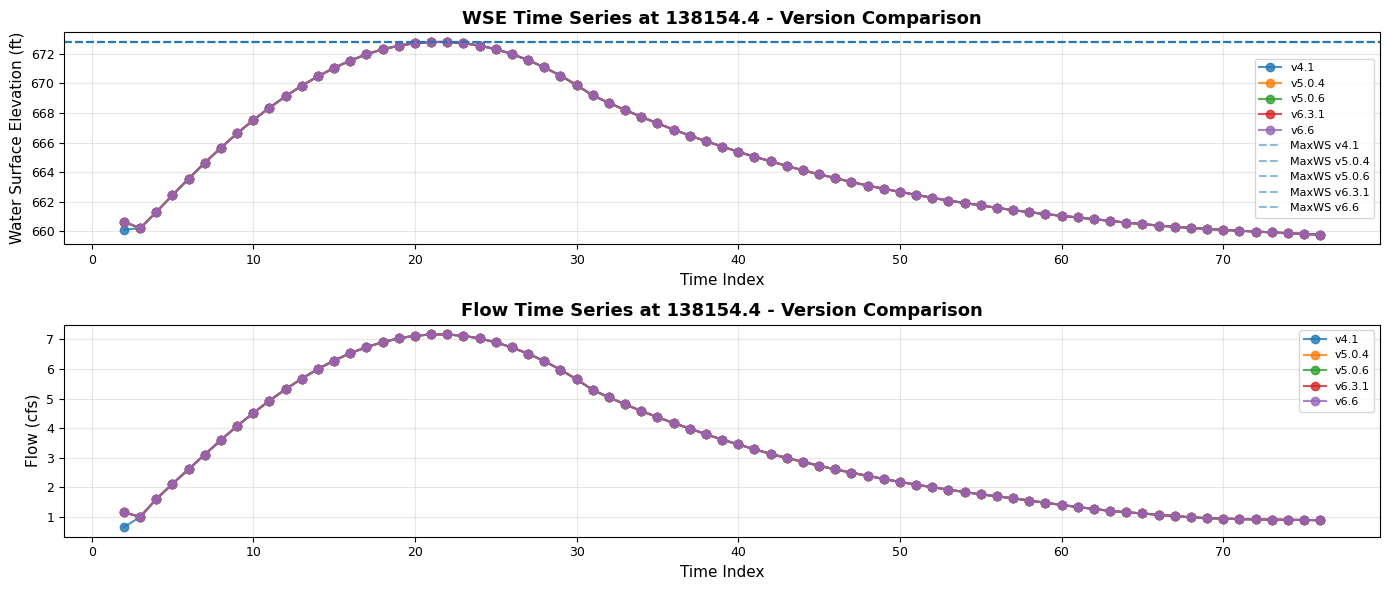


Station 138154.4:
  v4.1: timesteps=75, max_wse=672.80 ft
  v5.0.4: timesteps=75, max_wse=672.80 ft
  v5.0.6: timesteps=75, max_wse=672.80 ft
  v6.3.1: timesteps=75, max_wse=672.80 ft
  v6.6: timesteps=75, max_wse=672.80 ft


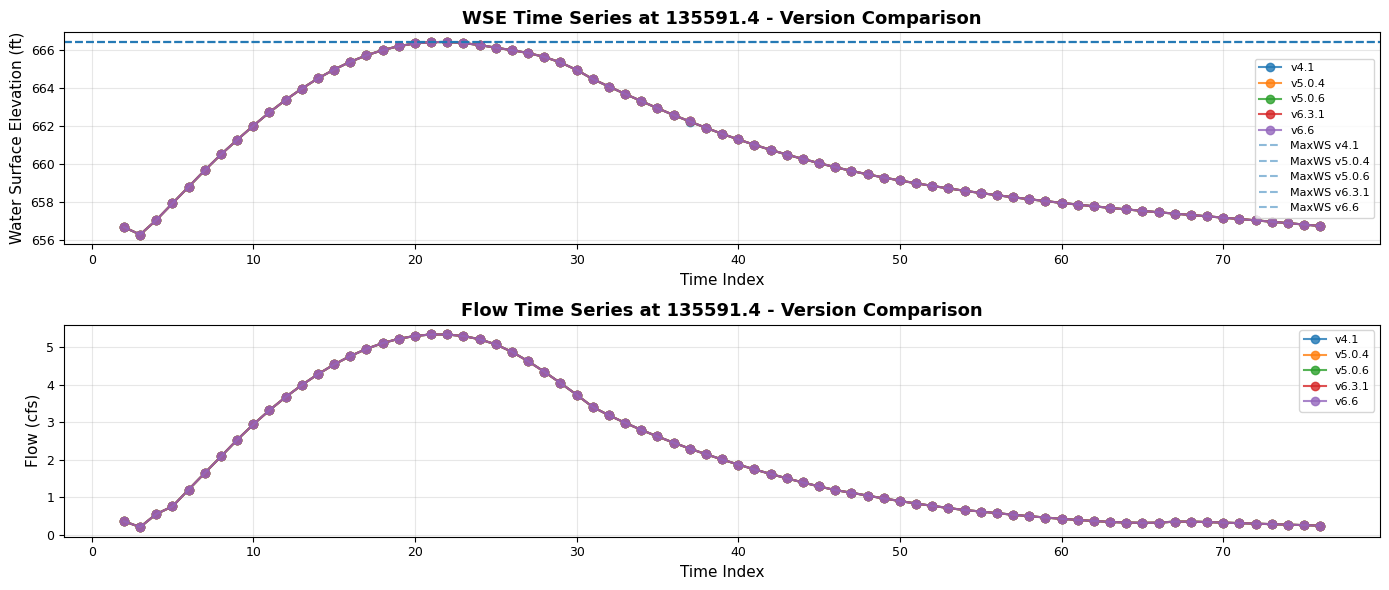


Station 135591.4:
  v4.1: timesteps=75, max_wse=666.43 ft
  v5.0.4: timesteps=75, max_wse=666.43 ft
  v5.0.6: timesteps=75, max_wse=666.43 ft
  v6.3.1: timesteps=75, max_wse=666.43 ft
  v6.6: timesteps=75, max_wse=666.43 ft


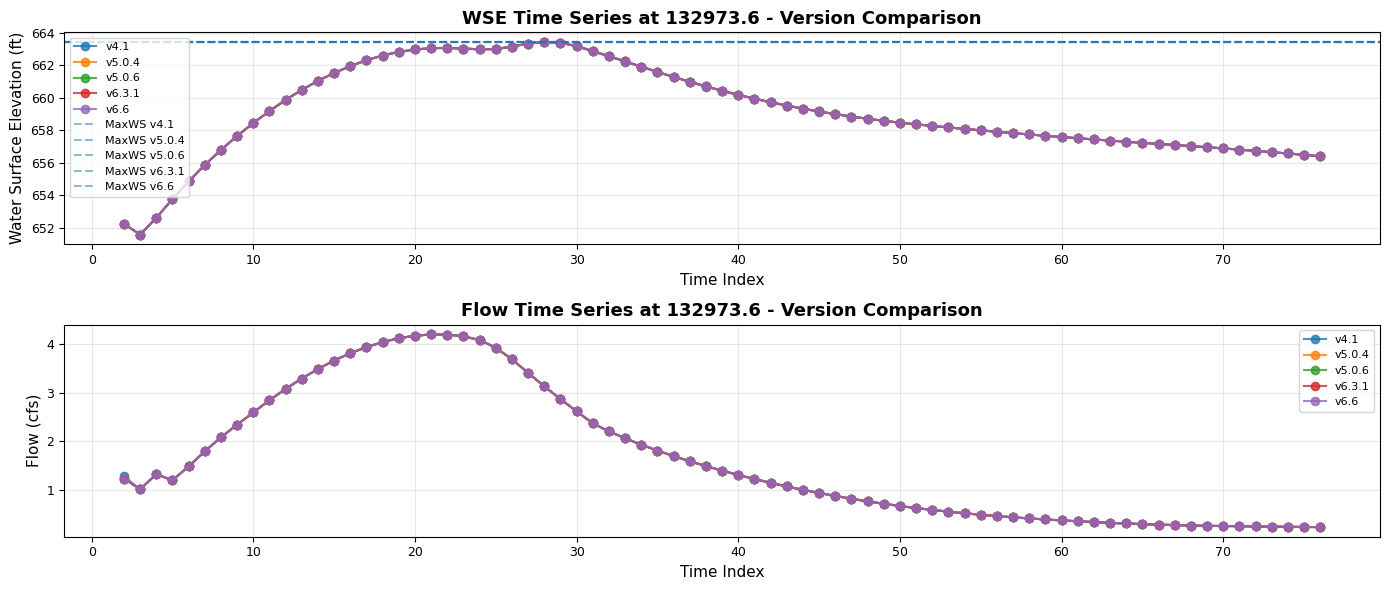


Station 132973.6:
  v4.1: timesteps=75, max_wse=663.44 ft
  v5.0.4: timesteps=75, max_wse=663.44 ft
  v5.0.6: timesteps=75, max_wse=663.44 ft
  v6.3.1: timesteps=75, max_wse=663.44 ft
  v6.6: timesteps=75, max_wse=663.44 ft


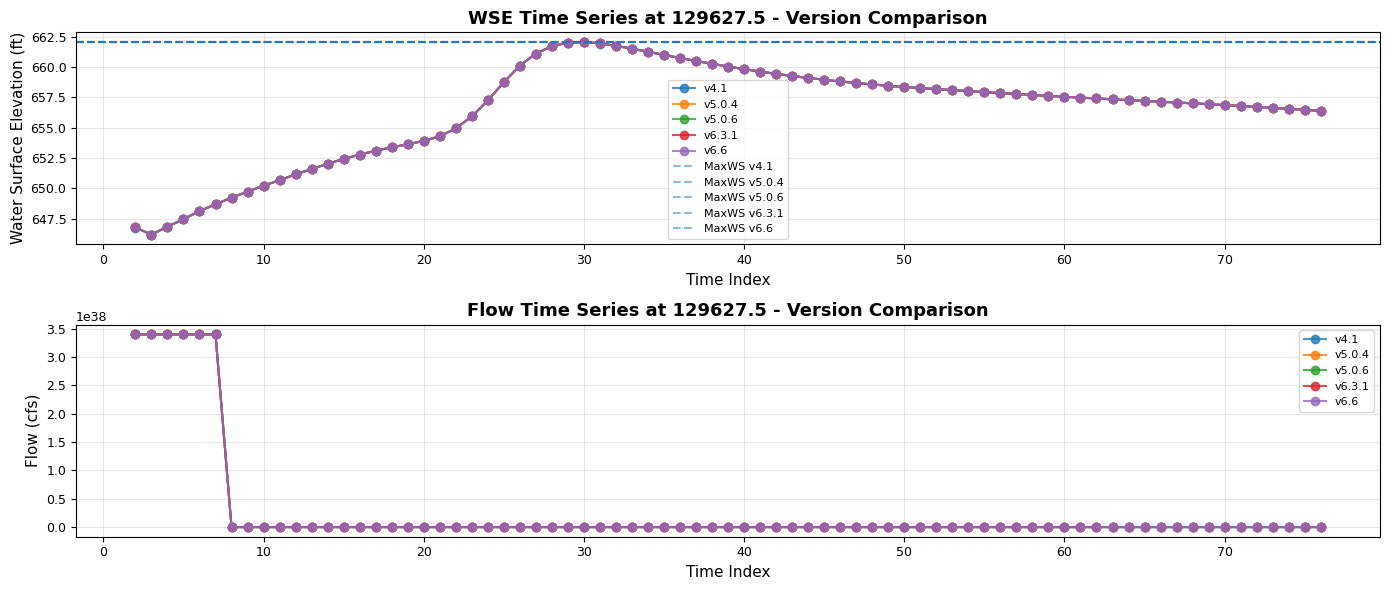


Station 129627.5:
  v4.1: timesteps=75, max_wse=662.05 ft
  v5.0.4: timesteps=75, max_wse=662.05 ft
  v5.0.6: timesteps=75, max_wse=662.05 ft
  v6.3.1: timesteps=75, max_wse=662.05 ft
  v6.6: timesteps=75, max_wse=662.05 ft


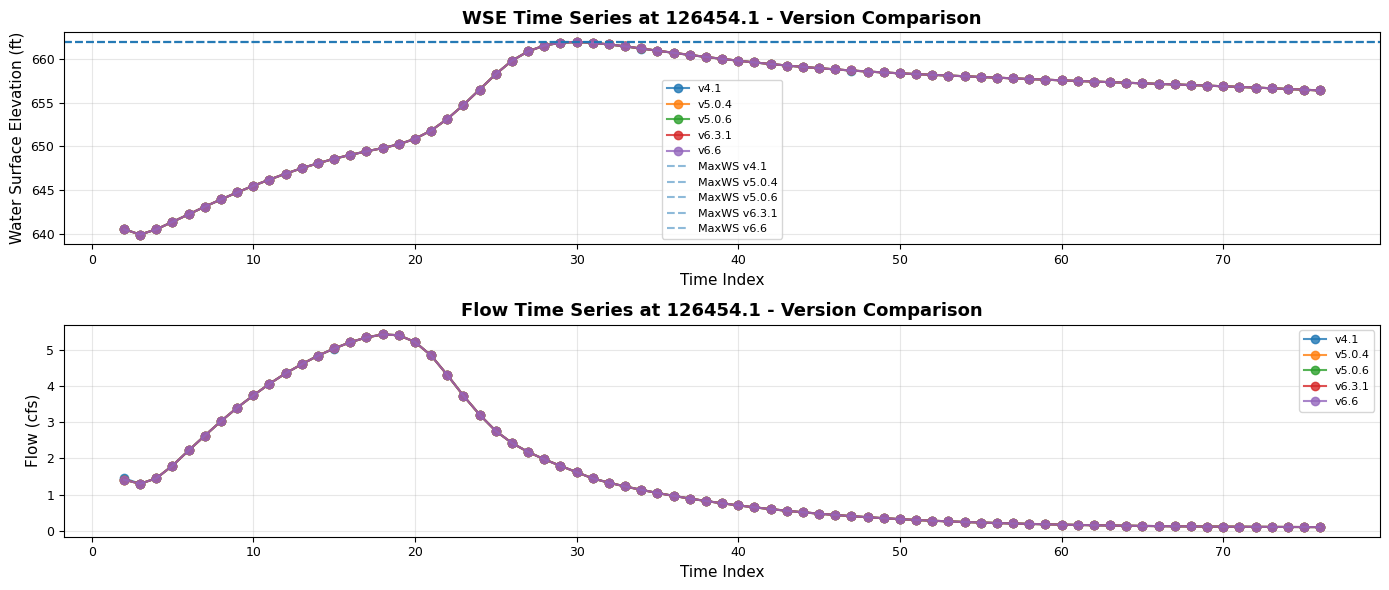


Station 126454.1:
  v4.1: timesteps=75, max_wse=661.92 ft
  v5.0.4: timesteps=75, max_wse=661.93 ft
  v5.0.6: timesteps=75, max_wse=661.93 ft
  v6.3.1: timesteps=75, max_wse=661.93 ft
  v6.6: timesteps=75, max_wse=661.93 ft


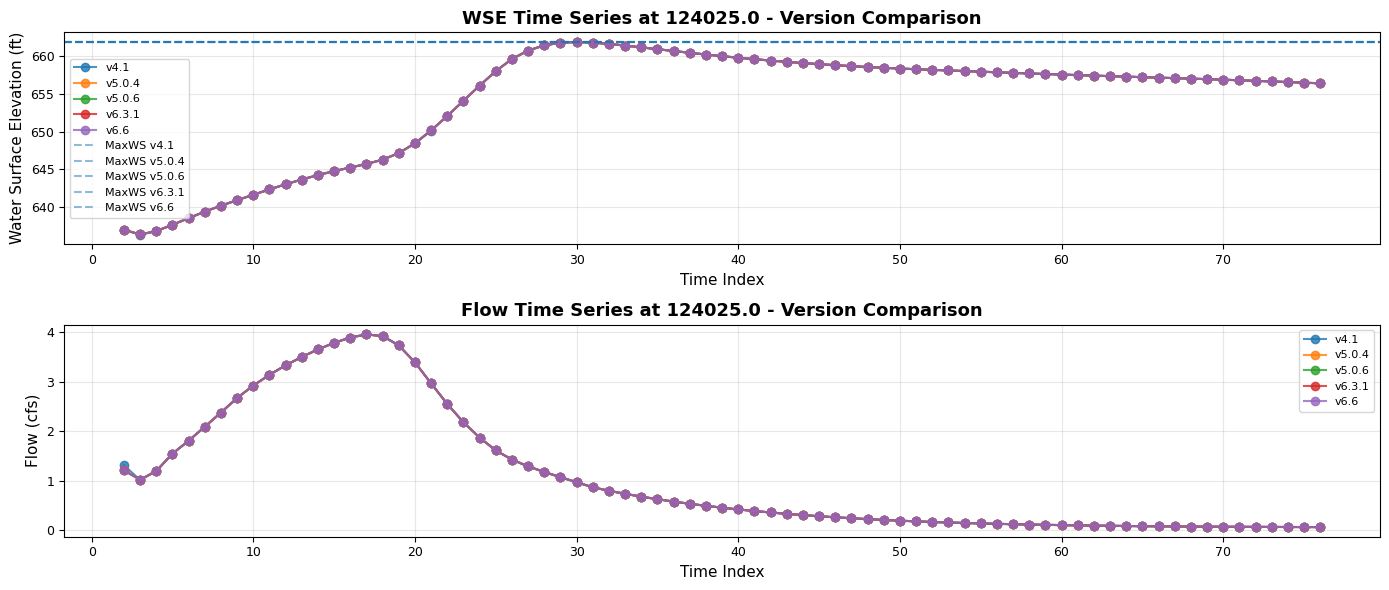


Station 124025.0:
  v4.1: timesteps=75, max_wse=661.85 ft
  v5.0.4: timesteps=75, max_wse=661.86 ft
  v5.0.6: timesteps=75, max_wse=661.86 ft
  v6.3.1: timesteps=75, max_wse=661.86 ft
  v6.6: timesteps=75, max_wse=661.86 ft


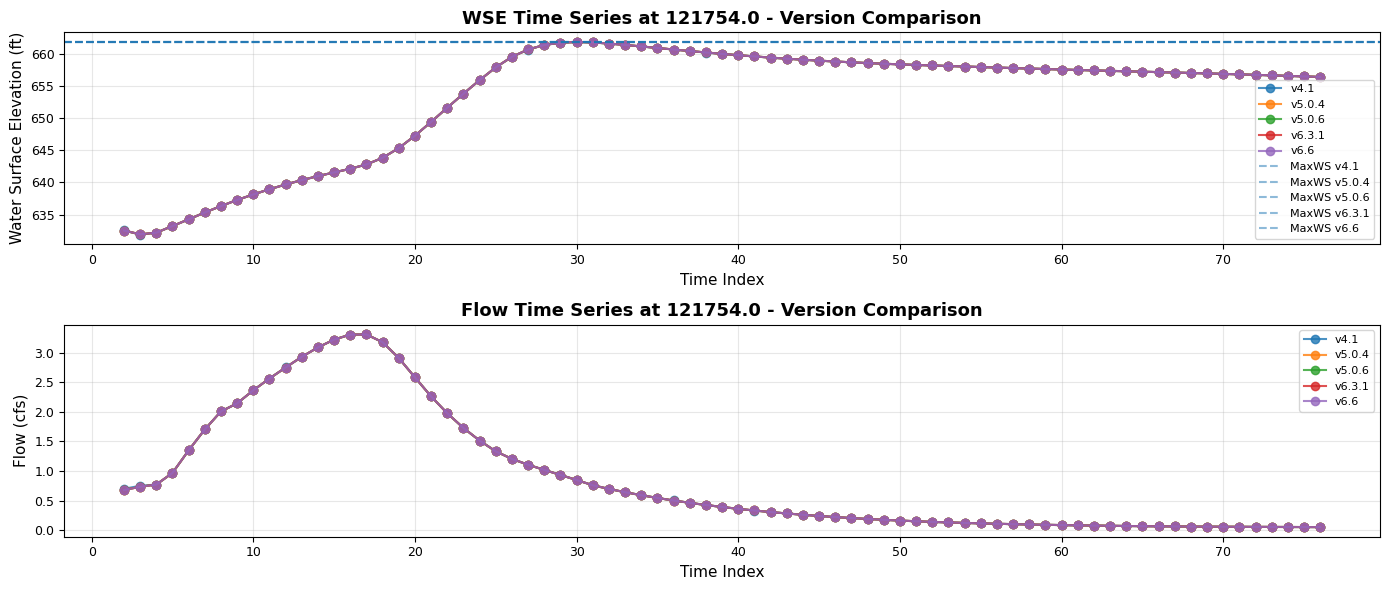


Station 121754.0:
  v4.1: timesteps=75, max_wse=661.81 ft
  v5.0.4: timesteps=75, max_wse=661.82 ft
  v5.0.6: timesteps=75, max_wse=661.82 ft
  v6.3.1: timesteps=75, max_wse=661.82 ft
  v6.6: timesteps=75, max_wse=661.82 ft


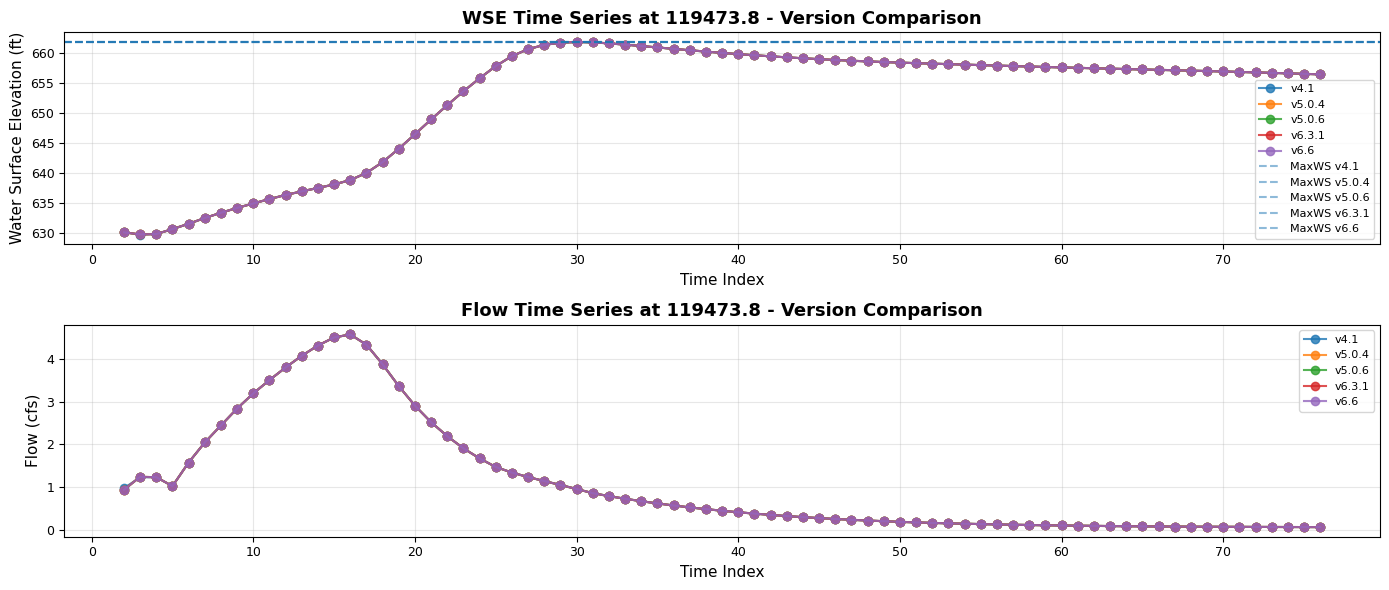


Station 119473.8:
  v4.1: timesteps=75, max_wse=661.77 ft
  v5.0.4: timesteps=75, max_wse=661.78 ft
  v5.0.6: timesteps=75, max_wse=661.78 ft
  v6.3.1: timesteps=75, max_wse=661.78 ft
  v6.6: timesteps=75, max_wse=661.78 ft


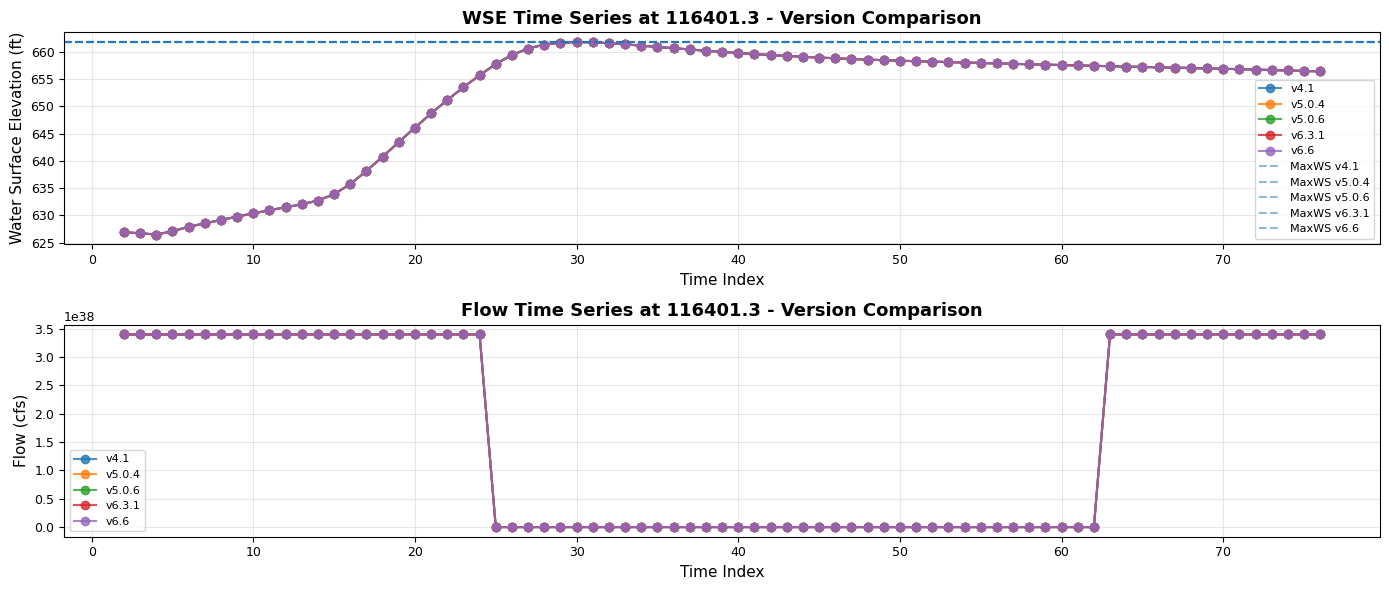


Station 116401.3:
  v4.1: timesteps=75, max_wse=661.76 ft
  v5.0.4: timesteps=75, max_wse=661.77 ft
  v5.0.6: timesteps=75, max_wse=661.77 ft
  v6.3.1: timesteps=75, max_wse=661.77 ft
  v6.6: timesteps=75, max_wse=661.77 ft


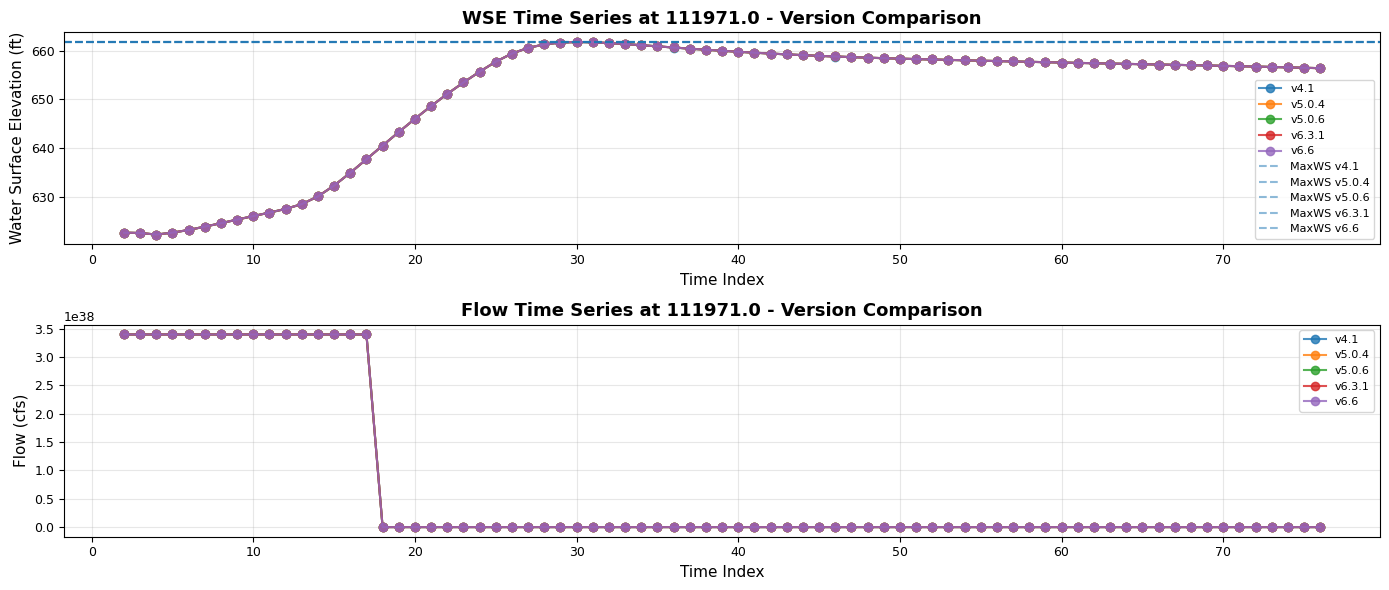


Station 111971.0:
  v4.1: timesteps=75, max_wse=661.76 ft
  v5.0.4: timesteps=75, max_wse=661.76 ft
  v5.0.6: timesteps=75, max_wse=661.76 ft
  v6.3.1: timesteps=75, max_wse=661.76 ft
  v6.6: timesteps=75, max_wse=661.76 ft


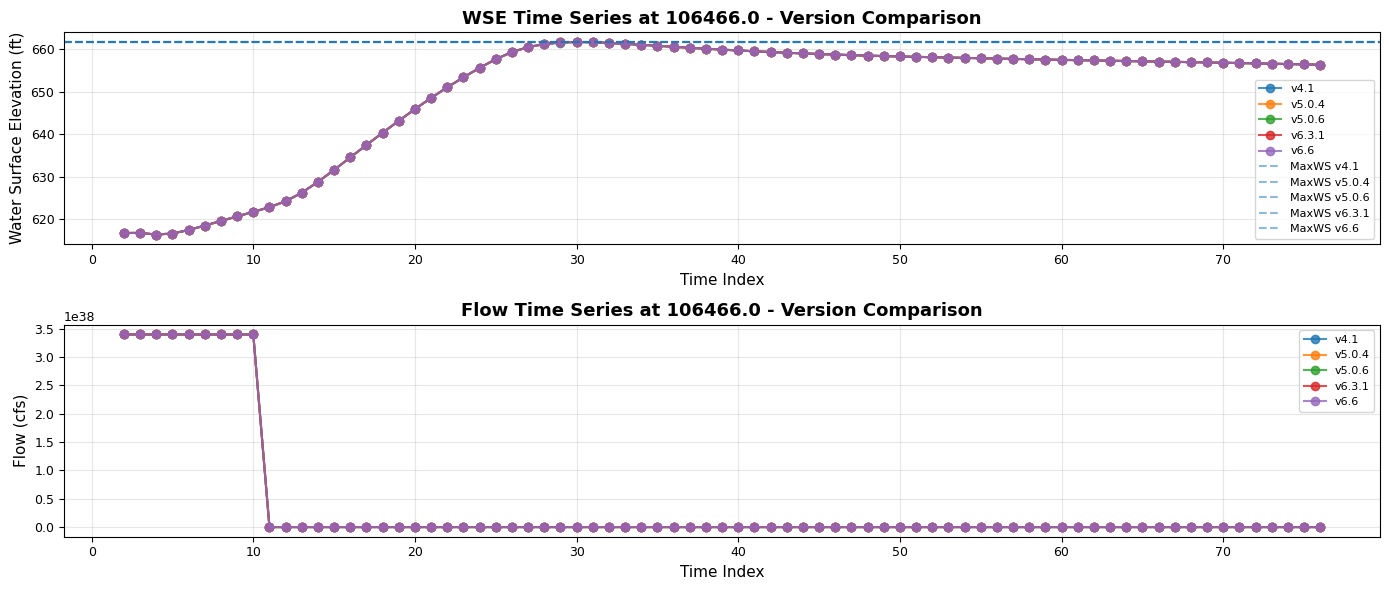


Station 106466.0:
  v4.1: timesteps=75, max_wse=661.75 ft
  v5.0.4: timesteps=75, max_wse=661.76 ft
  v5.0.6: timesteps=75, max_wse=661.76 ft
  v6.3.1: timesteps=75, max_wse=661.76 ft
  v6.6: timesteps=75, max_wse=661.76 ft


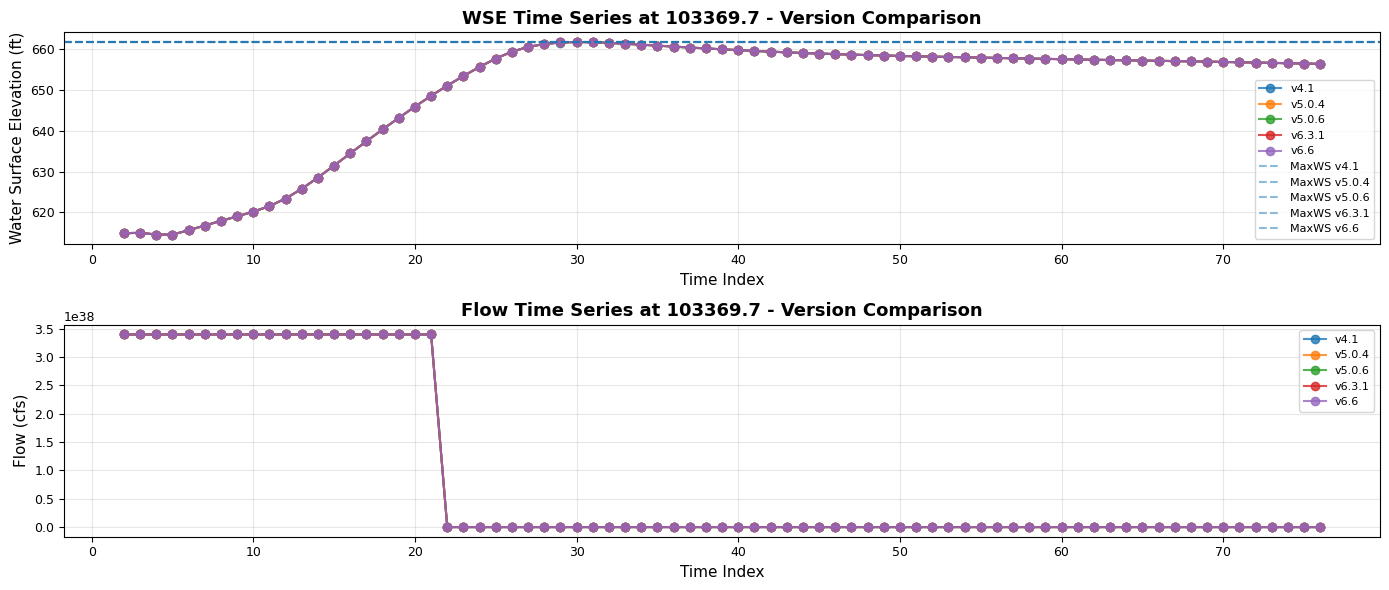


Station 103369.7:
  v4.1: timesteps=75, max_wse=661.75 ft
  v5.0.4: timesteps=75, max_wse=661.75 ft
  v5.0.6: timesteps=75, max_wse=661.75 ft
  v6.3.1: timesteps=75, max_wse=661.75 ft
  v6.6: timesteps=75, max_wse=661.75 ft


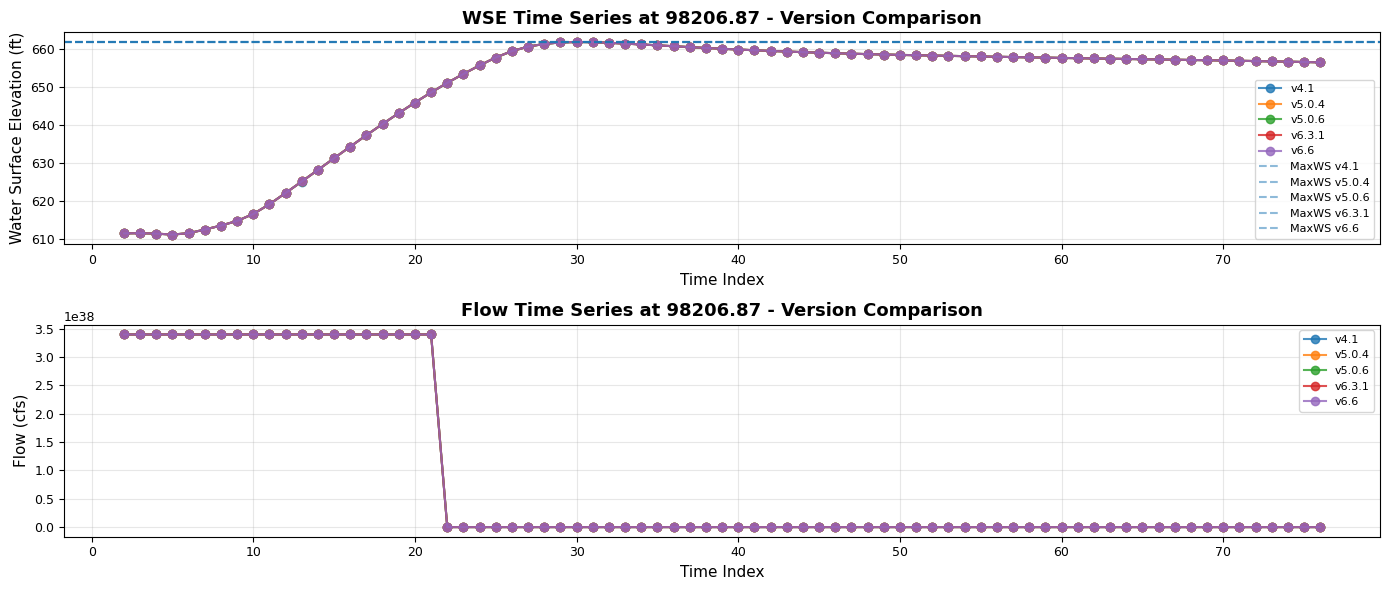


Station 98206.87:
  v4.1: timesteps=75, max_wse=661.73 ft
  v5.0.4: timesteps=75, max_wse=661.73 ft
  v5.0.6: timesteps=75, max_wse=661.73 ft
  v6.3.1: timesteps=75, max_wse=661.73 ft
  v6.6: timesteps=75, max_wse=661.73 ft


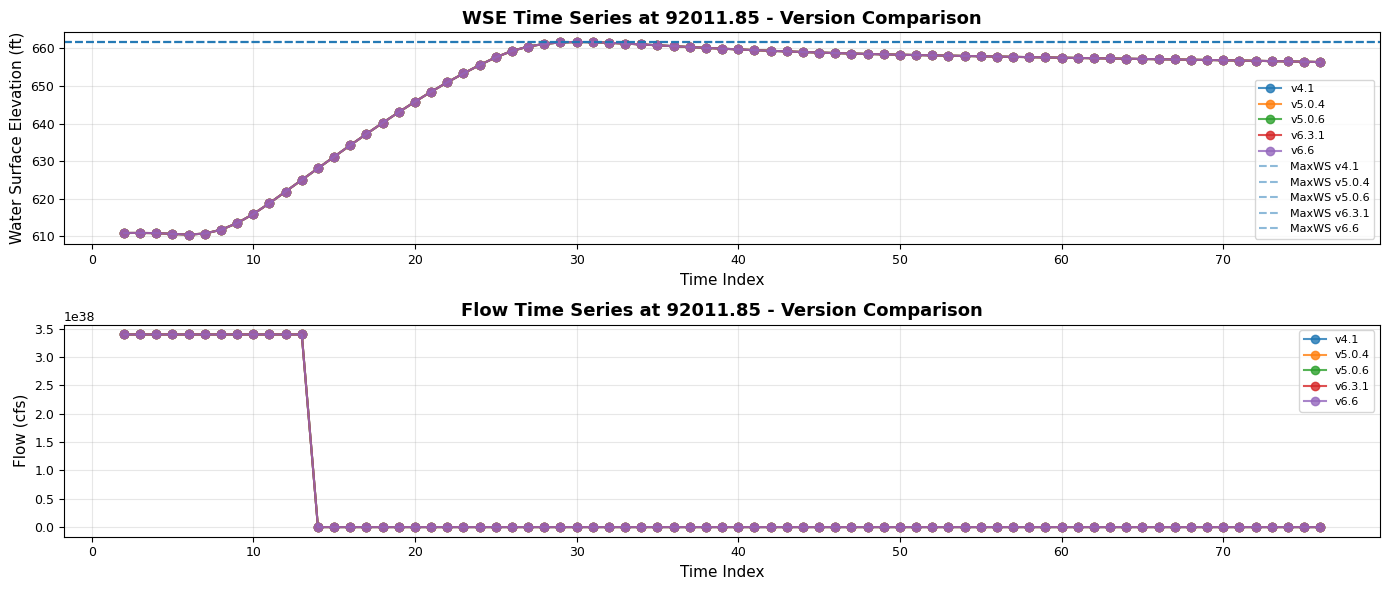


Station 92011.85:
  v4.1: timesteps=75, max_wse=661.72 ft
  v5.0.4: timesteps=75, max_wse=661.72 ft
  v5.0.6: timesteps=75, max_wse=661.72 ft
  v6.3.1: timesteps=75, max_wse=661.72 ft
  v6.6: timesteps=75, max_wse=661.72 ft


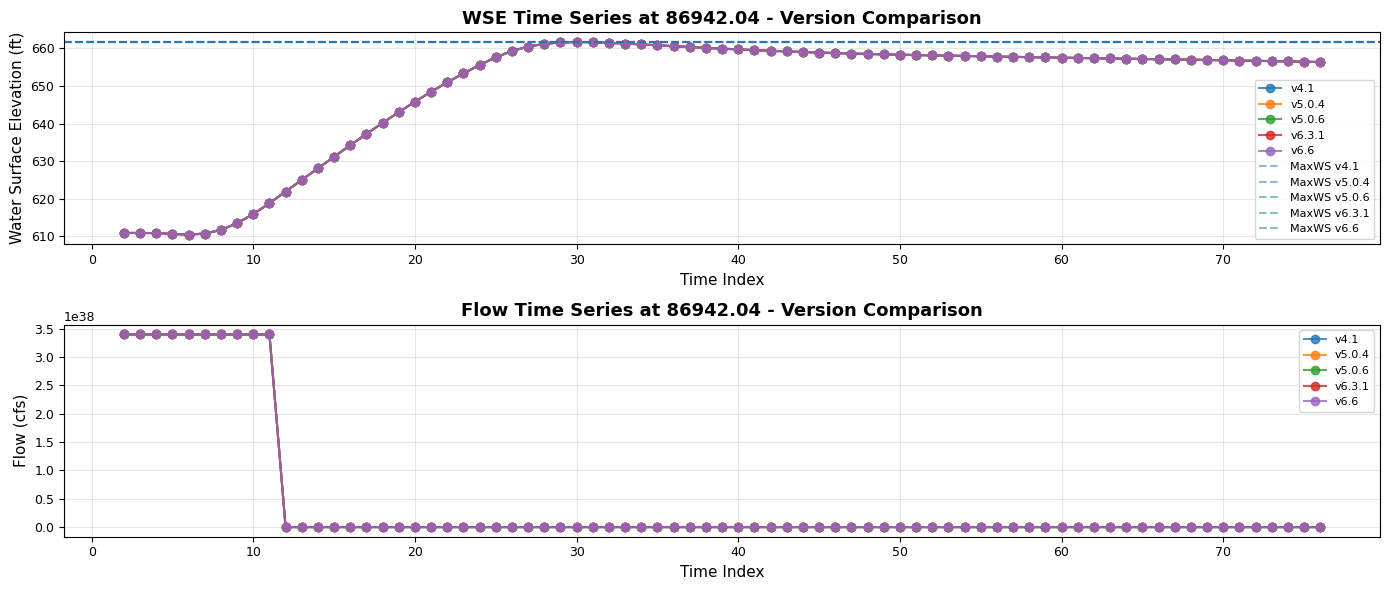


Station 86942.04:
  v4.1: timesteps=75, max_wse=661.72 ft
  v5.0.4: timesteps=75, max_wse=661.72 ft
  v5.0.6: timesteps=75, max_wse=661.72 ft
  v6.3.1: timesteps=75, max_wse=661.72 ft
  v6.6: timesteps=75, max_wse=661.72 ft


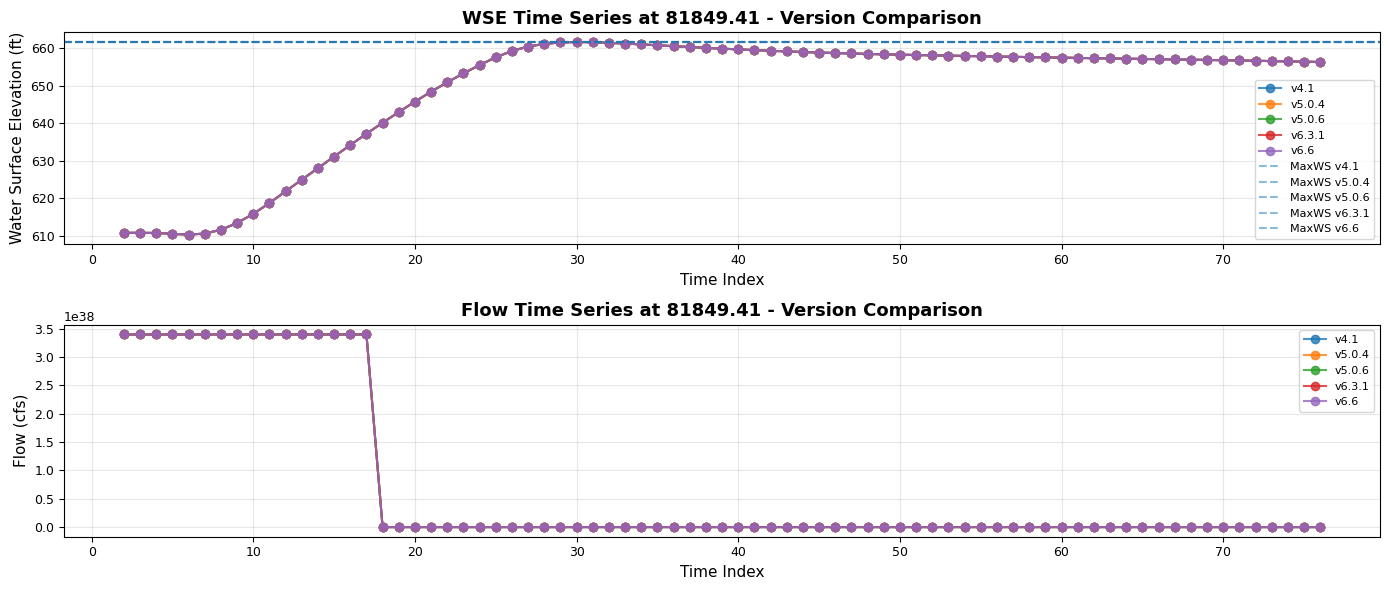


Station 81849.41:
  v4.1: timesteps=75, max_wse=661.72 ft
  v5.0.4: timesteps=75, max_wse=661.72 ft
  v5.0.6: timesteps=75, max_wse=661.72 ft
  v6.3.1: timesteps=75, max_wse=661.72 ft
  v6.6: timesteps=75, max_wse=661.72 ft


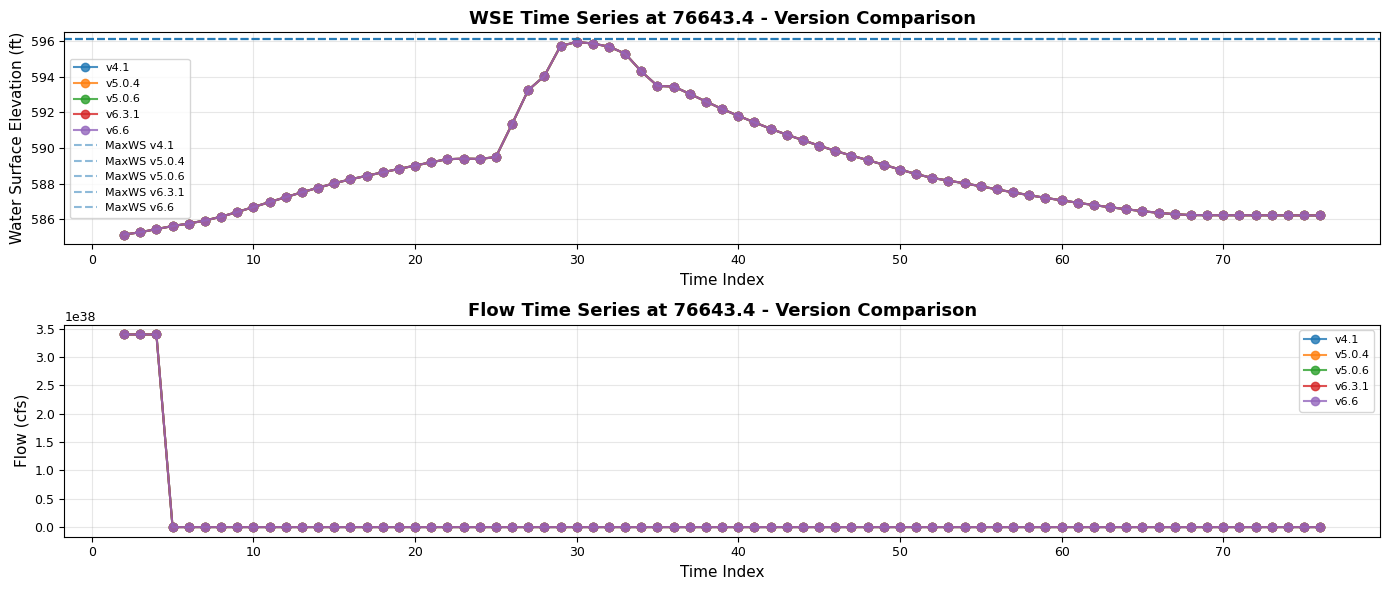


Station 76643.4:
  v4.1: timesteps=75, max_wse=595.93 ft
  v5.0.4: timesteps=75, max_wse=595.93 ft
  v5.0.6: timesteps=75, max_wse=595.93 ft
  v6.3.1: timesteps=75, max_wse=595.94 ft
  v6.6: timesteps=75, max_wse=595.94 ft


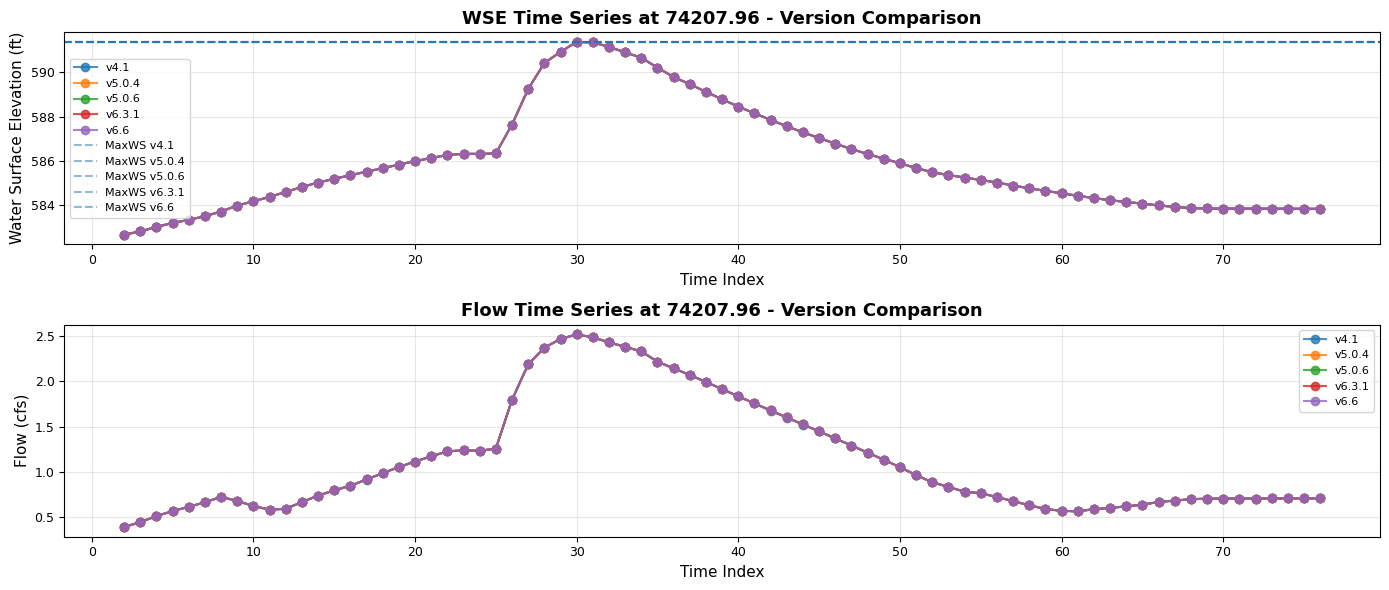


Station 74207.96:
  v4.1: timesteps=75, max_wse=591.37 ft
  v5.0.4: timesteps=75, max_wse=591.37 ft
  v5.0.6: timesteps=75, max_wse=591.37 ft
  v6.3.1: timesteps=75, max_wse=591.37 ft
  v6.6: timesteps=75, max_wse=591.37 ft


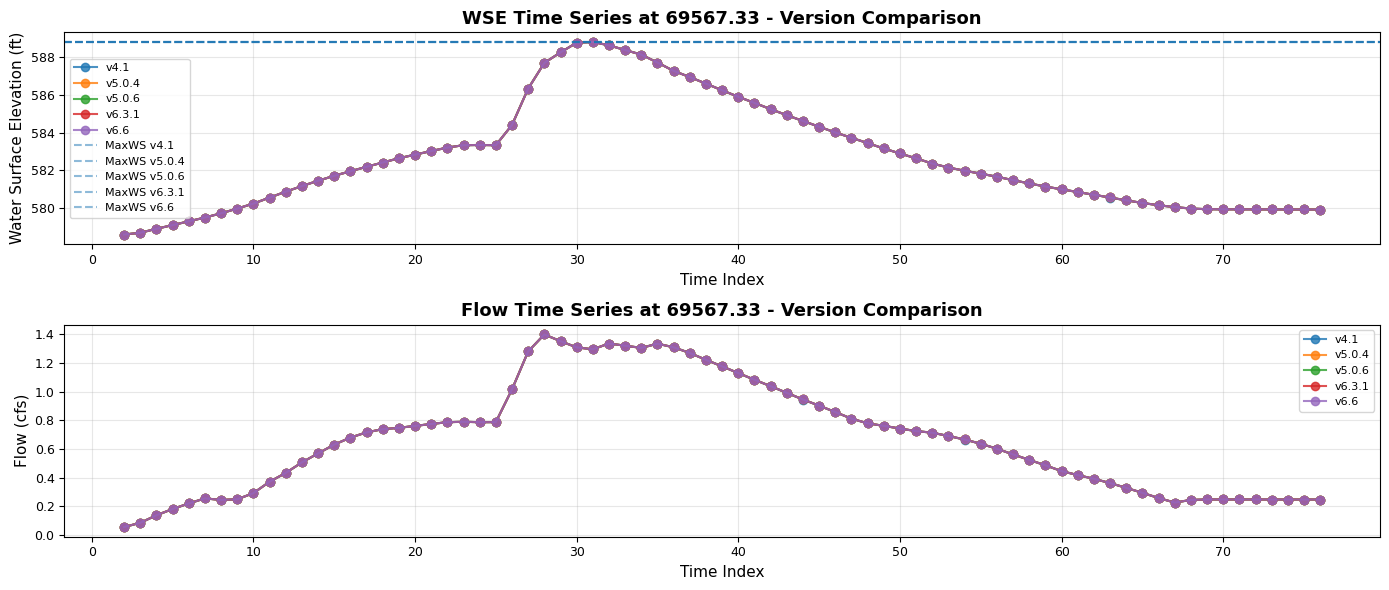


Station 69567.33:
  v4.1: timesteps=75, max_wse=588.82 ft
  v5.0.4: timesteps=75, max_wse=588.82 ft
  v5.0.6: timesteps=75, max_wse=588.82 ft
  v6.3.1: timesteps=75, max_wse=588.82 ft
  v6.6: timesteps=75, max_wse=588.82 ft


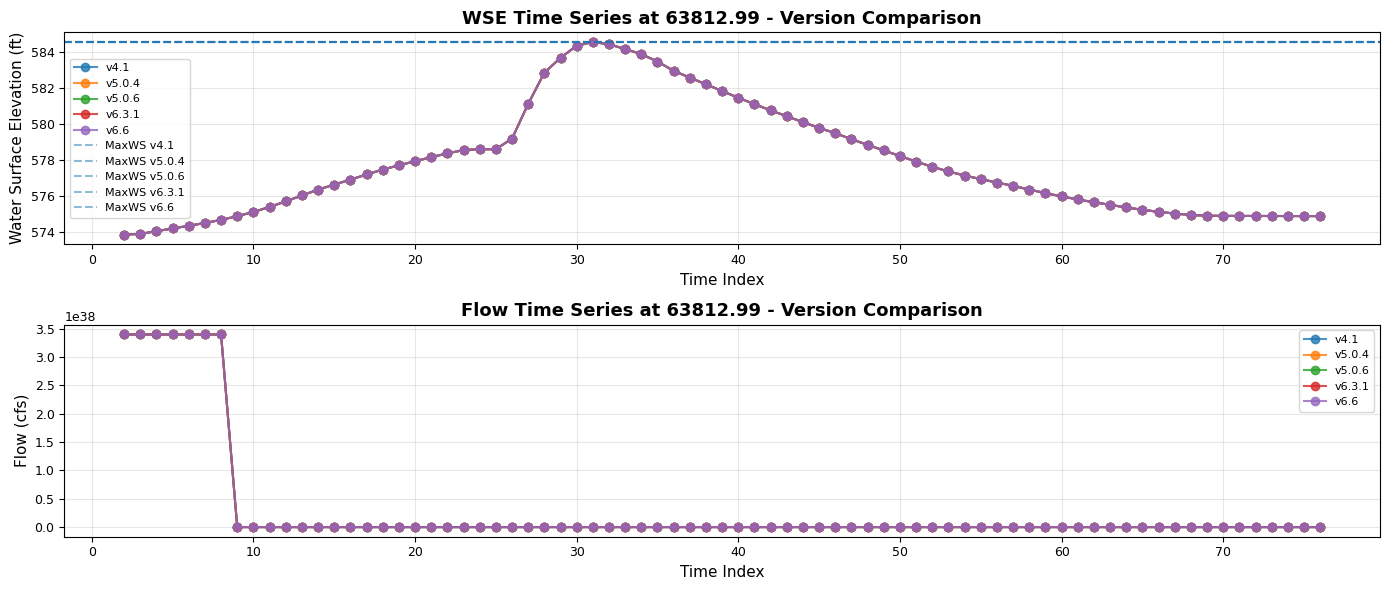


Station 63812.99:
  v4.1: timesteps=75, max_wse=584.55 ft
  v5.0.4: timesteps=75, max_wse=584.55 ft
  v5.0.6: timesteps=75, max_wse=584.55 ft
  v6.3.1: timesteps=75, max_wse=584.55 ft
  v6.6: timesteps=75, max_wse=584.55 ft


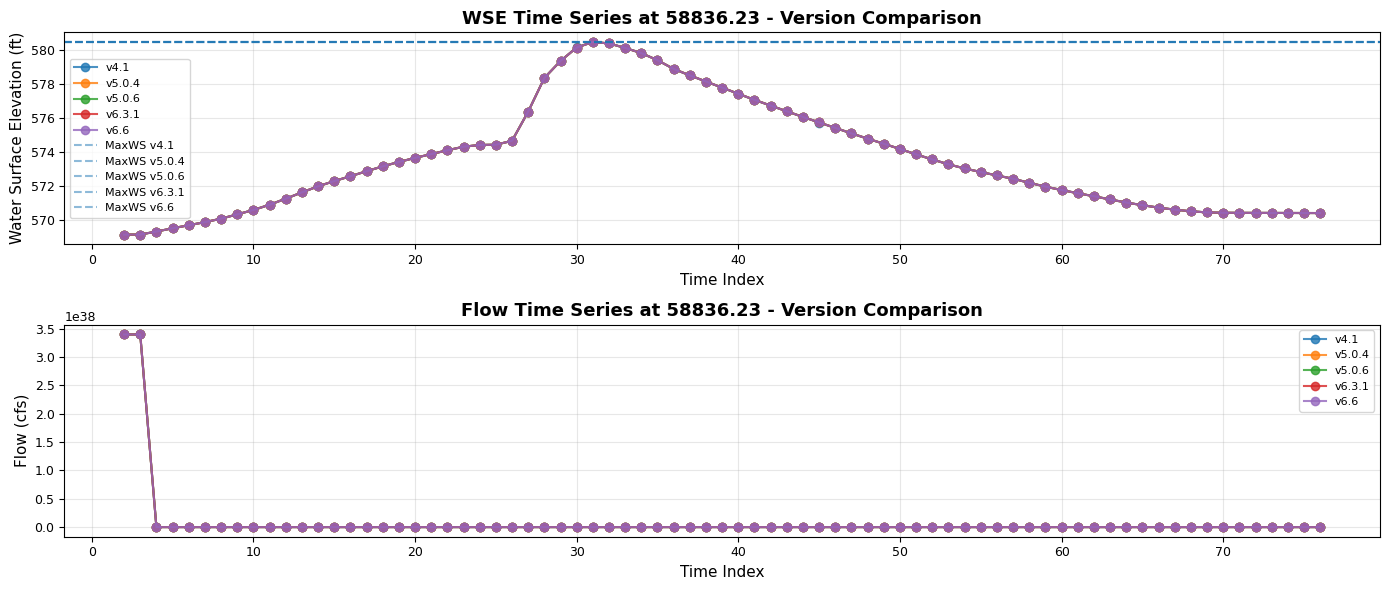


Station 58836.23:
  v4.1: timesteps=75, max_wse=580.49 ft
  v5.0.4: timesteps=75, max_wse=580.49 ft
  v5.0.6: timesteps=75, max_wse=580.49 ft
  v6.3.1: timesteps=75, max_wse=580.49 ft
  v6.6: timesteps=75, max_wse=580.49 ft


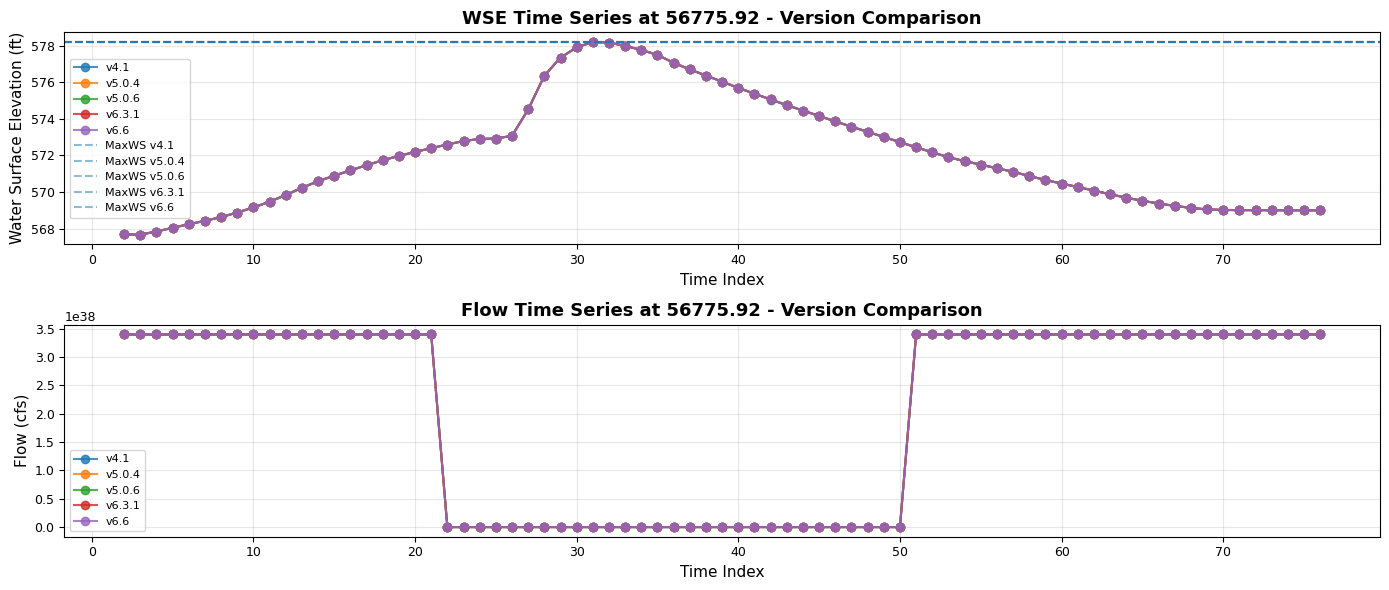


Station 56775.92:
  v4.1: timesteps=75, max_wse=578.21 ft
  v5.0.4: timesteps=75, max_wse=578.21 ft
  v5.0.6: timesteps=75, max_wse=578.21 ft
  v6.3.1: timesteps=75, max_wse=578.21 ft
  v6.6: timesteps=75, max_wse=578.21 ft


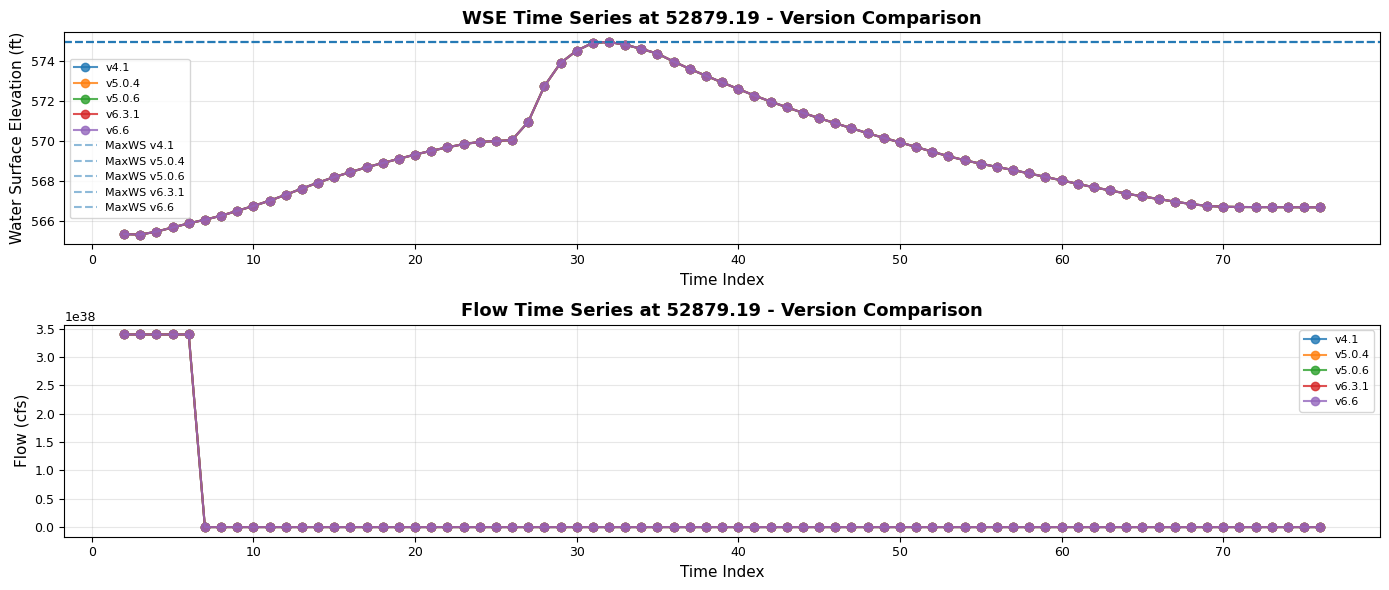


Station 52879.19:
  v4.1: timesteps=75, max_wse=574.95 ft
  v5.0.4: timesteps=75, max_wse=574.95 ft
  v5.0.6: timesteps=75, max_wse=574.95 ft
  v6.3.1: timesteps=75, max_wse=574.95 ft
  v6.6: timesteps=75, max_wse=574.95 ft


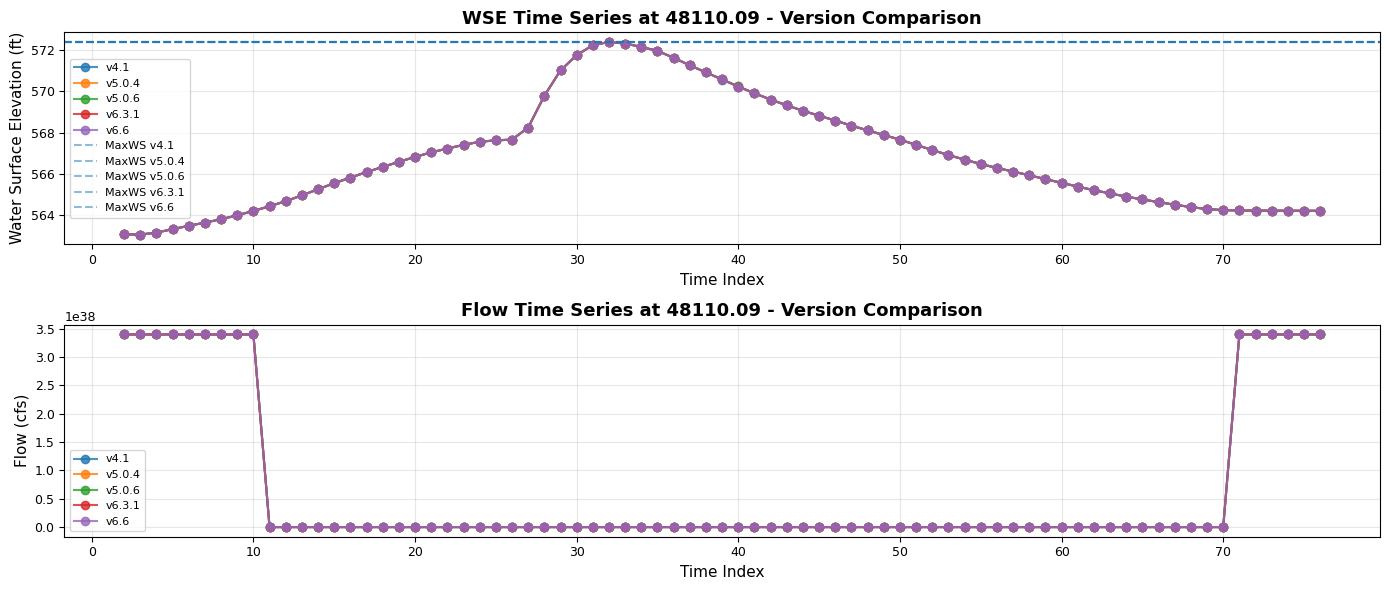


Station 48110.09:
  v4.1: timesteps=75, max_wse=572.39 ft
  v5.0.4: timesteps=75, max_wse=572.40 ft
  v5.0.6: timesteps=75, max_wse=572.40 ft
  v6.3.1: timesteps=75, max_wse=572.40 ft
  v6.6: timesteps=75, max_wse=572.40 ft


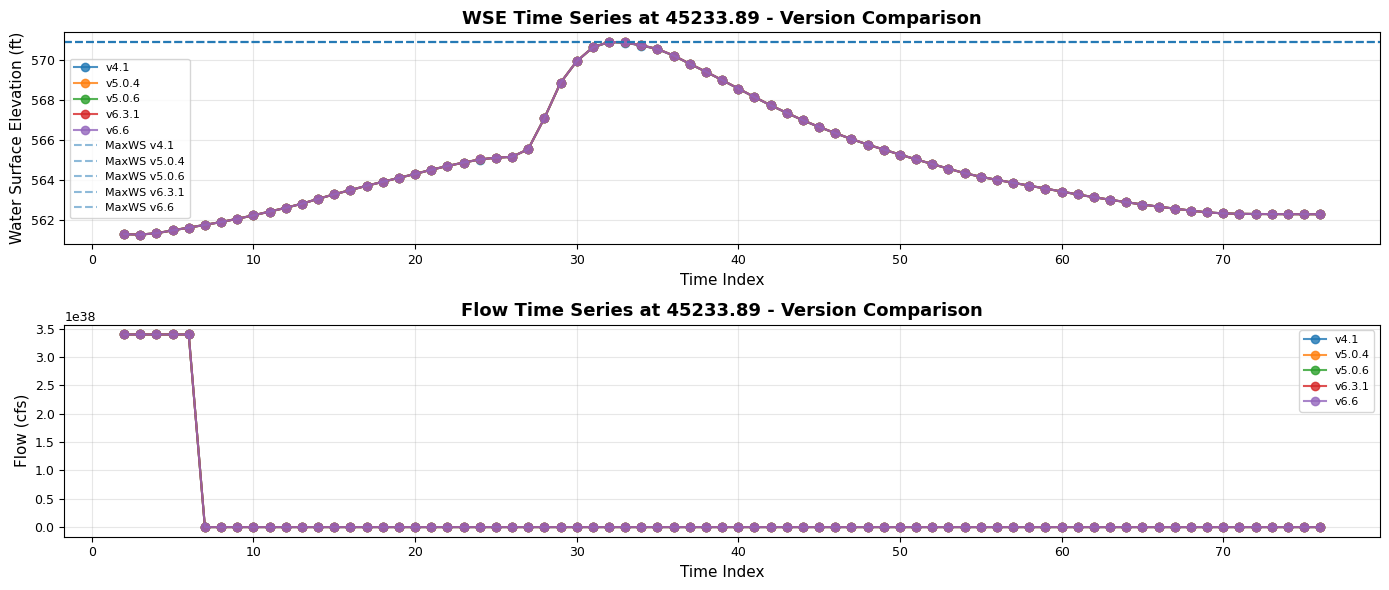


Station 45233.89:
  v4.1: timesteps=75, max_wse=570.90 ft
  v5.0.4: timesteps=75, max_wse=570.91 ft
  v5.0.6: timesteps=75, max_wse=570.91 ft
  v6.3.1: timesteps=75, max_wse=570.91 ft
  v6.6: timesteps=75, max_wse=570.91 ft


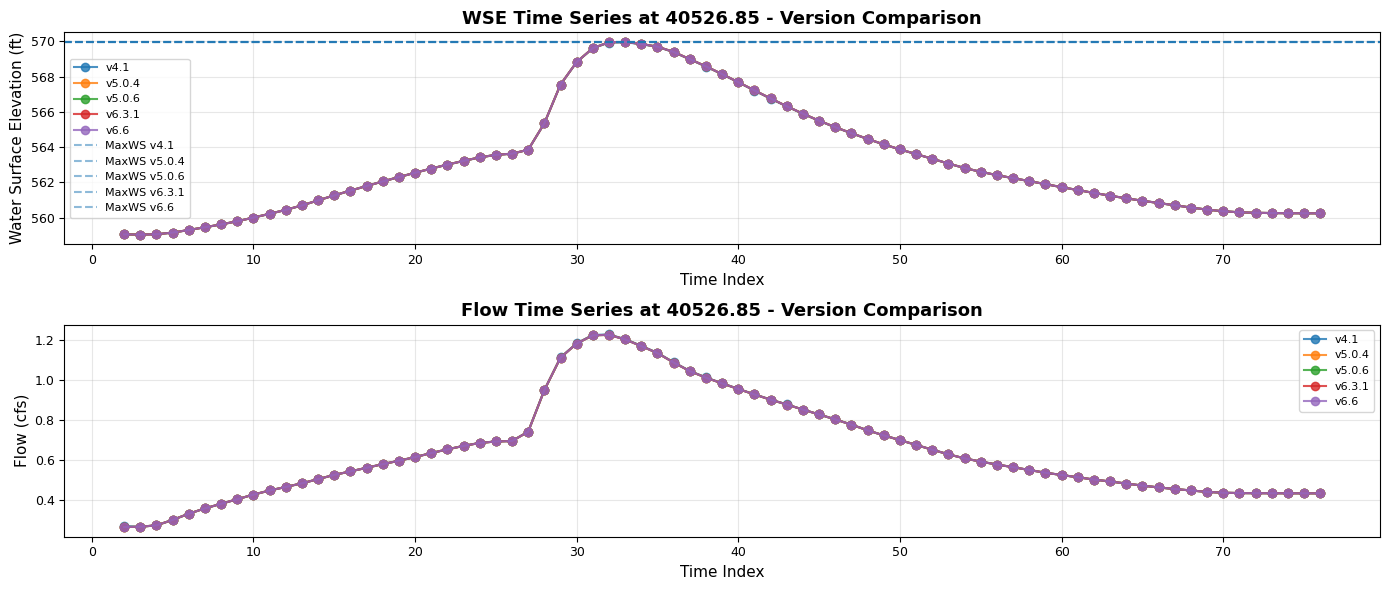


Station 40526.85:
  v4.1: timesteps=75, max_wse=569.95 ft
  v5.0.4: timesteps=75, max_wse=569.97 ft
  v5.0.6: timesteps=75, max_wse=569.97 ft
  v6.3.1: timesteps=75, max_wse=569.97 ft
  v6.6: timesteps=75, max_wse=569.97 ft


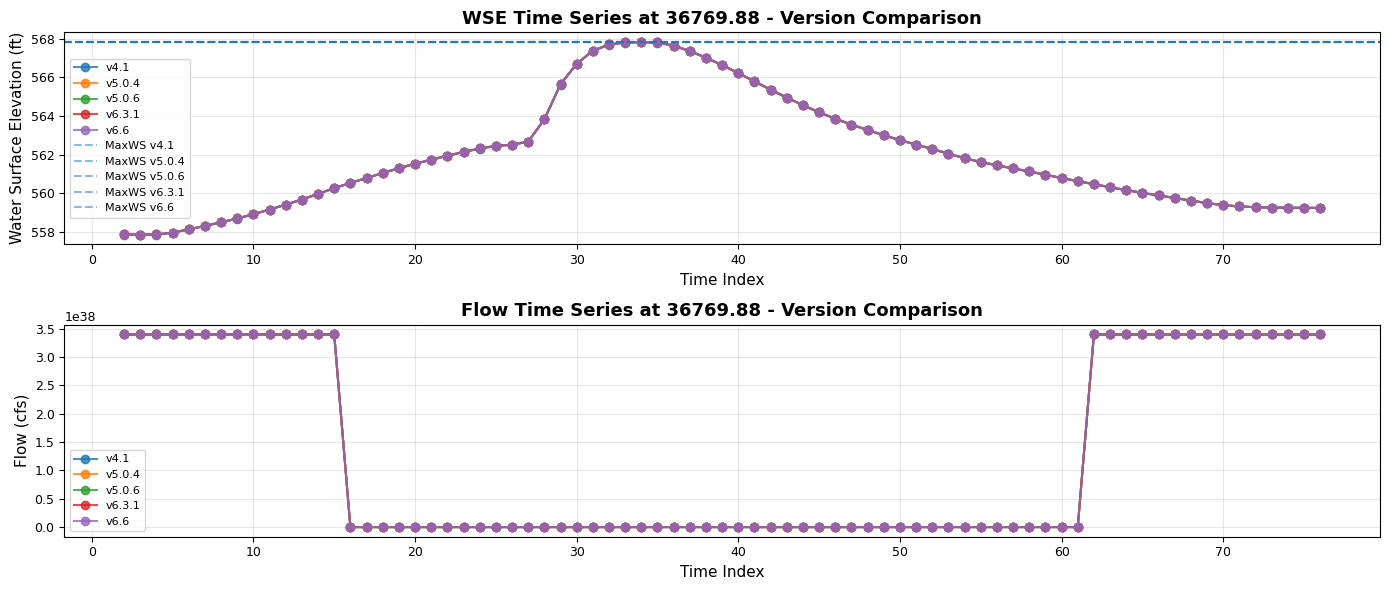


Station 36769.88:
  v4.1: timesteps=75, max_wse=567.81 ft
  v5.0.4: timesteps=75, max_wse=567.83 ft
  v5.0.6: timesteps=75, max_wse=567.83 ft
  v6.3.1: timesteps=75, max_wse=567.83 ft
  v6.6: timesteps=75, max_wse=567.83 ft


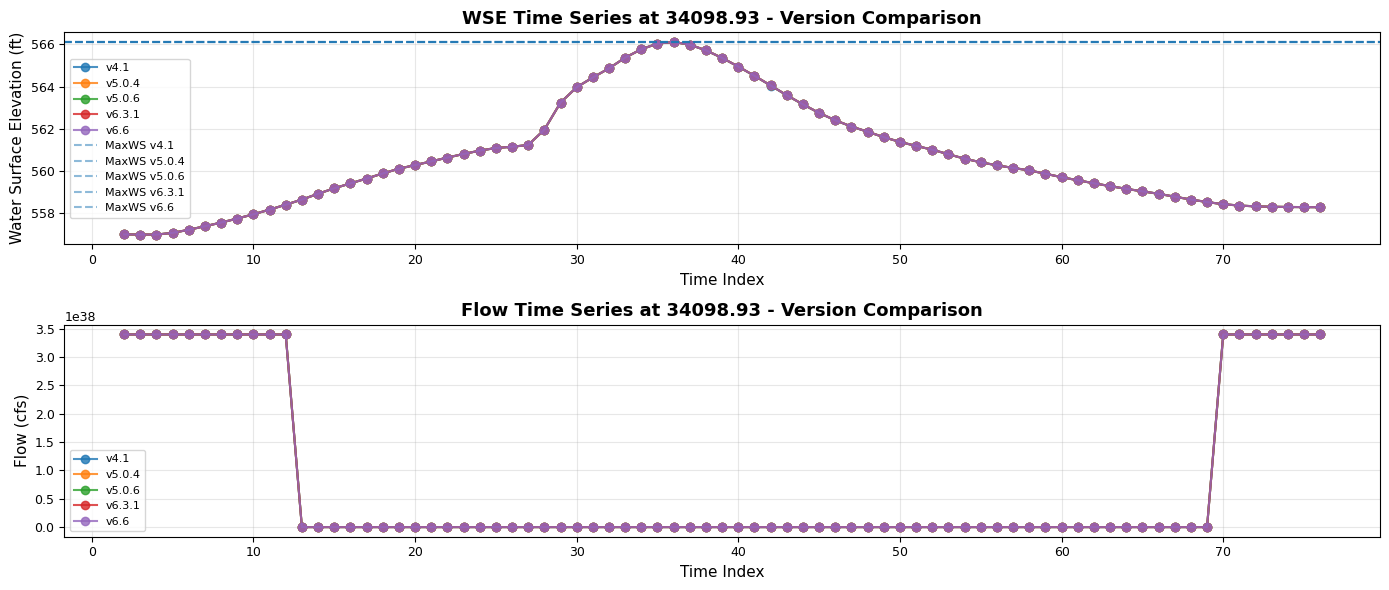


Station 34098.93:
  v4.1: timesteps=75, max_wse=566.11 ft
  v5.0.4: timesteps=75, max_wse=566.11 ft
  v5.0.6: timesteps=75, max_wse=566.11 ft
  v6.3.1: timesteps=75, max_wse=566.11 ft
  v6.6: timesteps=75, max_wse=566.11 ft


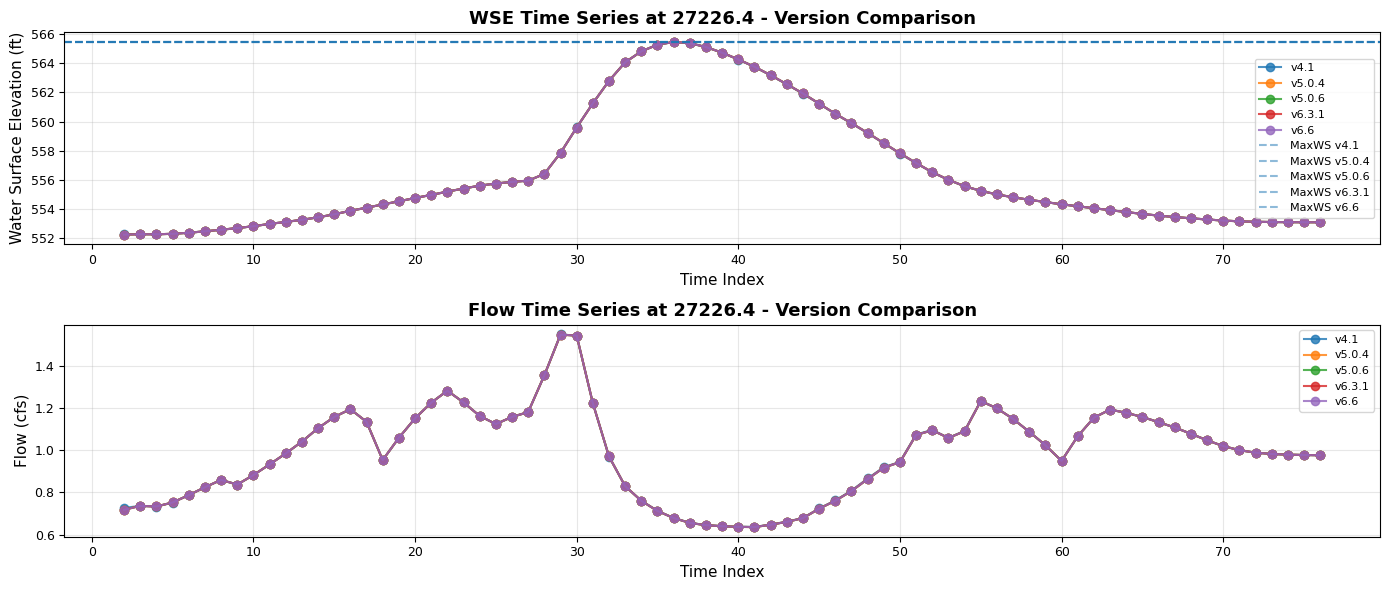


Station 27226.4:
  v4.1: timesteps=75, max_wse=565.45 ft
  v5.0.4: timesteps=75, max_wse=565.45 ft
  v5.0.6: timesteps=75, max_wse=565.45 ft
  v6.3.1: timesteps=75, max_wse=565.45 ft
  v6.6: timesteps=75, max_wse=565.45 ft


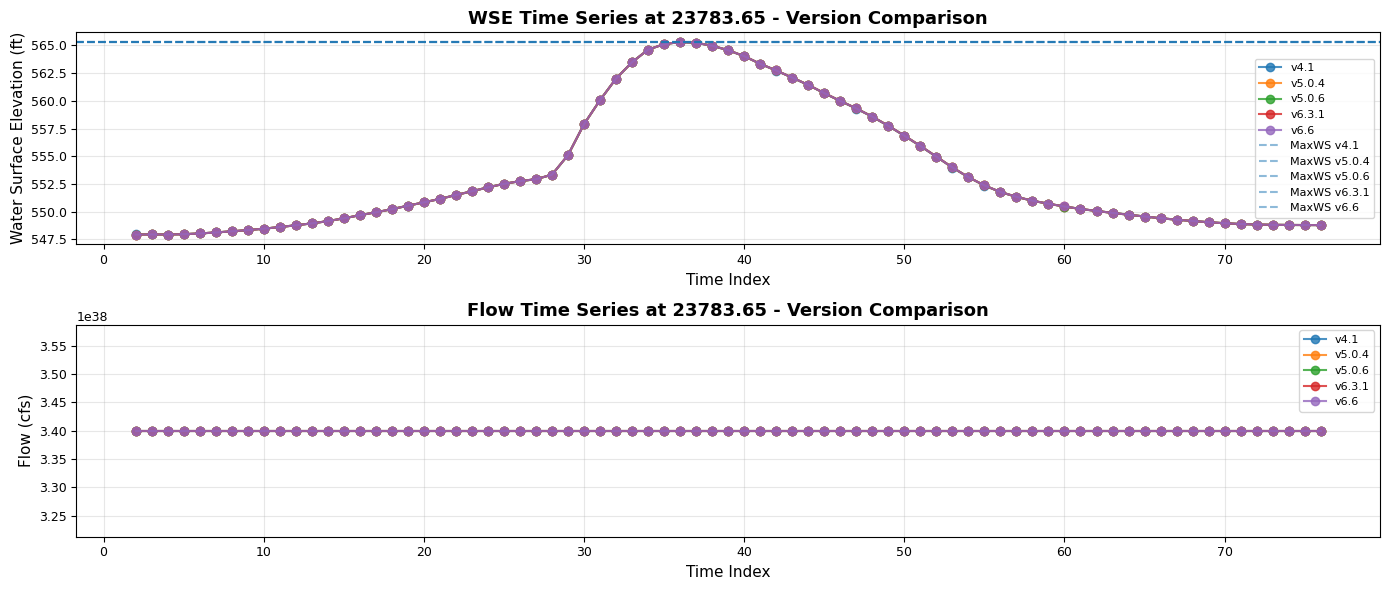


Station 23783.65:
  v4.1: timesteps=75, max_wse=565.32 ft
  v5.0.4: timesteps=75, max_wse=565.32 ft
  v5.0.6: timesteps=75, max_wse=565.32 ft
  v6.3.1: timesteps=75, max_wse=565.32 ft
  v6.6: timesteps=75, max_wse=565.32 ft


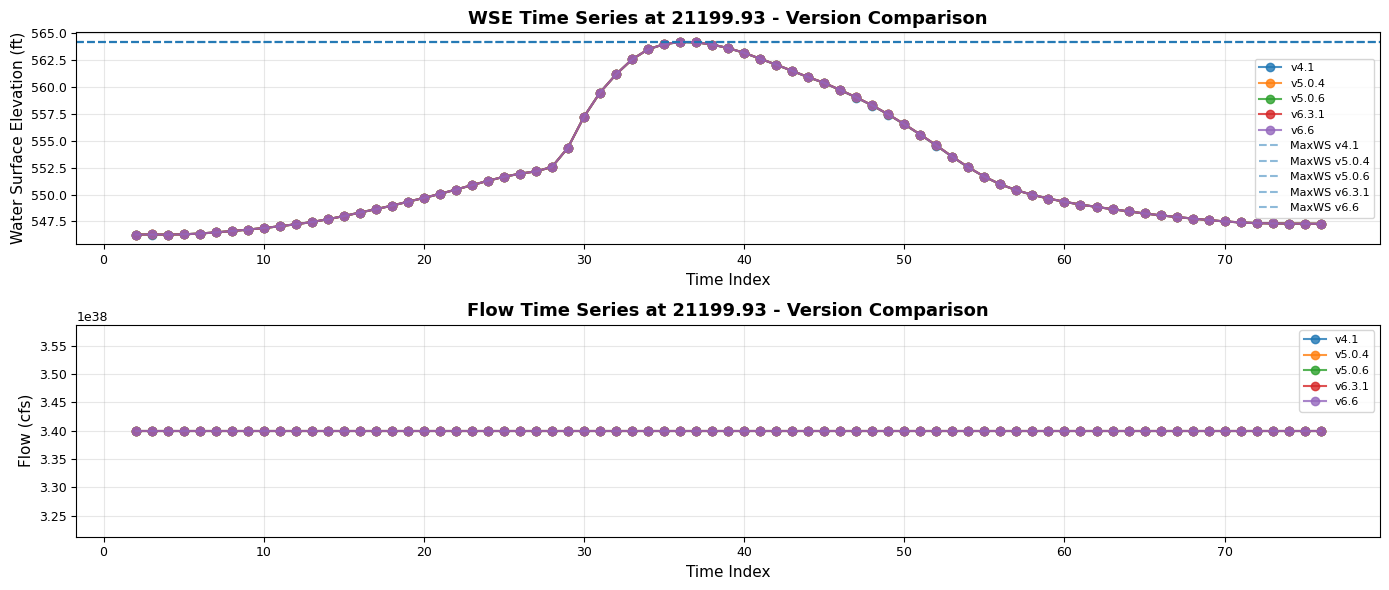


Station 21199.93:
  v4.1: timesteps=75, max_wse=564.16 ft
  v5.0.4: timesteps=75, max_wse=564.16 ft
  v5.0.6: timesteps=75, max_wse=564.16 ft
  v6.3.1: timesteps=75, max_wse=564.16 ft
  v6.6: timesteps=75, max_wse=564.16 ft


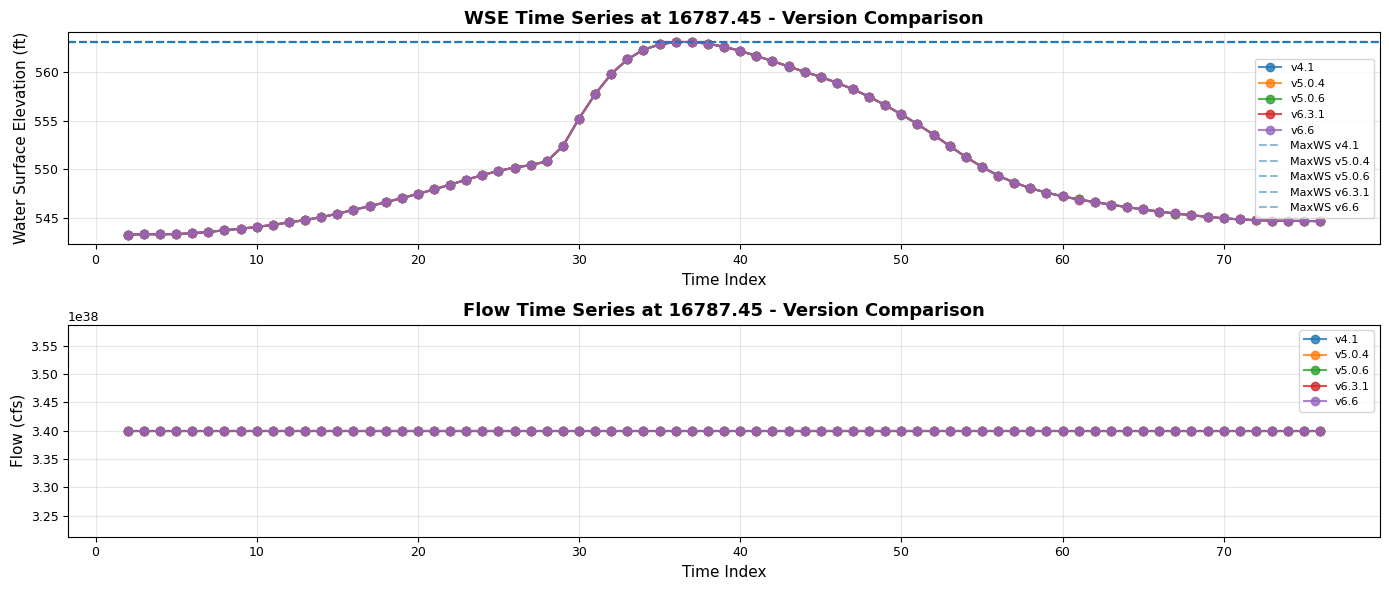


Station 16787.45:
  v4.1: timesteps=75, max_wse=563.08 ft
  v5.0.4: timesteps=75, max_wse=563.09 ft
  v5.0.6: timesteps=75, max_wse=563.09 ft
  v6.3.1: timesteps=75, max_wse=563.09 ft
  v6.6: timesteps=75, max_wse=563.09 ft


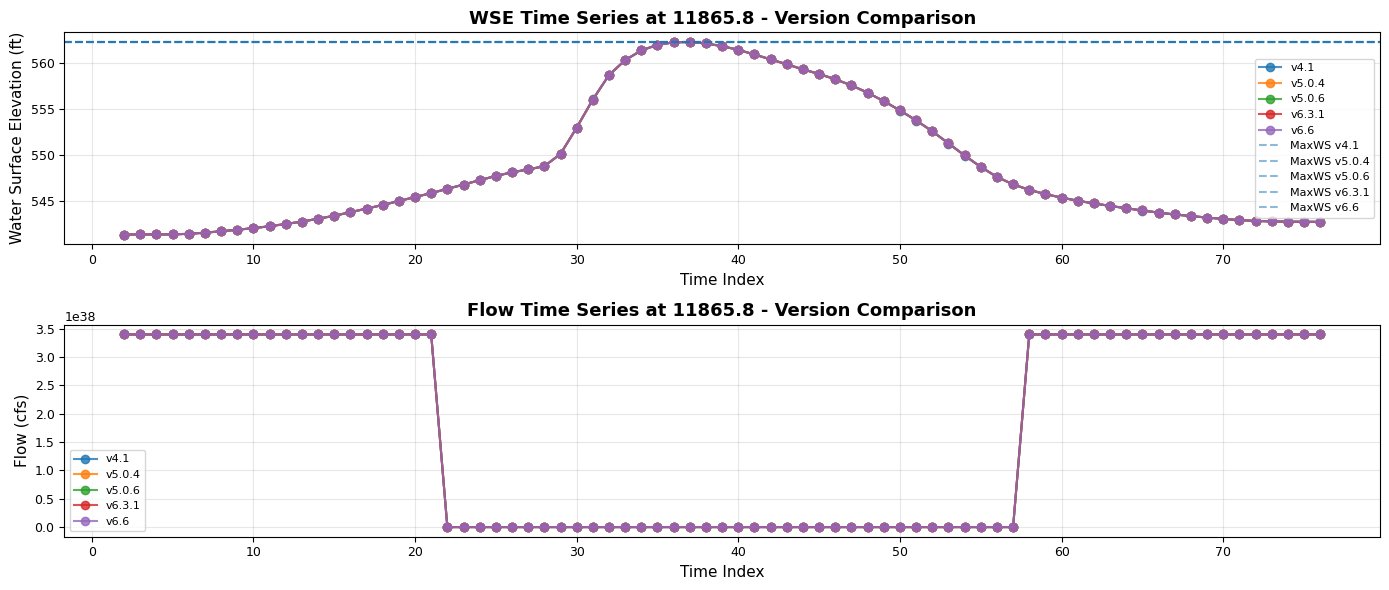


Station 11865.8:
  v4.1: timesteps=75, max_wse=562.22 ft
  v5.0.4: timesteps=75, max_wse=562.21 ft
  v5.0.6: timesteps=75, max_wse=562.21 ft
  v6.3.1: timesteps=75, max_wse=562.21 ft
  v6.6: timesteps=75, max_wse=562.21 ft


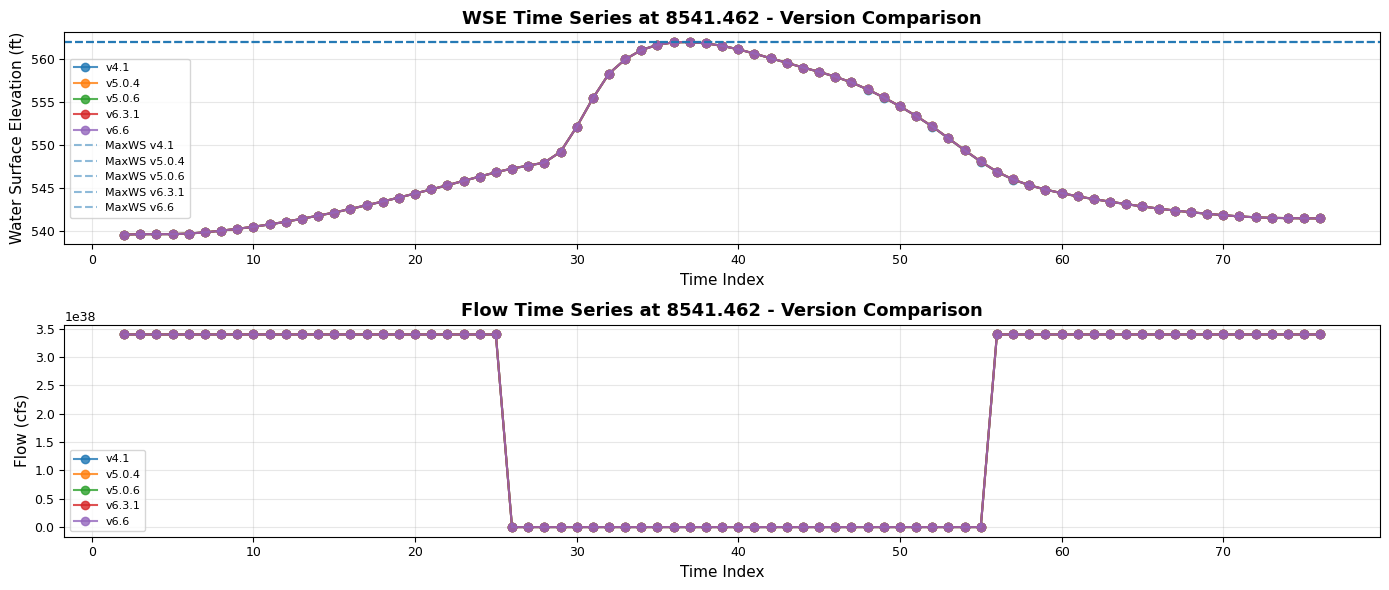


Station 8541.462:
  v4.1: timesteps=75, max_wse=562.01 ft
  v5.0.4: timesteps=75, max_wse=562.01 ft
  v5.0.6: timesteps=75, max_wse=562.01 ft
  v6.3.1: timesteps=75, max_wse=562.01 ft
  v6.6: timesteps=75, max_wse=562.01 ft


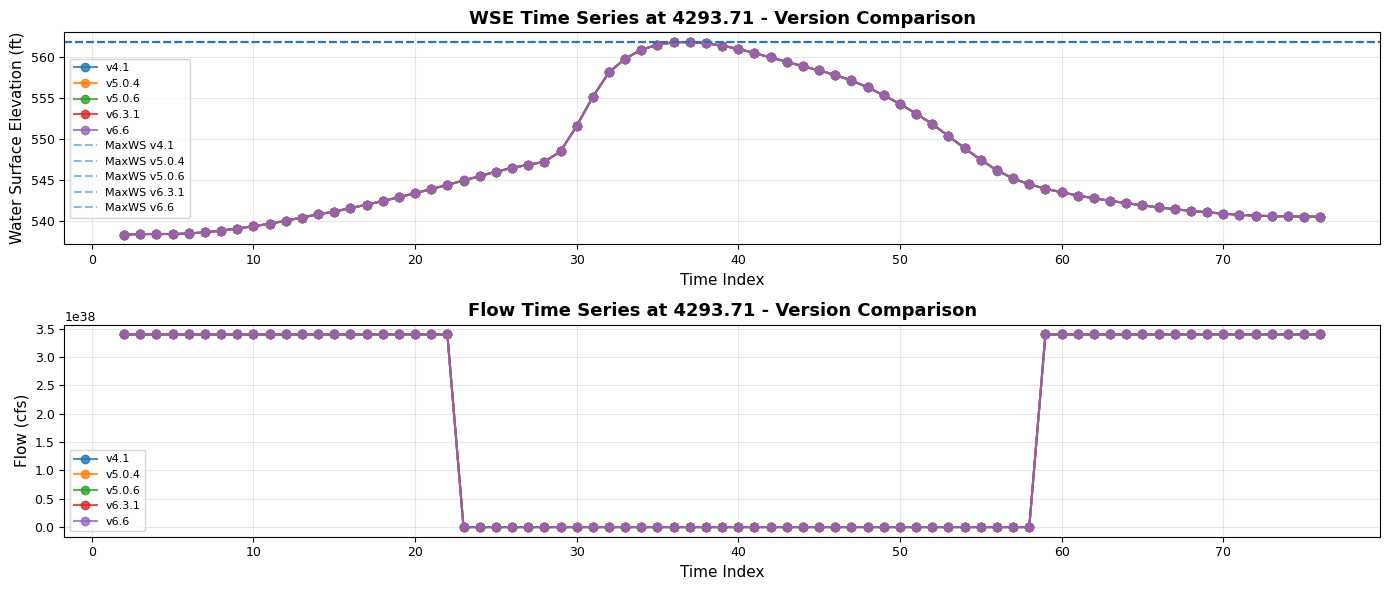


Station 4293.71:
  v4.1: timesteps=75, max_wse=561.86 ft
  v5.0.4: timesteps=75, max_wse=561.85 ft
  v5.0.6: timesteps=75, max_wse=561.85 ft
  v6.3.1: timesteps=75, max_wse=561.85 ft
  v6.6: timesteps=75, max_wse=561.85 ft


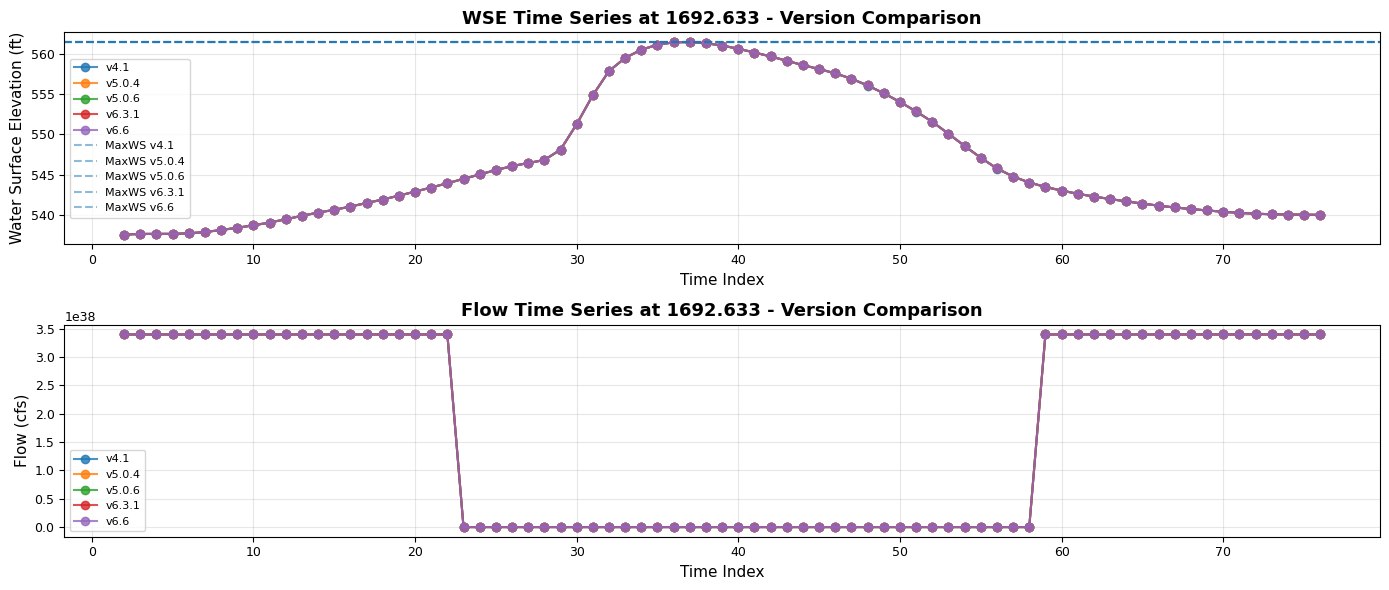


Station 1692.633:
  v4.1: timesteps=75, max_wse=561.44 ft
  v5.0.4: timesteps=75, max_wse=561.44 ft
  v5.0.6: timesteps=75, max_wse=561.44 ft
  v6.3.1: timesteps=75, max_wse=561.44 ft
  v6.6: timesteps=75, max_wse=561.44 ft

Max WSE by version at station 138154.4:
  v4.1: 672.81 ft
  v5.0.4: 672.81 ft
  v5.0.6: 672.81 ft
  v6.3.1: 672.81 ft
  v6.6: 672.81 ft


In [25]:
# Plot comparison at multiple cross sections (every 5th station)
if unsteady_results:
    # Gather all station IDs across versions
    xs_set = set()
    for df in unsteady_results.values():
        try:
            xs_set.update(df['node_id'].astype(float).unique().tolist())
        except Exception:
            xs_set.update(df['node_id'].unique().tolist())

    all_xs = sorted(xs_set, reverse=True)  # upstream -> downstream
    if not all_xs:
        print("No cross section data found in unsteady_results")
    else:
        # Select every 5th cross section for plotting (adjust step as needed)
        step = 5
        selected_xs = all_xs[::step] if len(all_xs) > step else all_xs
        print(f"Plotting {len(selected_xs)} stations (every {step}th of {len(all_xs)} total)")

        for xs_id in selected_xs:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6))

            # Plot WSE time series for each version at this station
            for version, df in unsteady_results.items():
                # FIX: Convert node_id to float for comparison
                df_float = df.copy()
                df_float['node_id'] = df_float['node_id'].astype(float)
                xs_data = df_float[df_float['node_id'] == xs_id].sort_values('time_index')
                if len(xs_data):
                    ax1.plot(xs_data['time_index'], xs_data['wsel'],
                             marker='o', label=f'v{version}', alpha=0.8)

            # Add Max WS reference lines (if available) for this station
            for version, df in max_ws_data.items():
                try:
                    df_float = df.copy()
                    df_float['node_id'] = df_float['node_id'].astype(float)
                    max_row = df_float[df_float['node_id'] == xs_id]
                    if len(max_row):
                        max_wse = float(max_row['wsel'].iloc[0])
                        ax1.axhline(max_wse, linestyle='--', alpha=0.5, label=f'MaxWS v{version}')
                except Exception:
                    continue

            ax1.set_xlabel('Time Index', fontsize=11)
            ax1.set_ylabel('Water Surface Elevation (ft)', fontsize=11)
            ax1.set_title(f'WSE Time Series at {xs_id} - Version Comparison',
                          fontsize=13, fontweight='bold')
            ax1.legend(fontsize=8)
            ax1.grid(True, alpha=0.3)

            # Plot Flow time series for each version at this station
            for version, df in unsteady_results.items():
                # FIX: Convert node_id to float for comparison
                df_float = df.copy()
                df_float['node_id'] = df_float['node_id'].astype(float)
                xs_data = df_float[df_float['node_id'] == xs_id].sort_values('time_index')
                if len(xs_data):
                    ax2.plot(xs_data['time_index'], xs_data['flow'],
                             marker='o', label=f'v{version}', alpha=0.8)

            ax2.set_xlabel('Time Index', fontsize=11)
            ax2.set_ylabel('Flow (cfs)', fontsize=11)
            ax2.set_title(f'Flow Time Series at {xs_id} - Version Comparison',
                          fontsize=13, fontweight='bold')
            ax2.legend(fontsize=8)
            ax2.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

            # Basic per-station stats
            print(f"\nStation {xs_id}:")
            for version, df in unsteady_results.items():
                df_float = df.copy()
                df_float['node_id'] = df_float['node_id'].astype(float)
                xs_data = df_float[df_float['node_id'] == xs_id]
                if len(xs_data):
                    print(f"  v{version}: timesteps={len(xs_data)}, max_wse={xs_data['wsel'].max():.2f} ft")
                else:
                    print(f"  v{version}: no data")

        # Summary of Max WS across versions for the first selected station (if any)
        if selected_xs:
            summary_xs = selected_xs[0]
            print(f"\nMax WSE by version at station {summary_xs}:")
            for version, df in max_ws_data.items():
                try:
                    df_float = df.copy()
                    df_float['node_id'] = df_float['node_id'].astype(float)
                    max_row = df_float[df_float['node_id'] == summary_xs]
                    if len(max_row):
                        max_wse = float(max_row['wsel'].iloc[0])
                        print(f"  v{version}: {max_wse:.2f} ft")
                    else:
                        print(f"  v{version}: N/A")
                except Exception:
                    print(f"  v{version}: N/A")

else:
    print("Uncomment code above to run multi-version comparison")

2025-11-17 14:18:03 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p02 to C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p08


2025-11-17 14:18:03 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p08


2025-11-17 14:18:03 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 08


2025-11-17 14:18:03 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.rasmap


2025-11-17 14:18:03 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.rasmap


2025-11-17 14:18:03 - ras_commander.RasControl - INFO - Opening HEC-RAS: RAS504.HECRASController (version: 5.0.4)


=== MULTI-VERSION STEADY STATE COMPARISON ===

Processing HEC-RAS 5.0.4...
  Cloned to Plan 08
  Running Plan 08 with 2 cores...


2025-11-17 14:18:04 - ras_commander.RasControl - INFO - Opening project: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.prj


2025-11-17 14:18:04 - ras_commander.RasControl - INFO - Detected ras.exe PID 383116 (confidence: 100/100)


2025-11-17 14:18:04 - ras_commander.RasControl - INFO - Executing operation...


2025-11-17 14:18:04 - ras_commander.RasControl - INFO - Setting current plan to: Steady - v5.0.4


2025-11-17 14:18:04 - ras_commander.RasControl - INFO - Starting computation...


2025-11-17 14:18:07 - ras_commander.RasControl - INFO - Spawned watchdog process PID 384380 (monitoring PID 383116)


2025-11-17 14:18:07 - ras_commander.RasControl - INFO - Waiting for computation to complete...


2025-11-17 14:18:07 - ras_commander.RasControl - INFO - Computation completed (polled 0 times)


2025-11-17 14:18:07 - ras_commander.RasControl - INFO - Operation completed successfully


2025-11-17 14:18:07 - ras_commander.RasControl - INFO - Closing HEC-RAS...


2025-11-17 14:18:07 - ras_commander.RasControl - INFO - HEC-RAS closed via QuitRas()


2025-11-17 14:18:07 - ras_commander.RasControl - INFO - Terminating tracked ras.exe PID 383116


2025-11-17 14:18:07 - ras_commander.RasControl - INFO - Opening HEC-RAS: RAS504.HECRASController (version: 5.0.4)


2025-11-17 14:18:07 - ras_commander.RasControl - INFO - Opening project: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.prj


True ['Starting Steady Computations', 'Computing', 'Computations Completed']


2025-11-17 14:18:08 - ras_commander.RasControl - INFO - Detected ras.exe PID 385936 (confidence: 100/100)


2025-11-17 14:18:08 - ras_commander.RasControl - INFO - Executing operation...


2025-11-17 14:18:08 - ras_commander.RasControl - INFO - Setting current plan to: Steady - v5.0.4


2025-11-17 14:18:08 - ras_commander.RasControl - INFO - Found 8 profiles


2025-11-17 14:18:08 - ras_commander.RasControl - INFO - Found 1 rivers


2025-11-17 14:18:10 - ras_commander.RasControl - INFO - Extracted 1424 result rows


2025-11-17 14:18:10 - ras_commander.RasControl - INFO - Operation completed successfully


2025-11-17 14:18:10 - ras_commander.RasControl - INFO - Closing HEC-RAS...


2025-11-17 14:18:10 - ras_commander.RasControl - INFO - HEC-RAS closed via QuitRas()


2025-11-17 14:18:10 - ras_commander.RasControl - INFO - Terminating tracked ras.exe PID 385936


2025-11-17 14:18:10 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p02 to C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p09


2025-11-17 14:18:10 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p09


2025-11-17 14:18:10 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 09


2025-11-17 14:18:10 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.rasmap


2025-11-17 14:18:10 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.rasmap


2025-11-17 14:18:10 - ras_commander.RasControl - INFO - Opening HEC-RAS: RAS506.HECRASController (version: 5.0.6)


  ✓ Extracted 1424 rows -> working\steady_v504.csv

Processing HEC-RAS 5.0.6...
  Cloned to Plan 09
  Running Plan 09 with 2 cores...


2025-11-17 14:18:11 - ras_commander.RasControl - INFO - Opening project: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.prj


2025-11-17 14:18:11 - ras_commander.RasControl - INFO - Detected ras.exe PID 388016 (confidence: 100/100)


2025-11-17 14:18:11 - ras_commander.RasControl - INFO - Executing operation...


2025-11-17 14:18:11 - ras_commander.RasControl - INFO - Setting current plan to: Steady - v5.0.6


2025-11-17 14:18:11 - ras_commander.RasControl - INFO - Starting computation...


2025-11-17 14:18:13 - ras_commander.RasControl - INFO - Spawned watchdog process PID 384224 (monitoring PID 388016)


2025-11-17 14:18:13 - ras_commander.RasControl - INFO - Waiting for computation to complete...


2025-11-17 14:18:13 - ras_commander.RasControl - INFO - Computation completed (polled 0 times)


2025-11-17 14:18:13 - ras_commander.RasControl - INFO - Operation completed successfully


2025-11-17 14:18:13 - ras_commander.RasControl - INFO - Closing HEC-RAS...


2025-11-17 14:18:13 - ras_commander.RasControl - INFO - HEC-RAS closed via QuitRas()


2025-11-17 14:18:13 - ras_commander.RasControl - INFO - Terminating tracked ras.exe PID 388016


2025-11-17 14:18:13 - ras_commander.RasControl - INFO - Opening HEC-RAS: RAS506.HECRASController (version: 5.0.6)


2025-11-17 14:18:13 - ras_commander.RasControl - INFO - Opening project: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.prj


True ['Starting Steady Computations', 'Computing', 'Computations Completed']


2025-11-17 14:18:14 - ras_commander.RasControl - INFO - Detected ras.exe PID 241052 (confidence: 100/100)


2025-11-17 14:18:14 - ras_commander.RasControl - INFO - Executing operation...


2025-11-17 14:18:14 - ras_commander.RasControl - INFO - Setting current plan to: Steady - v5.0.6


2025-11-17 14:18:14 - ras_commander.RasControl - INFO - Found 8 profiles


2025-11-17 14:18:14 - ras_commander.RasControl - INFO - Found 1 rivers


2025-11-17 14:18:17 - ras_commander.RasControl - INFO - Extracted 1424 result rows


2025-11-17 14:18:17 - ras_commander.RasControl - INFO - Operation completed successfully


2025-11-17 14:18:17 - ras_commander.RasControl - INFO - Closing HEC-RAS...


2025-11-17 14:18:17 - ras_commander.RasControl - INFO - HEC-RAS closed via QuitRas()


2025-11-17 14:18:17 - ras_commander.RasControl - INFO - Terminating tracked ras.exe PID 241052


2025-11-17 14:18:17 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p02 to C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p10


2025-11-17 14:18:17 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p10


2025-11-17 14:18:17 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 10


2025-11-17 14:18:17 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.rasmap


2025-11-17 14:18:17 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.rasmap


2025-11-17 14:18:17 - ras_commander.RasControl - INFO - Opening HEC-RAS: RAS631.HECRASController (version: 6.3.1)


  ✓ Extracted 1424 rows -> working\steady_v506.csv

Processing HEC-RAS 6.3.1...
  Cloned to Plan 10
  Running Plan 10 with 2 cores...


2025-11-17 14:18:17 - ras_commander.RasControl - INFO - Opening project: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.prj


2025-11-17 14:18:18 - ras_commander.RasControl - INFO - Detected ras.exe PID 387984 (confidence: 100/100)


2025-11-17 14:18:18 - ras_commander.RasControl - INFO - Executing operation...


2025-11-17 14:18:18 - ras_commander.RasControl - INFO - Setting current plan to: Steady - v6.3.1


2025-11-17 14:18:18 - ras_commander.RasControl - INFO - Starting computation...


2025-11-17 14:18:21 - ras_commander.RasControl - INFO - Spawned watchdog process PID 386540 (monitoring PID 387984)


2025-11-17 14:18:21 - ras_commander.RasControl - INFO - Waiting for computation to complete...


2025-11-17 14:18:21 - ras_commander.RasControl - INFO - Computation completed (polled 0 times)


2025-11-17 14:18:21 - ras_commander.RasControl - INFO - Operation completed successfully


2025-11-17 14:18:21 - ras_commander.RasControl - INFO - Closing HEC-RAS...


2025-11-17 14:18:21 - ras_commander.RasControl - INFO - HEC-RAS closed via QuitRas()


2025-11-17 14:18:21 - ras_commander.RasControl - INFO - Terminating tracked ras.exe PID 387984


2025-11-17 14:18:21 - ras_commander.RasControl - INFO - Opening HEC-RAS: RAS631.HECRASController (version: 6.3.1)


2025-11-17 14:18:21 - ras_commander.RasControl - INFO - Opening project: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.prj


True ['Starting Steady Computations', 'Computing', 'Computations Completed']


2025-11-17 14:18:22 - ras_commander.RasControl - INFO - Detected ras.exe PID 387780 (confidence: 100/100)


2025-11-17 14:18:22 - ras_commander.RasControl - INFO - Executing operation...


2025-11-17 14:18:22 - ras_commander.RasControl - INFO - Setting current plan to: Steady - v6.3.1


2025-11-17 14:18:22 - ras_commander.RasControl - INFO - Found 8 profiles


2025-11-17 14:18:22 - ras_commander.RasControl - INFO - Found 1 rivers


2025-11-17 14:18:25 - ras_commander.RasControl - INFO - Extracted 1424 result rows


2025-11-17 14:18:25 - ras_commander.RasControl - INFO - Operation completed successfully


2025-11-17 14:18:25 - ras_commander.RasControl - INFO - Closing HEC-RAS...


2025-11-17 14:18:25 - ras_commander.RasControl - INFO - HEC-RAS closed via QuitRas()


2025-11-17 14:18:25 - ras_commander.RasControl - INFO - Terminating tracked ras.exe PID 387780


2025-11-17 14:18:25 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p02 to C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p11


2025-11-17 14:18:25 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p11


2025-11-17 14:18:25 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 11


2025-11-17 14:18:25 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.rasmap


2025-11-17 14:18:25 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.rasmap


2025-11-17 14:18:25 - ras_commander.RasControl - INFO - Opening HEC-RAS: RAS66.HECRASController (version: 6.6)


  ✓ Extracted 1424 rows -> working\steady_v631.csv

Processing HEC-RAS 6.6...
  Cloned to Plan 11
  Running Plan 11 with 2 cores...


2025-11-17 14:18:25 - ras_commander.RasControl - INFO - Opening project: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.prj


2025-11-17 14:18:26 - ras_commander.RasControl - INFO - Detected ras.exe PID 387376 (confidence: 100/100)


2025-11-17 14:18:26 - ras_commander.RasControl - INFO - Executing operation...


2025-11-17 14:18:26 - ras_commander.RasControl - INFO - Setting current plan to: Steady - v6.6


2025-11-17 14:18:26 - ras_commander.RasControl - INFO - Starting computation...


2025-11-17 14:18:29 - ras_commander.RasControl - INFO - Spawned watchdog process PID 385128 (monitoring PID 387376)


2025-11-17 14:18:29 - ras_commander.RasControl - INFO - Waiting for computation to complete...


2025-11-17 14:18:29 - ras_commander.RasControl - INFO - Computation completed (polled 0 times)


2025-11-17 14:18:29 - ras_commander.RasControl - INFO - Operation completed successfully


2025-11-17 14:18:29 - ras_commander.RasControl - INFO - Closing HEC-RAS...


2025-11-17 14:18:29 - ras_commander.RasControl - INFO - HEC-RAS closed via QuitRas()


2025-11-17 14:18:29 - ras_commander.RasControl - INFO - Terminating tracked ras.exe PID 387376


2025-11-17 14:18:29 - ras_commander.RasControl - INFO - Opening HEC-RAS: RAS66.HECRASController (version: 6.6)


2025-11-17 14:18:29 - ras_commander.RasControl - INFO - Opening project: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.prj


True ['Starting Steady Computations', 'Computing', 'Computations Completed']


2025-11-17 14:18:30 - ras_commander.RasControl - INFO - Detected ras.exe PID 382740 (confidence: 100/100)


2025-11-17 14:18:30 - ras_commander.RasControl - INFO - Executing operation...


2025-11-17 14:18:30 - ras_commander.RasControl - INFO - Setting current plan to: Steady - v6.6


2025-11-17 14:18:30 - ras_commander.RasControl - INFO - Found 8 profiles


2025-11-17 14:18:30 - ras_commander.RasControl - INFO - Found 1 rivers


2025-11-17 14:18:33 - ras_commander.RasControl - INFO - Extracted 1424 result rows


2025-11-17 14:18:33 - ras_commander.RasControl - INFO - Operation completed successfully


2025-11-17 14:18:33 - ras_commander.RasControl - INFO - Closing HEC-RAS...


2025-11-17 14:18:33 - ras_commander.RasControl - INFO - HEC-RAS closed via QuitRas()


2025-11-17 14:18:33 - ras_commander.RasControl - INFO - Terminating tracked ras.exe PID 382740


  ✓ Extracted 1424 rows -> working\steady_v66.csv



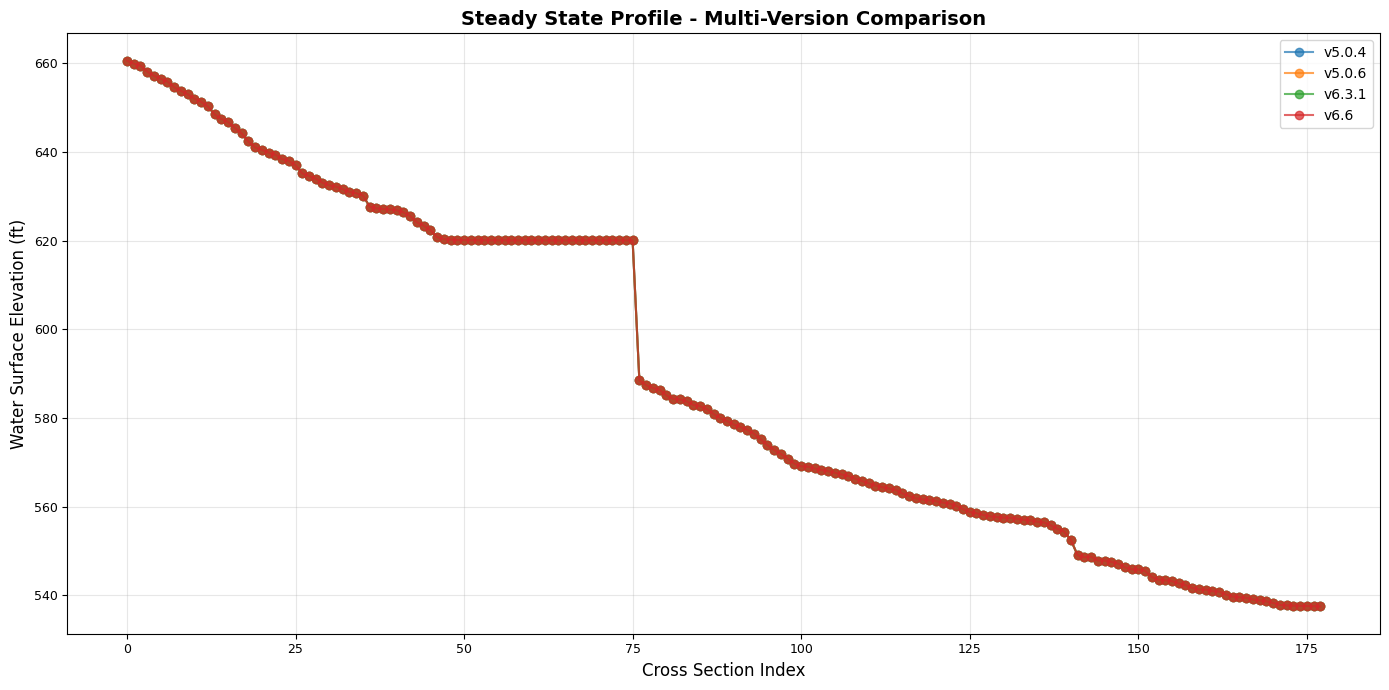


✓ Compared 4 versions


In [26]:
# OPTIONAL: Multi-version steady state comparison

from ras_commander import RasPlan

# Versions to test - all versions with actual COM interfaces
test_versions = [
  #  ("4.1", "41"),       # HEC-RAS 4.1     → RAS41.HECRASController
  #  ("5.0.1", "501"),    # HEC-RAS 5.0.1   → RAS501.HECRASController
  #  ("5.0.3", "503"),    # HEC-RAS 5.0.3   → RAS503.HECRASController
    ("5.0.4", "504"),    # HEC-RAS 5.0.4   → RAS504.HECRASController
    ("5.0.6", "506"),    # HEC-RAS 5.0.6   → RAS506.HECRASController
    ("6.3.1", "631"),    # HEC-RAS 6.3.1   → RAS631.HECRASController
    ("6.6", "66"),       # HEC-RAS 6.6     → RAS66.HECRASController
]

steady_results = {}

print("=== MULTI-VERSION STEADY STATE COMPARISON ===\n")

for version_name, version_code in test_versions:
    print(f"Processing HEC-RAS {version_name}...")
    
    # Clone Plan 02 for this version
    new_plan = RasPlan.clone_plan("02",
                      new_shortid=f"Steady_{version_code}",
                      new_title=f"Steady - v{version_name}")
    print(f"  Cloned to Plan {new_plan}")
    
    # Re-initialize with this version
    init_ras_project(project_path, version_name)
    
    # Run the plan using ras-commander's compute_plan() instead of RasControl.run_plan
    print(f"  Running Plan {new_plan} with 2 cores...")
    try:
        # Use direct command line execution, preferred over RasControl.run_plan
        #RasCmdr.compute_plan(new_plan, clear_geompre=True, num_cores=2)
        success, msgs = RasControl.run_plan(new_plan, force_recompute=True)
        print(success, msgs)
        # Extract results
        df = RasControl.get_steady_results(new_plan)
        steady_results[version_name] = df

        # Save CSV
        csv_path = Path(f"working/steady_v{version_code}.csv")
        df.to_csv(csv_path, index=False)
        print(f"  ✓ Extracted {len(df)} rows -> {csv_path}")
    except Exception as e:
        print(f"  ✗ Failed: {e}")

    print()

# Plot comparison - first profile from each version
if steady_results:
    fig, ax = plt.subplots(figsize=(14, 7))
    
    for version, df in steady_results.items():
        first_prof = df[df['profile'] == df['profile'].iloc[0]]
        ax.plot(range(len(first_prof)), first_prof['wsel'], 
                marker='o', label=f'v{version}', alpha=0.7)
    
    ax.set_xlabel('Cross Section Index', fontsize=12)
    ax.set_ylabel('Water Surface Elevation (ft)', fontsize=12)
    ax.set_title('Steady State Profile - Multi-Version Comparison', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Compared {len(steady_results)} versions")

else:
    print("Uncomment code above to run multi-version comparison")